In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Concatenate, Dropout, GaussianNoise, LayerNormalization, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

In [3]:
def normalize_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [4]:
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
x_train = normalize_tanh(x_train.reshape(-1, 28, 28, 1))

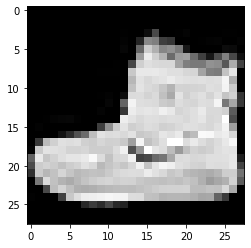

In [6]:
plt.imshow(unnormalize_tanh(normalize_tanh(x_train[0])).reshape(28,28), cmap='gray')

In [7]:
# network parameters
width = 28
height = 28
latent_dim = 100



def build_generator():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_latent')



    x = Dense(7*7*128)(latent_inputs)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Reshape((7,7,128))(x)


    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)    
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)



    img_outputs = Conv2D(1,5, strides=1, activation='tanh', padding='same')(x)


    return Model(latent_inputs, img_outputs, name='generator')

generator = build_generator()
generator.summary()








Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_latent (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        73

In [8]:
def build_critic():
    inputs = Input(shape=(width,height,1), name='critic_input')
    
    

    
    x = Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(258, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Flatten()(x)

    valid = Dense(1)(x)



    return Model(inputs, valid, name='critic')
build_critic().summary()

Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
layer_normalization (LayerNo (None, 14, 14, 64)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 7, 7, 128)         256  

In [9]:
generator = build_generator()
critic = build_critic()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

In [10]:
@tf.function
def train_step_generator():
    
    batch_size = 64
    latent_dim = 100
    
    with tf.GradientTape() as gen_tape:    
        

        
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=True)       
        

        # gan loss
        fake_output = critic(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_output)
   
        generator_loss = gen_loss


    
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss



@tf.function
def train_step_critic(images):
    
    batch_size = 64
    latent_dim = 100
    gp_lambda = 10
    
    with tf.GradientTape() as critic_tape:
        # generate 
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=False)
        
        real_output = critic(images, training=True)
        fake_output = critic(generated_images, training=True)
        
        beta = tf.random.uniform(shape=tf.shape(images), minval=0.0, maxval=1.0)
        perturbed_images = images + 0.5 * tf.math.reduce_std(images) * beta
        alpha = tf.random.uniform([batch_size, 1, 1, 1], -1.0, 1.0)
        diff = perturbed_images - images
        interpolated_images = images + (alpha * diff)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            interpolated_output = critic(interpolated_images, training=True)
        gp_gradients = gp_tape.gradient(interpolated_output, interpolated_images)
        
        # l2 norm on all axis except batch
        gp_gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis=[1,2,3]))
        gp = tf.reduce_mean(tf.square(gp_gradients_l2_norm-1))
        
        
        
        loss_real = tf.reduce_mean(real_output)
        loss_fake = tf.reduce_mean(fake_output)
        critic_loss = (loss_fake - loss_real) + gp_lambda * gp 
        
    gradients_of_critic = critic_tape.gradient(critic_loss, critic.trainable_variables)
    
    critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
    return loss_real, loss_fake
    
        
        
        

Iteration [1/10000]......5.388(s) gen: 0.29147 - critic_fake: -1.49072 - critic_real: -1.34792 - neg_critic: 0.14280
Iteration [2/10000]......0.132(s) gen: 0.36384 - critic_fake: -2.24199 - critic_real: 0.16623 - neg_critic: 2.40822
Iteration [3/10000]......0.131(s) gen: 0.31502 - critic_fake: -2.24681 - critic_real: 1.81116 - neg_critic: 4.05797
Iteration [4/10000]......0.117(s) gen: -0.04834 - critic_fake: -2.16990 - critic_real: 3.79504 - neg_critic: 5.96494
Iteration [5/10000]......0.113(s) gen: -0.56596 - critic_fake: -2.51432 - critic_real: 6.35686 - neg_critic: 8.87119
Iteration [6/10000]......0.110(s) gen: -0.27353 - critic_fake: -1.29008 - critic_real: 8.59898 - neg_critic: 9.88905
Iteration [7/10000]......0.110(s) gen: -0.52297 - critic_fake: -1.60383 - critic_real: 10.90772 - neg_critic: 12.51155
Iteration [8/10000]......0.110(s) gen: -0.97021 - critic_fake: -0.85654 - critic_real: 13.71707 - neg_critic: 14.57361
Iteration [9/10000]......0.110(s) gen: -1.20476 - critic_fake:

Iteration [69/10000]......0.112(s) gen: -91.15654 - critic_fake: 48.35882 - critic_real: 92.58897 - neg_critic: 44.23015
Iteration [70/10000]......0.110(s) gen: -91.37692 - critic_fake: 25.31197 - critic_real: 92.86844 - neg_critic: 67.55647
Iteration [71/10000]......0.110(s) gen: -91.99860 - critic_fake: -7.72097 - critic_real: 93.30485 - neg_critic: 101.02582
Iteration [72/10000]......0.110(s) gen: -92.28626 - critic_fake: -26.52321 - critic_real: 93.85757 - neg_critic: 120.38078
Iteration [73/10000]......0.111(s) gen: -92.90285 - critic_fake: -75.77435 - critic_real: 94.46017 - neg_critic: 170.23452
Iteration [74/10000]......0.111(s) gen: -93.76974 - critic_fake: -62.82615 - critic_real: 95.27140 - neg_critic: 158.09754
Iteration [75/10000]......0.111(s) gen: -94.59576 - critic_fake: -64.56517 - critic_real: 95.87525 - neg_critic: 160.44042
Iteration [76/10000]......0.111(s) gen: -95.63496 - critic_fake: -94.16226 - critic_real: 96.77568 - neg_critic: 190.93794
Iteration [77/10000].

Iteration [137/10000]......0.111(s) gen: -109.87575 - critic_fake: 33.80124 - critic_real: 105.32780 - neg_critic: 71.52656
Iteration [138/10000]......0.111(s) gen: -110.01947 - critic_fake: 29.04266 - critic_real: 105.78916 - neg_critic: 76.74649
Iteration [139/10000]......0.112(s) gen: -110.13290 - critic_fake: 15.29341 - critic_real: 105.72923 - neg_critic: 90.43581
Iteration [140/10000]......0.113(s) gen: -110.21238 - critic_fake: 25.00393 - critic_real: 106.29522 - neg_critic: 81.29129
Iteration [141/10000]......0.111(s) gen: -110.84727 - critic_fake: -37.25995 - critic_real: 105.99239 - neg_critic: 143.25234
Iteration [142/10000]......0.110(s) gen: -111.59455 - critic_fake: -65.97896 - critic_real: 107.70088 - neg_critic: 173.67984
Iteration [143/10000]......0.110(s) gen: -112.54727 - critic_fake: -83.27756 - critic_real: 109.02366 - neg_critic: 192.30122
Iteration [144/10000]......0.109(s) gen: -113.17875 - critic_fake: -78.93254 - critic_real: 110.01041 - neg_critic: 188.94294


Iteration [203/10000]......0.112(s) gen: -127.04259 - critic_fake: -77.96582 - critic_real: 123.29000 - neg_critic: 201.25582
Iteration [204/10000]......0.121(s) gen: -126.64252 - critic_fake: 33.99487 - critic_real: 124.00648 - neg_critic: 90.01161
Iteration [205/10000]......0.112(s) gen: -126.58511 - critic_fake: 115.20537 - critic_real: 123.97290 - neg_critic: 8.76754
Iteration [206/10000]......0.112(s) gen: -126.53638 - critic_fake: 114.59907 - critic_real: 123.79312 - neg_critic: 9.19405
Iteration [207/10000]......0.111(s) gen: -126.52859 - critic_fake: 113.35283 - critic_real: 123.67373 - neg_critic: 10.32091
Iteration [208/10000]......0.116(s) gen: -126.52866 - critic_fake: 111.39436 - critic_real: 123.71438 - neg_critic: 12.32002
Iteration [209/10000]......0.114(s) gen: -126.45274 - critic_fake: 108.18282 - critic_real: 122.98024 - neg_critic: 14.79742
Iteration [210/10000]......0.110(s) gen: -126.38471 - critic_fake: 102.96480 - critic_real: 122.75412 - neg_critic: 19.78932
It

Iteration [269/10000]......0.112(s) gen: -146.43478 - critic_fake: 93.03355 - critic_real: 140.14247 - neg_critic: 47.10892
Iteration [270/10000]......0.113(s) gen: -147.10806 - critic_fake: 17.65598 - critic_real: 139.90532 - neg_critic: 122.24934
Iteration [271/10000]......0.113(s) gen: -147.86139 - critic_fake: -69.15094 - critic_real: 141.39180 - neg_critic: 210.54274
Iteration [272/10000]......0.112(s) gen: -149.27444 - critic_fake: -141.86516 - critic_real: 143.34826 - neg_critic: 285.21342
Iteration [273/10000]......0.111(s) gen: -150.64349 - critic_fake: -145.88751 - critic_real: 145.86382 - neg_critic: 291.75133
Iteration [274/10000]......0.113(s) gen: -151.96591 - critic_fake: -155.40483 - critic_real: 147.66331 - neg_critic: 303.06814
Iteration [275/10000]......0.113(s) gen: -152.32658 - critic_fake: 49.34127 - critic_real: 149.14250 - neg_critic: 99.80124
Iteration [276/10000]......0.112(s) gen: -153.41368 - critic_fake: -142.25121 - critic_real: 149.06642 - neg_critic: 291

Iteration [335/10000]......0.112(s) gen: -179.78076 - critic_fake: -29.69966 - critic_real: 174.13388 - neg_critic: 203.83354
Iteration [336/10000]......0.111(s) gen: -179.97015 - critic_fake: -18.04462 - critic_real: 174.24528 - neg_critic: 192.28990
Iteration [337/10000]......0.112(s) gen: -180.52672 - critic_fake: -75.25734 - critic_real: 174.22756 - neg_critic: 249.48490
Iteration [338/10000]......0.111(s) gen: -180.63364 - critic_fake: 7.60614 - critic_real: 174.96698 - neg_critic: 167.36084
Iteration [339/10000]......0.113(s) gen: -180.63374 - critic_fake: 152.76493 - critic_real: 175.62784 - neg_critic: 22.86291
Iteration [340/10000]......0.112(s) gen: -180.60742 - critic_fake: 149.01516 - critic_real: 175.03363 - neg_critic: 26.01848
Iteration [341/10000]......0.111(s) gen: -180.55878 - critic_fake: 138.79215 - critic_real: 174.57970 - neg_critic: 35.78755
Iteration [342/10000]......0.112(s) gen: -180.53027 - critic_fake: 116.48431 - critic_real: 174.33904 - neg_critic: 57.8547

Iteration [401/10000]......0.113(s) gen: -180.58685 - critic_fake: 130.67099 - critic_real: 169.57007 - neg_critic: 38.89908
Iteration [402/10000]......0.111(s) gen: -180.40401 - critic_fake: 123.26998 - critic_real: 169.58465 - neg_critic: 46.31467
Iteration [403/10000]......0.111(s) gen: -180.46240 - critic_fake: 123.95670 - critic_real: 169.67295 - neg_critic: 45.71625
Iteration [404/10000]......0.113(s) gen: -180.29823 - critic_fake: 143.13291 - critic_real: 170.72109 - neg_critic: 27.58818
Iteration [405/10000]......0.112(s) gen: -180.39281 - critic_fake: 118.52760 - critic_real: 168.89101 - neg_critic: 50.36341
Iteration [406/10000]......0.112(s) gen: -180.52998 - critic_fake: 95.66823 - critic_real: 169.63059 - neg_critic: 73.96237
Iteration [407/10000]......0.113(s) gen: -180.46082 - critic_fake: 140.89283 - critic_real: 171.28206 - neg_critic: 30.38922
Iteration [408/10000]......0.112(s) gen: -180.30972 - critic_fake: 141.86075 - critic_real: 169.58411 - neg_critic: 27.72337
I

Iteration [467/10000]......0.111(s) gen: -183.66583 - critic_fake: -6.37838 - critic_real: 178.25077 - neg_critic: 184.62915
Iteration [468/10000]......0.112(s) gen: -183.98849 - critic_fake: -19.44584 - critic_real: 178.34126 - neg_critic: 197.78710
Iteration [469/10000]......0.113(s) gen: -183.74777 - critic_fake: -6.79087 - critic_real: 178.54276 - neg_critic: 185.33363
Iteration [470/10000]......0.112(s) gen: -184.27155 - critic_fake: 19.49122 - critic_real: 179.36574 - neg_critic: 159.87452
Iteration [471/10000]......0.111(s) gen: -184.10751 - critic_fake: 22.40048 - critic_real: 179.20626 - neg_critic: 156.80578
Iteration [472/10000]......0.110(s) gen: -184.27368 - critic_fake: -19.47115 - critic_real: 179.45568 - neg_critic: 198.92683
Iteration [473/10000]......0.112(s) gen: -184.96651 - critic_fake: -25.25304 - critic_real: 180.16163 - neg_critic: 205.41466
Iteration [474/10000]......0.111(s) gen: -183.90741 - critic_fake: -1.08712 - critic_real: 181.28203 - neg_critic: 182.369

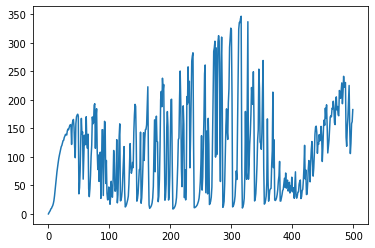

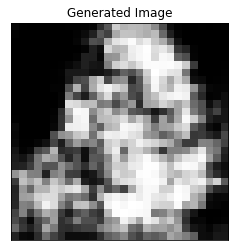

Iteration [501/10000]......0.112(s) gen: -178.94521 - critic_fake: -4.32698 - critic_real: 187.33059 - neg_critic: 191.65757
Iteration [502/10000]......0.112(s) gen: -184.87732 - critic_fake: -36.13072 - critic_real: 187.63047 - neg_critic: 223.76119
Iteration [503/10000]......0.112(s) gen: -184.45380 - critic_fake: 27.20640 - critic_real: 188.66604 - neg_critic: 161.45964
Iteration [504/10000]......0.113(s) gen: -184.41649 - critic_fake: 41.32515 - critic_real: 188.65422 - neg_critic: 147.32907
Iteration [505/10000]......0.112(s) gen: -181.75455 - critic_fake: 73.92821 - critic_real: 188.49561 - neg_critic: 114.56740
Iteration [506/10000]......0.111(s) gen: -180.02118 - critic_fake: 26.23537 - critic_real: 188.37130 - neg_critic: 162.13593
Iteration [507/10000]......0.112(s) gen: -181.53140 - critic_fake: 21.98957 - critic_real: 188.98503 - neg_critic: 166.99546
Iteration [508/10000]......0.112(s) gen: -183.34747 - critic_fake: 19.27957 - critic_real: 188.66050 - neg_critic: 169.38094

Iteration [568/10000]......0.114(s) gen: -84.64399 - critic_fake: 97.01671 - critic_real: 203.32701 - neg_critic: 106.31030
Iteration [569/10000]......0.116(s) gen: -123.36337 - critic_fake: 80.61068 - critic_real: 203.02882 - neg_critic: 122.41814
Iteration [570/10000]......0.113(s) gen: -94.57027 - critic_fake: 98.51386 - critic_real: 204.07349 - neg_critic: 105.55963
Iteration [571/10000]......0.112(s) gen: -20.08787 - critic_fake: 68.38181 - critic_real: 203.98168 - neg_critic: 135.59987
Iteration [572/10000]......0.113(s) gen: -75.32417 - critic_fake: 39.96290 - critic_real: 204.28481 - neg_critic: 164.32191
Iteration [573/10000]......0.115(s) gen: -86.45908 - critic_fake: 97.33784 - critic_real: 204.38251 - neg_critic: 107.04467
Iteration [574/10000]......0.117(s) gen: -115.23622 - critic_fake: 93.07225 - critic_real: 204.50909 - neg_critic: 111.43684
Iteration [575/10000]......0.114(s) gen: -29.01141 - critic_fake: 95.33456 - critic_real: 204.96165 - neg_critic: 109.62709
Iterat

Iteration [634/10000]......0.112(s) gen: -138.14017 - critic_fake: 160.26960 - critic_real: 208.97937 - neg_critic: 48.70977
Iteration [635/10000]......0.112(s) gen: -168.90865 - critic_fake: 139.67287 - critic_real: 208.53985 - neg_critic: 68.86698
Iteration [636/10000]......0.113(s) gen: -177.09160 - critic_fake: 178.62480 - critic_real: 210.74306 - neg_critic: 32.11826
Iteration [637/10000]......0.112(s) gen: -173.60643 - critic_fake: 178.80828 - critic_real: 211.20641 - neg_critic: 32.39814
Iteration [638/10000]......0.112(s) gen: -162.89511 - critic_fake: 173.51807 - critic_real: 210.35338 - neg_critic: 36.83531
Iteration [639/10000]......0.118(s) gen: -160.24226 - critic_fake: 166.87997 - critic_real: 208.64713 - neg_critic: 41.76716
Iteration [640/10000]......0.114(s) gen: -158.64853 - critic_fake: 162.76453 - critic_real: 208.50574 - neg_critic: 45.74122
Iteration [641/10000]......0.114(s) gen: -160.20367 - critic_fake: 161.52514 - critic_real: 209.23164 - neg_critic: 47.70651


Iteration [700/10000]......0.116(s) gen: -191.76291 - critic_fake: 160.32763 - critic_real: 212.59479 - neg_critic: 52.26716
Iteration [701/10000]......0.114(s) gen: -189.09879 - critic_fake: 191.62060 - critic_real: 214.95927 - neg_critic: 23.33867
Iteration [702/10000]......0.116(s) gen: -182.04054 - critic_fake: 185.57579 - critic_real: 212.32689 - neg_critic: 26.75109
Iteration [703/10000]......0.114(s) gen: -175.69223 - critic_fake: 179.15862 - critic_real: 211.02108 - neg_critic: 31.86245
Iteration [704/10000]......0.115(s) gen: -171.57455 - critic_fake: 172.50895 - critic_real: 209.10919 - neg_critic: 36.60024
Iteration [705/10000]......0.114(s) gen: -170.69061 - critic_fake: 168.17330 - critic_real: 209.65742 - neg_critic: 41.48413
Iteration [706/10000]......0.112(s) gen: -152.72641 - critic_fake: 163.49968 - critic_real: 211.35488 - neg_critic: 47.85520
Iteration [707/10000]......0.118(s) gen: -161.05203 - critic_fake: 162.09947 - critic_real: 211.76619 - neg_critic: 49.66672


Iteration [766/10000]......0.114(s) gen: -189.65259 - critic_fake: 165.18801 - critic_real: 210.81777 - neg_critic: 45.62976
Iteration [767/10000]......0.112(s) gen: -185.60535 - critic_fake: 187.74957 - critic_real: 213.24709 - neg_critic: 25.49751
Iteration [768/10000]......0.114(s) gen: -193.15680 - critic_fake: 169.99240 - critic_real: 212.16463 - neg_critic: 42.17223
Iteration [769/10000]......0.113(s) gen: -191.92389 - critic_fake: 190.02833 - critic_real: 212.45037 - neg_critic: 22.42204
Iteration [770/10000]......0.131(s) gen: -183.32281 - critic_fake: 186.12109 - critic_real: 211.26693 - neg_critic: 25.14584
Iteration [771/10000]......0.113(s) gen: -178.06870 - critic_fake: 176.95210 - critic_real: 210.18192 - neg_critic: 33.22981
Iteration [772/10000]......0.112(s) gen: -191.25787 - critic_fake: 180.28618 - critic_real: 211.80730 - neg_critic: 31.52113
Iteration [773/10000]......0.112(s) gen: -183.80969 - critic_fake: 187.20779 - critic_real: 210.46797 - neg_critic: 23.26018


Iteration [832/10000]......0.118(s) gen: -200.34686 - critic_fake: 200.47755 - critic_real: 213.10316 - neg_critic: 12.62561
Iteration [833/10000]......0.115(s) gen: -198.70737 - critic_fake: 194.67914 - critic_real: 211.82451 - neg_critic: 17.14537
Iteration [834/10000]......0.122(s) gen: -195.32262 - critic_fake: 192.00927 - critic_real: 210.11223 - neg_critic: 18.10296
Iteration [835/10000]......0.117(s) gen: -194.41121 - critic_fake: 184.92476 - critic_real: 210.00133 - neg_critic: 25.07657
Iteration [836/10000]......0.113(s) gen: -195.89114 - critic_fake: 185.11688 - critic_real: 211.25516 - neg_critic: 26.13829
Iteration [837/10000]......0.113(s) gen: -201.78876 - critic_fake: 191.65819 - critic_real: 213.59712 - neg_critic: 21.93893
Iteration [838/10000]......0.113(s) gen: -195.87018 - critic_fake: 196.03488 - critic_real: 213.48828 - neg_critic: 17.45340
Iteration [839/10000]......0.114(s) gen: -191.23555 - critic_fake: 178.85568 - critic_real: 211.41162 - neg_critic: 32.55594


Iteration [898/10000]......0.118(s) gen: -199.48843 - critic_fake: 198.87987 - critic_real: 212.46018 - neg_critic: 13.58031
Iteration [899/10000]......0.125(s) gen: -204.82588 - critic_fake: 196.77537 - critic_real: 213.88842 - neg_critic: 17.11305
Iteration [900/10000]......0.119(s) gen: -192.07999 - critic_fake: 198.61237 - critic_real: 214.81546 - neg_critic: 16.20309
Iteration [901/10000]......0.115(s) gen: -209.33282 - critic_fake: 202.69499 - critic_real: 216.11512 - neg_critic: 13.42013
Iteration [902/10000]......0.117(s) gen: -206.14014 - critic_fake: 206.89898 - critic_real: 215.14185 - neg_critic: 8.24287
Iteration [903/10000]......0.114(s) gen: -203.15091 - critic_fake: 201.79597 - critic_real: 212.54713 - neg_critic: 10.75116
Iteration [904/10000]......0.115(s) gen: -202.15552 - critic_fake: 200.34033 - critic_real: 211.15856 - neg_critic: 10.81824
Iteration [905/10000]......0.117(s) gen: -202.15076 - critic_fake: 199.73118 - critic_real: 211.87862 - neg_critic: 12.14744
I

Iteration [964/10000]......0.116(s) gen: -204.27164 - critic_fake: 203.65591 - critic_real: 212.99122 - neg_critic: 9.33531
Iteration [965/10000]......0.117(s) gen: -204.27078 - critic_fake: 202.42795 - critic_real: 212.88011 - neg_critic: 10.45216
Iteration [966/10000]......0.118(s) gen: -203.64839 - critic_fake: 202.72934 - critic_real: 212.81725 - neg_critic: 10.08792
Iteration [967/10000]......0.116(s) gen: -204.53365 - critic_fake: 202.20999 - critic_real: 212.93223 - neg_critic: 10.72223
Iteration [968/10000]......0.119(s) gen: -203.12556 - critic_fake: 202.47594 - critic_real: 212.15611 - neg_critic: 9.68017
Iteration [969/10000]......0.118(s) gen: -203.27016 - critic_fake: 201.82525 - critic_real: 212.63517 - neg_critic: 10.80992
Iteration [970/10000]......0.118(s) gen: -201.00142 - critic_fake: 202.44272 - critic_real: 212.56443 - neg_critic: 10.12171
Iteration [971/10000]......0.118(s) gen: -203.95688 - critic_fake: 202.59507 - critic_real: 212.45231 - neg_critic: 9.85724
Ite

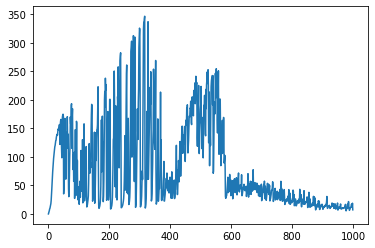

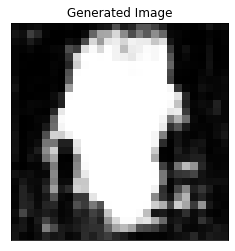

Iteration [1001/10000]......0.113(s) gen: -206.50800 - critic_fake: 207.52815 - critic_real: 215.40957 - neg_critic: 7.88143
Iteration [1002/10000]......0.117(s) gen: -202.31268 - critic_fake: 202.98858 - critic_real: 213.06077 - neg_critic: 10.07218
Iteration [1003/10000]......0.119(s) gen: -202.37427 - critic_fake: 199.35582 - critic_real: 212.03668 - neg_critic: 12.68086
Iteration [1004/10000]......0.120(s) gen: -200.43469 - critic_fake: 201.61621 - critic_real: 211.85497 - neg_critic: 10.23876
Iteration [1005/10000]......0.122(s) gen: -200.22687 - critic_fake: 201.39198 - critic_real: 212.45781 - neg_critic: 11.06584
Iteration [1006/10000]......0.123(s) gen: -202.12198 - critic_fake: 199.24306 - critic_real: 214.15008 - neg_critic: 14.90702
Iteration [1007/10000]......0.124(s) gen: -203.73694 - critic_fake: 201.63403 - critic_real: 214.90792 - neg_critic: 13.27389
Iteration [1008/10000]......0.122(s) gen: -203.69943 - critic_fake: 200.63330 - critic_real: 215.39980 - neg_critic: 14

Iteration [1066/10000]......0.115(s) gen: -203.10233 - critic_fake: 203.43720 - critic_real: 214.58593 - neg_critic: 11.14872
Iteration [1067/10000]......0.115(s) gen: -203.52446 - critic_fake: 203.85747 - critic_real: 215.38309 - neg_critic: 11.52562
Iteration [1068/10000]......0.115(s) gen: -204.59886 - critic_fake: 202.11792 - critic_real: 215.94230 - neg_critic: 13.82438
Iteration [1069/10000]......0.116(s) gen: -207.26100 - critic_fake: 201.36862 - critic_real: 216.17685 - neg_critic: 14.80823
Iteration [1070/10000]......0.115(s) gen: -210.52034 - critic_fake: 201.12066 - critic_real: 217.72473 - neg_critic: 16.60406
Iteration [1071/10000]......0.116(s) gen: -210.42737 - critic_fake: 210.58888 - critic_real: 217.65805 - neg_critic: 7.06917
Iteration [1072/10000]......0.116(s) gen: -208.30681 - critic_fake: 209.65717 - critic_real: 216.19924 - neg_critic: 6.54207
Iteration [1073/10000]......0.117(s) gen: -205.30966 - critic_fake: 207.40607 - critic_real: 214.97491 - neg_critic: 7.5

Iteration [1131/10000]......0.115(s) gen: -210.40634 - critic_fake: 209.48428 - critic_real: 217.67948 - neg_critic: 8.19519
Iteration [1132/10000]......0.115(s) gen: -208.24495 - critic_fake: 209.18811 - critic_real: 216.89707 - neg_critic: 7.70895
Iteration [1133/10000]......0.116(s) gen: -207.07555 - critic_fake: 207.51400 - critic_real: 215.81010 - neg_critic: 8.29609
Iteration [1134/10000]......0.115(s) gen: -206.22173 - critic_fake: 206.36411 - critic_real: 215.31405 - neg_critic: 8.94994
Iteration [1135/10000]......0.116(s) gen: -205.86716 - critic_fake: 205.94253 - critic_real: 215.02979 - neg_critic: 9.08726
Iteration [1136/10000]......0.115(s) gen: -204.56537 - critic_fake: 204.32609 - critic_real: 215.03759 - neg_critic: 10.71151
Iteration [1137/10000]......0.114(s) gen: -205.80530 - critic_fake: 204.11528 - critic_real: 215.14564 - neg_critic: 11.03036
Iteration [1138/10000]......0.115(s) gen: -206.26445 - critic_fake: 205.17013 - critic_real: 215.90173 - neg_critic: 10.731

Iteration [1197/10000]......0.115(s) gen: -201.59705 - critic_fake: 206.45431 - critic_real: 220.39310 - neg_critic: 13.93879
Iteration [1198/10000]......0.117(s) gen: -215.78445 - critic_fake: 210.17842 - critic_real: 222.02014 - neg_critic: 11.84172
Iteration [1199/10000]......0.116(s) gen: -210.49741 - critic_fake: 213.90664 - critic_real: 220.99105 - neg_critic: 7.08441
Iteration [1200/10000]......0.116(s) gen: -208.56351 - critic_fake: 209.12237 - critic_real: 218.31532 - neg_critic: 9.19295
Iteration [1201/10000]......0.114(s) gen: -207.79047 - critic_fake: 207.90816 - critic_real: 217.85406 - neg_critic: 9.94590
Iteration [1202/10000]......0.114(s) gen: -207.07867 - critic_fake: 206.90619 - critic_real: 218.75907 - neg_critic: 11.85288
Iteration [1203/10000]......0.116(s) gen: -211.49672 - critic_fake: 208.39015 - critic_real: 219.49467 - neg_critic: 11.10452
Iteration [1204/10000]......0.120(s) gen: -208.97296 - critic_fake: 209.76472 - critic_real: 220.48968 - neg_critic: 10.7

Iteration [1262/10000]......0.116(s) gen: -212.50696 - critic_fake: 208.92410 - critic_real: 222.96736 - neg_critic: 14.04326
Iteration [1263/10000]......0.118(s) gen: -211.60318 - critic_fake: 209.51067 - critic_real: 222.46393 - neg_critic: 12.95326
Iteration [1264/10000]......0.118(s) gen: -208.41643 - critic_fake: 209.71666 - critic_real: 220.12646 - neg_critic: 10.40981
Iteration [1265/10000]......0.118(s) gen: -211.42848 - critic_fake: 206.61532 - critic_real: 219.19581 - neg_critic: 12.58049
Iteration [1266/10000]......0.118(s) gen: -209.55161 - critic_fake: 210.52585 - critic_real: 220.96474 - neg_critic: 10.43889
Iteration [1267/10000]......0.117(s) gen: -193.93893 - critic_fake: 206.85709 - critic_real: 221.51691 - neg_critic: 14.65981
Iteration [1268/10000]......0.117(s) gen: -217.69809 - critic_fake: 207.78710 - critic_real: 222.80842 - neg_critic: 15.02132
Iteration [1269/10000]......0.117(s) gen: -214.73657 - critic_fake: 216.53956 - critic_real: 222.90758 - neg_critic: 6

Iteration [1327/10000]......0.118(s) gen: -210.74626 - critic_fake: 210.00624 - critic_real: 222.51055 - neg_critic: 12.50431
Iteration [1328/10000]......0.119(s) gen: -209.51747 - critic_fake: 211.26953 - critic_real: 222.70809 - neg_critic: 11.43856
Iteration [1329/10000]......0.117(s) gen: -215.06155 - critic_fake: 211.27553 - critic_real: 222.43402 - neg_critic: 11.15849
Iteration [1330/10000]......0.119(s) gen: -211.13733 - critic_fake: 213.32728 - critic_real: 222.10076 - neg_critic: 8.77348
Iteration [1331/10000]......0.117(s) gen: -209.64676 - critic_fake: 210.28522 - critic_real: 220.88279 - neg_critic: 10.59757
Iteration [1332/10000]......0.122(s) gen: -209.87154 - critic_fake: 210.77192 - critic_real: 221.12989 - neg_critic: 10.35797
Iteration [1333/10000]......0.120(s) gen: -211.28177 - critic_fake: 211.51638 - critic_real: 221.52081 - neg_critic: 10.00443
Iteration [1334/10000]......0.121(s) gen: -211.27643 - critic_fake: 211.06302 - critic_real: 222.29529 - neg_critic: 11

Iteration [1392/10000]......0.119(s) gen: -214.36801 - critic_fake: 208.80629 - critic_real: 222.78165 - neg_critic: 13.97536
Iteration [1393/10000]......0.124(s) gen: -215.78604 - critic_fake: 212.80195 - critic_real: 224.15407 - neg_critic: 11.35212
Iteration [1394/10000]......0.117(s) gen: -209.54352 - critic_fake: 213.88683 - critic_real: 221.60910 - neg_critic: 7.72227
Iteration [1395/10000]......0.118(s) gen: -209.68839 - critic_fake: 208.77639 - critic_real: 219.19855 - neg_critic: 10.42216
Iteration [1396/10000]......0.119(s) gen: -211.15964 - critic_fake: 209.67406 - critic_real: 220.29318 - neg_critic: 10.61912
Iteration [1397/10000]......0.118(s) gen: -208.86102 - critic_fake: 210.35006 - critic_real: 221.76807 - neg_critic: 11.41800
Iteration [1398/10000]......0.117(s) gen: -212.41537 - critic_fake: 210.84687 - critic_real: 221.48276 - neg_critic: 10.63589
Iteration [1399/10000]......0.119(s) gen: -208.52817 - critic_fake: 211.50479 - critic_real: 220.98281 - neg_critic: 9.

Iteration [1457/10000]......0.116(s) gen: -206.68640 - critic_fake: 210.42277 - critic_real: 224.22607 - neg_critic: 13.80329
Iteration [1458/10000]......0.117(s) gen: -215.23868 - critic_fake: 213.23238 - critic_real: 223.92920 - neg_critic: 10.69682
Iteration [1459/10000]......0.117(s) gen: -211.72974 - critic_fake: 214.42485 - critic_real: 221.91787 - neg_critic: 7.49302
Iteration [1460/10000]......0.118(s) gen: -210.53442 - critic_fake: 211.51860 - critic_real: 220.18416 - neg_critic: 8.66556
Iteration [1461/10000]......0.118(s) gen: -210.50272 - critic_fake: 210.78017 - critic_real: 220.68621 - neg_critic: 9.90604
Iteration [1462/10000]......0.119(s) gen: -209.45578 - critic_fake: 210.19542 - critic_real: 220.02142 - neg_critic: 9.82600
Iteration [1463/10000]......0.119(s) gen: -209.60156 - critic_fake: 209.84333 - critic_real: 220.15902 - neg_critic: 10.31569
Iteration [1464/10000]......0.120(s) gen: -211.64789 - critic_fake: 210.29289 - critic_real: 221.84322 - neg_critic: 11.55

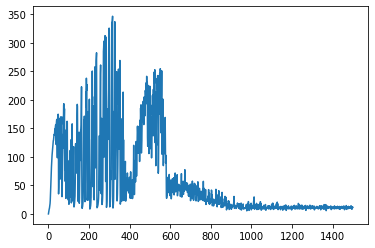

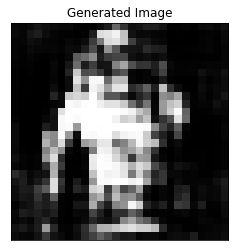

Iteration [1501/10000]......0.118(s) gen: -210.98511 - critic_fake: 211.13371 - critic_real: 223.32435 - neg_critic: 12.19064
Iteration [1502/10000]......0.115(s) gen: -210.94075 - critic_fake: 213.13168 - critic_real: 223.75723 - neg_critic: 10.62555
Iteration [1503/10000]......0.116(s) gen: -208.85445 - critic_fake: 210.39521 - critic_real: 222.60728 - neg_critic: 12.21207
Iteration [1504/10000]......0.114(s) gen: -211.90857 - critic_fake: 211.67750 - critic_real: 223.37526 - neg_critic: 11.69775
Iteration [1505/10000]......0.115(s) gen: -211.56790 - critic_fake: 210.13604 - critic_real: 221.47906 - neg_critic: 11.34302
Iteration [1506/10000]......0.115(s) gen: -212.18225 - critic_fake: 211.56151 - critic_real: 221.96351 - neg_critic: 10.40200
Iteration [1507/10000]......0.117(s) gen: -211.16187 - critic_fake: 210.68493 - critic_real: 221.77178 - neg_critic: 11.08685
Iteration [1508/10000]......0.116(s) gen: -212.44705 - critic_fake: 210.34785 - critic_real: 222.99328 - neg_critic: 1

Iteration [1566/10000]......0.116(s) gen: -208.35950 - critic_fake: 211.77751 - critic_real: 221.32198 - neg_critic: 9.54447
Iteration [1567/10000]......0.116(s) gen: -206.85876 - critic_fake: 208.82603 - critic_real: 220.03810 - neg_critic: 11.21207
Iteration [1568/10000]......0.115(s) gen: -208.99127 - critic_fake: 209.89087 - critic_real: 221.59798 - neg_critic: 11.70711
Iteration [1569/10000]......0.115(s) gen: -214.95053 - critic_fake: 209.13192 - critic_real: 222.27588 - neg_critic: 13.14396
Iteration [1570/10000]......0.118(s) gen: -209.03473 - critic_fake: 213.33554 - critic_real: 223.17711 - neg_critic: 9.84156
Iteration [1571/10000]......0.118(s) gen: -211.44897 - critic_fake: 210.47414 - critic_real: 222.58302 - neg_critic: 12.10887
Iteration [1572/10000]......0.118(s) gen: -209.57686 - critic_fake: 210.68408 - critic_real: 222.34557 - neg_critic: 11.66149
Iteration [1573/10000]......0.116(s) gen: -213.88712 - critic_fake: 210.87063 - critic_real: 221.76557 - neg_critic: 10.

Iteration [1631/10000]......0.116(s) gen: -210.31650 - critic_fake: 214.18729 - critic_real: 223.82747 - neg_critic: 9.64017
Iteration [1632/10000]......0.118(s) gen: -209.25467 - critic_fake: 211.40274 - critic_real: 223.69515 - neg_critic: 12.29242
Iteration [1633/10000]......0.119(s) gen: -212.55829 - critic_fake: 209.66378 - critic_real: 223.63463 - neg_critic: 13.97085
Iteration [1634/10000]......0.117(s) gen: -210.05550 - critic_fake: 210.76938 - critic_real: 223.85694 - neg_critic: 13.08756
Iteration [1635/10000]......0.118(s) gen: -211.79660 - critic_fake: 211.63971 - critic_real: 223.52137 - neg_critic: 11.88166
Iteration [1636/10000]......0.119(s) gen: -212.67046 - critic_fake: 212.22911 - critic_real: 222.76187 - neg_critic: 10.53275
Iteration [1637/10000]......0.121(s) gen: -211.13651 - critic_fake: 210.48663 - critic_real: 222.77787 - neg_critic: 12.29125
Iteration [1638/10000]......0.120(s) gen: -213.28030 - critic_fake: 208.12216 - critic_real: 224.04981 - neg_critic: 15

Iteration [1696/10000]......0.117(s) gen: -210.61847 - critic_fake: 213.11838 - critic_real: 222.51212 - neg_critic: 9.39374
Iteration [1697/10000]......0.117(s) gen: -210.60416 - critic_fake: 211.16243 - critic_real: 222.89914 - neg_critic: 11.73672
Iteration [1698/10000]......0.116(s) gen: -212.01979 - critic_fake: 212.07996 - critic_real: 222.55656 - neg_critic: 10.47661
Iteration [1699/10000]......0.116(s) gen: -212.86896 - critic_fake: 211.72025 - critic_real: 222.92803 - neg_critic: 11.20778
Iteration [1700/10000]......0.117(s) gen: -211.14850 - critic_fake: 212.83536 - critic_real: 222.67642 - neg_critic: 9.84106
Iteration [1701/10000]......0.118(s) gen: -210.01138 - critic_fake: 211.38281 - critic_real: 223.09464 - neg_critic: 11.71183
Iteration [1702/10000]......0.117(s) gen: -209.51373 - critic_fake: 211.51757 - critic_real: 223.19068 - neg_critic: 11.67311
Iteration [1703/10000]......0.116(s) gen: -213.57707 - critic_fake: 210.27128 - critic_real: 223.64337 - neg_critic: 13.

Iteration [1761/10000]......0.119(s) gen: -213.91357 - critic_fake: 210.73612 - critic_real: 222.08209 - neg_critic: 11.34597
Iteration [1762/10000]......0.116(s) gen: -210.24921 - critic_fake: 213.98829 - critic_real: 223.33805 - neg_critic: 9.34976
Iteration [1763/10000]......0.118(s) gen: -212.32007 - critic_fake: 210.65518 - critic_real: 221.84852 - neg_critic: 11.19333
Iteration [1764/10000]......0.116(s) gen: -213.73441 - critic_fake: 211.70832 - critic_real: 222.80310 - neg_critic: 11.09479
Iteration [1765/10000]......0.118(s) gen: -214.47328 - critic_fake: 211.31280 - critic_real: 222.56611 - neg_critic: 11.25331
Iteration [1766/10000]......0.117(s) gen: -210.24170 - critic_fake: 212.89919 - critic_real: 221.86959 - neg_critic: 8.97040
Iteration [1767/10000]......0.116(s) gen: -211.18544 - critic_fake: 209.53584 - critic_real: 221.16025 - neg_critic: 11.62441
Iteration [1768/10000]......0.116(s) gen: -210.16107 - critic_fake: 209.21764 - critic_real: 222.83002 - neg_critic: 13.

Iteration [1826/10000]......0.115(s) gen: -213.40123 - critic_fake: 213.80167 - critic_real: 223.20129 - neg_critic: 9.39962
Iteration [1827/10000]......0.115(s) gen: -212.75162 - critic_fake: 212.37492 - critic_real: 223.22686 - neg_critic: 10.85194
Iteration [1828/10000]......0.116(s) gen: -212.46346 - critic_fake: 211.99612 - critic_real: 223.77240 - neg_critic: 11.77628
Iteration [1829/10000]......0.117(s) gen: -211.84244 - critic_fake: 211.15207 - critic_real: 223.85696 - neg_critic: 12.70489
Iteration [1830/10000]......0.119(s) gen: -211.57639 - critic_fake: 210.59534 - critic_real: 223.25670 - neg_critic: 12.66137
Iteration [1831/10000]......0.120(s) gen: -214.55649 - critic_fake: 212.91216 - critic_real: 223.71227 - neg_critic: 10.80012
Iteration [1832/10000]......0.121(s) gen: -209.82684 - critic_fake: 212.47759 - critic_real: 224.01243 - neg_critic: 11.53484
Iteration [1833/10000]......0.119(s) gen: -213.95325 - critic_fake: 210.88465 - critic_real: 222.61354 - neg_critic: 11

Iteration [1891/10000]......0.118(s) gen: -211.13054 - critic_fake: 211.59936 - critic_real: 223.78477 - neg_critic: 12.18542
Iteration [1892/10000]......0.119(s) gen: -211.90372 - critic_fake: 213.38975 - critic_real: 224.02191 - neg_critic: 10.63216
Iteration [1893/10000]......0.119(s) gen: -209.12335 - critic_fake: 211.20632 - critic_real: 223.13715 - neg_critic: 11.93083
Iteration [1894/10000]......0.117(s) gen: -214.76883 - critic_fake: 212.39775 - critic_real: 223.59940 - neg_critic: 11.20165
Iteration [1895/10000]......0.118(s) gen: -215.56720 - critic_fake: 214.02951 - critic_real: 223.60909 - neg_critic: 9.57957
Iteration [1896/10000]......0.119(s) gen: -214.43045 - critic_fake: 213.51861 - critic_real: 223.55584 - neg_critic: 10.03723
Iteration [1897/10000]......0.119(s) gen: -208.44020 - critic_fake: 213.70402 - critic_real: 224.15106 - neg_critic: 10.44704
Iteration [1898/10000]......0.120(s) gen: -212.40350 - critic_fake: 213.36857 - critic_real: 223.36285 - neg_critic: 9.

Iteration [1956/10000]......0.119(s) gen: -212.10814 - critic_fake: 212.05053 - critic_real: 224.16696 - neg_critic: 12.11643
Iteration [1957/10000]......0.117(s) gen: -217.16728 - critic_fake: 212.54667 - critic_real: 223.94651 - neg_critic: 11.39984
Iteration [1958/10000]......0.117(s) gen: -210.13519 - critic_fake: 215.29884 - critic_real: 224.30772 - neg_critic: 9.00888
Iteration [1959/10000]......0.116(s) gen: -207.20511 - critic_fake: 210.97946 - critic_real: 223.51586 - neg_critic: 12.53640
Iteration [1960/10000]......0.117(s) gen: -214.47955 - critic_fake: 213.47467 - critic_real: 225.71631 - neg_critic: 12.24164
Iteration [1961/10000]......0.118(s) gen: -212.33017 - critic_fake: 214.75147 - critic_real: 224.96843 - neg_critic: 10.21696
Iteration [1962/10000]......0.119(s) gen: -213.35107 - critic_fake: 211.63186 - critic_real: 223.87232 - neg_critic: 12.24046
Iteration [1963/10000]......0.118(s) gen: -215.07416 - critic_fake: 213.63722 - critic_real: 224.73434 - neg_critic: 11

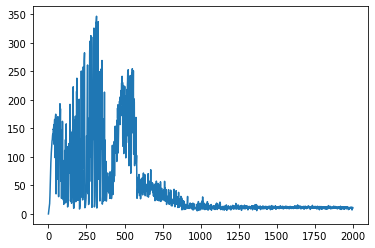

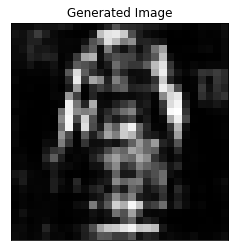

Iteration [2001/10000]......0.119(s) gen: -209.88904 - critic_fake: 211.94867 - critic_real: 223.76263 - neg_critic: 11.81396
Iteration [2002/10000]......0.118(s) gen: -212.72330 - critic_fake: 214.62512 - critic_real: 224.63826 - neg_critic: 10.01314
Iteration [2003/10000]......0.115(s) gen: -214.50803 - critic_fake: 213.27457 - critic_real: 224.05497 - neg_critic: 10.78040
Iteration [2004/10000]......0.116(s) gen: -211.84512 - critic_fake: 213.07802 - critic_real: 225.37694 - neg_critic: 12.29892
Iteration [2005/10000]......0.114(s) gen: -214.85321 - critic_fake: 213.94334 - critic_real: 225.95846 - neg_critic: 12.01512
Iteration [2006/10000]......0.113(s) gen: -215.40770 - critic_fake: 215.51169 - critic_real: 225.10425 - neg_critic: 9.59257
Iteration [2007/10000]......0.114(s) gen: -211.09271 - critic_fake: 213.74983 - critic_real: 224.76608 - neg_critic: 11.01625
Iteration [2008/10000]......0.116(s) gen: -212.79247 - critic_fake: 214.11526 - critic_real: 224.57473 - neg_critic: 10

Iteration [2066/10000]......0.125(s) gen: -216.11493 - critic_fake: 215.33722 - critic_real: 224.30657 - neg_critic: 8.96935
Iteration [2067/10000]......0.133(s) gen: -211.86575 - critic_fake: 214.21950 - critic_real: 224.53140 - neg_critic: 10.31190
Iteration [2068/10000]......0.122(s) gen: -213.85788 - critic_fake: 213.74485 - critic_real: 225.42184 - neg_critic: 11.67699
Iteration [2069/10000]......0.123(s) gen: -214.33426 - critic_fake: 214.45751 - critic_real: 225.36853 - neg_critic: 10.91102
Iteration [2070/10000]......0.121(s) gen: -216.37152 - critic_fake: 213.75193 - critic_real: 225.06762 - neg_critic: 11.31569
Iteration [2071/10000]......0.120(s) gen: -213.79657 - critic_fake: 214.79521 - critic_real: 225.36916 - neg_critic: 10.57395
Iteration [2072/10000]......0.120(s) gen: -216.20033 - critic_fake: 214.70866 - critic_real: 225.87637 - neg_critic: 11.16771
Iteration [2073/10000]......0.118(s) gen: -208.15628 - critic_fake: 213.83421 - critic_real: 225.35671 - neg_critic: 11

Iteration [2132/10000]......0.118(s) gen: -214.88536 - critic_fake: 213.39486 - critic_real: 224.37856 - neg_critic: 10.98370
Iteration [2133/10000]......0.118(s) gen: -213.54781 - critic_fake: 214.12127 - critic_real: 225.24216 - neg_critic: 11.12089
Iteration [2134/10000]......0.117(s) gen: -214.25139 - critic_fake: 212.60023 - critic_real: 224.55934 - neg_critic: 11.95911
Iteration [2135/10000]......0.120(s) gen: -214.15527 - critic_fake: 215.80961 - critic_real: 224.87375 - neg_critic: 9.06414
Iteration [2136/10000]......0.119(s) gen: -213.72118 - critic_fake: 214.17421 - critic_real: 223.70757 - neg_critic: 9.53336
Iteration [2137/10000]......0.118(s) gen: -217.69098 - critic_fake: 213.90508 - critic_real: 224.27948 - neg_critic: 10.37440
Iteration [2138/10000]......0.119(s) gen: -211.93599 - critic_fake: 216.17705 - critic_real: 224.31054 - neg_critic: 8.13349
Iteration [2139/10000]......0.118(s) gen: -213.87573 - critic_fake: 213.38635 - critic_real: 224.26454 - neg_critic: 10.8

Iteration [2197/10000]......0.118(s) gen: -215.45741 - critic_fake: 213.51838 - critic_real: 224.37611 - neg_critic: 10.85774
Iteration [2198/10000]......0.120(s) gen: -213.12189 - critic_fake: 214.87133 - critic_real: 225.21664 - neg_critic: 10.34531
Iteration [2199/10000]......0.121(s) gen: -213.19759 - critic_fake: 214.54614 - critic_real: 225.58663 - neg_critic: 11.04049
Iteration [2200/10000]......0.119(s) gen: -214.74654 - critic_fake: 215.34240 - critic_real: 224.90114 - neg_critic: 9.55874
Iteration [2201/10000]......0.122(s) gen: -215.01250 - critic_fake: 212.69976 - critic_real: 224.98800 - neg_critic: 12.28824
Iteration [2202/10000]......0.120(s) gen: -213.41368 - critic_fake: 215.01391 - critic_real: 224.59042 - neg_critic: 9.57651
Iteration [2203/10000]......0.121(s) gen: -215.53017 - critic_fake: 213.07442 - critic_real: 224.48640 - neg_critic: 11.41198
Iteration [2204/10000]......0.123(s) gen: -211.96898 - critic_fake: 213.70817 - critic_real: 224.51351 - neg_critic: 10.

Iteration [2263/10000]......0.123(s) gen: -213.88235 - critic_fake: 213.21511 - critic_real: 225.32301 - neg_critic: 12.10791
Iteration [2264/10000]......0.123(s) gen: -215.17749 - critic_fake: 215.48877 - critic_real: 226.22329 - neg_critic: 10.73452
Iteration [2265/10000]......0.123(s) gen: -220.73540 - critic_fake: 214.37445 - critic_real: 225.82518 - neg_critic: 11.45072
Iteration [2266/10000]......0.123(s) gen: -217.43121 - critic_fake: 220.14809 - critic_real: 226.77997 - neg_critic: 6.63188
Iteration [2267/10000]......0.124(s) gen: -214.41635 - critic_fake: 216.01609 - critic_real: 223.92901 - neg_critic: 7.91293
Iteration [2268/10000]......0.121(s) gen: -215.72940 - critic_fake: 214.72978 - critic_real: 223.76486 - neg_critic: 9.03509
Iteration [2269/10000]......0.122(s) gen: -216.65953 - critic_fake: 215.81288 - critic_real: 224.56783 - neg_critic: 8.75496
Iteration [2270/10000]......0.120(s) gen: -214.32632 - critic_fake: 215.02531 - critic_real: 225.32523 - neg_critic: 10.29

Iteration [2329/10000]......0.120(s) gen: -213.99081 - critic_fake: 214.50664 - critic_real: 225.21982 - neg_critic: 10.71319
Iteration [2330/10000]......0.120(s) gen: -215.59143 - critic_fake: 215.38090 - critic_real: 225.09305 - neg_critic: 9.71216
Iteration [2331/10000]......0.124(s) gen: -214.31821 - critic_fake: 216.03724 - critic_real: 226.15255 - neg_critic: 10.11531
Iteration [2332/10000]......0.125(s) gen: -213.24663 - critic_fake: 213.47867 - critic_real: 225.79258 - neg_critic: 12.31390
Iteration [2333/10000]......0.123(s) gen: -217.24854 - critic_fake: 213.74942 - critic_real: 226.57320 - neg_critic: 12.82378
Iteration [2334/10000]......0.125(s) gen: -216.40378 - critic_fake: 216.03846 - critic_real: 226.17443 - neg_critic: 10.13597
Iteration [2335/10000]......0.127(s) gen: -216.42059 - critic_fake: 213.73451 - critic_real: 226.02935 - neg_critic: 12.29485
Iteration [2336/10000]......0.123(s) gen: -215.71463 - critic_fake: 215.78036 - critic_real: 225.99665 - neg_critic: 10

Iteration [2395/10000]......0.118(s) gen: -219.21402 - critic_fake: 215.47902 - critic_real: 226.25582 - neg_critic: 10.77680
Iteration [2396/10000]......0.118(s) gen: -215.10822 - critic_fake: 217.54181 - critic_real: 225.62177 - neg_critic: 8.07996
Iteration [2397/10000]......0.118(s) gen: -215.52557 - critic_fake: 215.02498 - critic_real: 225.24099 - neg_critic: 10.21601
Iteration [2398/10000]......0.122(s) gen: -216.34628 - critic_fake: 214.42343 - critic_real: 225.36695 - neg_critic: 10.94352
Iteration [2399/10000]......0.120(s) gen: -216.03574 - critic_fake: 218.01743 - critic_real: 226.01740 - neg_critic: 7.99996
Iteration [2400/10000]......0.121(s) gen: -217.28351 - critic_fake: 215.62411 - critic_real: 225.13844 - neg_critic: 9.51433
Iteration [2401/10000]......0.126(s) gen: -215.37749 - critic_fake: 215.46487 - critic_real: 226.02180 - neg_critic: 10.55693
Iteration [2402/10000]......0.122(s) gen: -216.37149 - critic_fake: 213.92063 - critic_real: 226.26725 - neg_critic: 12.3

Iteration [2461/10000]......0.121(s) gen: -214.71513 - critic_fake: 217.90818 - critic_real: 225.99516 - neg_critic: 8.08698
Iteration [2462/10000]......0.123(s) gen: -215.97247 - critic_fake: 215.34008 - critic_real: 224.43310 - neg_critic: 9.09302
Iteration [2463/10000]......0.122(s) gen: -213.50450 - critic_fake: 214.86119 - critic_real: 225.11626 - neg_critic: 10.25507
Iteration [2464/10000]......0.122(s) gen: -214.01152 - critic_fake: 214.76891 - critic_real: 225.00905 - neg_critic: 10.24015
Iteration [2465/10000]......0.122(s) gen: -214.73767 - critic_fake: 214.65956 - critic_real: 225.12639 - neg_critic: 10.46682
Iteration [2466/10000]......0.125(s) gen: -217.95020 - critic_fake: 214.35300 - critic_real: 225.59532 - neg_critic: 11.24232
Iteration [2467/10000]......0.123(s) gen: -213.57379 - critic_fake: 218.08872 - critic_real: 226.05104 - neg_critic: 7.96232
Iteration [2468/10000]......0.122(s) gen: -215.79184 - critic_fake: 215.43250 - critic_real: 226.20521 - neg_critic: 10.7

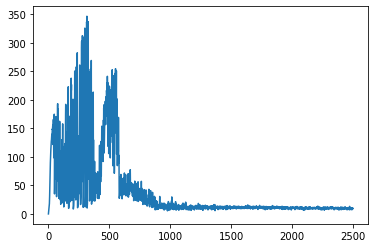

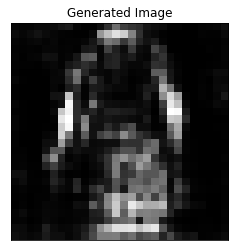

Iteration [2501/10000]......0.117(s) gen: -218.40628 - critic_fake: 216.31522 - critic_real: 225.65912 - neg_critic: 9.34389
Iteration [2502/10000]......0.117(s) gen: -213.72491 - critic_fake: 216.29297 - critic_real: 225.31165 - neg_critic: 9.01868
Iteration [2503/10000]......0.119(s) gen: -217.74063 - critic_fake: 216.00721 - critic_real: 225.19111 - neg_critic: 9.18391
Iteration [2504/10000]......0.114(s) gen: -217.58664 - critic_fake: 215.56783 - critic_real: 226.69671 - neg_critic: 11.12889
Iteration [2505/10000]......0.114(s) gen: -217.07565 - critic_fake: 215.85838 - critic_real: 226.94990 - neg_critic: 11.09152
Iteration [2506/10000]......0.116(s) gen: -216.70358 - critic_fake: 215.79621 - critic_real: 225.90041 - neg_critic: 10.10420
Iteration [2507/10000]......0.118(s) gen: -214.82286 - critic_fake: 216.51663 - critic_real: 226.09492 - neg_critic: 9.57829
Iteration [2508/10000]......0.120(s) gen: -214.62175 - critic_fake: 215.96012 - critic_real: 225.10282 - neg_critic: 9.142

Iteration [2567/10000]......0.120(s) gen: -212.60143 - critic_fake: 216.37593 - critic_real: 225.14462 - neg_critic: 8.76869
Iteration [2568/10000]......0.121(s) gen: -216.08261 - critic_fake: 216.10099 - critic_real: 225.61370 - neg_critic: 9.51271
Iteration [2569/10000]......0.124(s) gen: -216.52524 - critic_fake: 214.58220 - critic_real: 225.57397 - neg_critic: 10.99178
Iteration [2570/10000]......0.125(s) gen: -215.71423 - critic_fake: 216.73458 - critic_real: 226.24792 - neg_critic: 9.51335
Iteration [2571/10000]......0.122(s) gen: -218.05547 - critic_fake: 215.22584 - critic_real: 226.05758 - neg_critic: 10.83174
Iteration [2572/10000]......0.124(s) gen: -220.15814 - critic_fake: 216.80687 - critic_real: 226.99162 - neg_critic: 10.18475
Iteration [2573/10000]......0.120(s) gen: -216.51073 - critic_fake: 217.43394 - critic_real: 226.42049 - neg_critic: 8.98654
Iteration [2574/10000]......0.121(s) gen: -217.21550 - critic_fake: 215.20972 - critic_real: 226.27311 - neg_critic: 11.06

Iteration [2633/10000]......0.118(s) gen: -218.40314 - critic_fake: 216.27809 - critic_real: 226.85965 - neg_critic: 10.58155
Iteration [2634/10000]......0.118(s) gen: -218.38579 - critic_fake: 216.26047 - critic_real: 227.61605 - neg_critic: 11.35558
Iteration [2635/10000]......0.125(s) gen: -219.82825 - critic_fake: 216.95641 - critic_real: 227.38798 - neg_critic: 10.43157
Iteration [2636/10000]......0.119(s) gen: -216.92981 - critic_fake: 219.77938 - critic_real: 227.02144 - neg_critic: 7.24206
Iteration [2637/10000]......0.117(s) gen: -215.80013 - critic_fake: 215.71848 - critic_real: 224.70956 - neg_critic: 8.99108
Iteration [2638/10000]......0.119(s) gen: -214.18440 - critic_fake: 216.37578 - critic_real: 226.51963 - neg_critic: 10.14385
Iteration [2639/10000]......0.121(s) gen: -218.89697 - critic_fake: 218.43300 - critic_real: 226.60119 - neg_critic: 8.16819
Iteration [2640/10000]......0.124(s) gen: -217.56088 - critic_fake: 217.73725 - critic_real: 225.51240 - neg_critic: 7.77

Iteration [2699/10000]......0.125(s) gen: -217.98666 - critic_fake: 218.75561 - critic_real: 225.02458 - neg_critic: 6.26898
Iteration [2700/10000]......0.125(s) gen: -216.46924 - critic_fake: 216.70745 - critic_real: 225.17666 - neg_critic: 8.46921
Iteration [2701/10000]......0.125(s) gen: -217.11612 - critic_fake: 216.38343 - critic_real: 224.91264 - neg_critic: 8.52921
Iteration [2702/10000]......0.122(s) gen: -216.52393 - critic_fake: 217.49751 - critic_real: 226.11181 - neg_critic: 8.61430
Iteration [2703/10000]......0.121(s) gen: -217.16862 - critic_fake: 216.79799 - critic_real: 226.33883 - neg_critic: 9.54084
Iteration [2704/10000]......0.122(s) gen: -218.77173 - critic_fake: 217.41951 - critic_real: 226.62694 - neg_critic: 9.20743
Iteration [2705/10000]......0.121(s) gen: -215.11729 - critic_fake: 217.82062 - critic_real: 227.65161 - neg_critic: 9.83099
Iteration [2706/10000]......0.121(s) gen: -216.86105 - critic_fake: 218.01258 - critic_real: 227.46317 - neg_critic: 9.45058


Iteration [2765/10000]......0.121(s) gen: -215.65175 - critic_fake: 217.70758 - critic_real: 224.97100 - neg_critic: 7.26342
Iteration [2766/10000]......0.120(s) gen: -216.64268 - critic_fake: 216.17861 - critic_real: 224.72924 - neg_critic: 8.55063
Iteration [2767/10000]......0.121(s) gen: -217.07536 - critic_fake: 217.57121 - critic_real: 225.54273 - neg_critic: 7.97152
Iteration [2768/10000]......0.119(s) gen: -216.70364 - critic_fake: 217.36227 - critic_real: 226.54418 - neg_critic: 9.18191
Iteration [2769/10000]......0.119(s) gen: -217.14493 - critic_fake: 218.44818 - critic_real: 227.59581 - neg_critic: 9.14764
Iteration [2770/10000]......0.119(s) gen: -216.62247 - critic_fake: 218.38935 - critic_real: 227.20860 - neg_critic: 8.81925
Iteration [2771/10000]......0.119(s) gen: -215.40399 - critic_fake: 218.57088 - critic_real: 227.41810 - neg_critic: 8.84722
Iteration [2772/10000]......0.119(s) gen: -217.12355 - critic_fake: 217.84756 - critic_real: 227.00602 - neg_critic: 9.15846


Iteration [2831/10000]......0.120(s) gen: -218.04359 - critic_fake: 217.81605 - critic_real: 226.92296 - neg_critic: 9.10691
Iteration [2832/10000]......0.121(s) gen: -218.48177 - critic_fake: 217.21064 - critic_real: 227.45309 - neg_critic: 10.24245
Iteration [2833/10000]......0.122(s) gen: -216.69870 - critic_fake: 218.23690 - critic_real: 227.93649 - neg_critic: 9.69959
Iteration [2834/10000]......0.120(s) gen: -219.67905 - critic_fake: 217.78274 - critic_real: 228.47876 - neg_critic: 10.69603
Iteration [2835/10000]......0.122(s) gen: -220.60776 - critic_fake: 218.98510 - critic_real: 227.55298 - neg_critic: 8.56788
Iteration [2836/10000]......0.123(s) gen: -216.94571 - critic_fake: 219.72577 - critic_real: 227.38429 - neg_critic: 7.65852
Iteration [2837/10000]......0.122(s) gen: -219.90495 - critic_fake: 219.66268 - critic_real: 227.85397 - neg_critic: 8.19129
Iteration [2838/10000]......0.122(s) gen: -220.11421 - critic_fake: 219.71953 - critic_real: 227.69107 - neg_critic: 7.9715

Iteration [2897/10000]......0.120(s) gen: -220.21066 - critic_fake: 218.26320 - critic_real: 228.81907 - neg_critic: 10.55587
Iteration [2898/10000]......0.120(s) gen: -218.91280 - critic_fake: 219.32120 - critic_real: 228.71505 - neg_critic: 9.39385
Iteration [2899/10000]......0.119(s) gen: -219.46423 - critic_fake: 220.73200 - critic_real: 229.89003 - neg_critic: 9.15803
Iteration [2900/10000]......0.118(s) gen: -218.70317 - critic_fake: 220.32175 - critic_real: 228.72743 - neg_critic: 8.40567
Iteration [2901/10000]......0.121(s) gen: -220.04021 - critic_fake: 219.42237 - critic_real: 229.03584 - neg_critic: 9.61347
Iteration [2902/10000]......0.120(s) gen: -219.25253 - critic_fake: 220.10794 - critic_real: 228.70239 - neg_critic: 8.59444
Iteration [2903/10000]......0.121(s) gen: -222.03059 - critic_fake: 219.68073 - critic_real: 229.12549 - neg_critic: 9.44477
Iteration [2904/10000]......0.124(s) gen: -215.80342 - critic_fake: 218.07719 - critic_real: 229.05397 - neg_critic: 10.9767

Iteration [2963/10000]......0.118(s) gen: -218.69241 - critic_fake: 221.19353 - critic_real: 228.42611 - neg_critic: 7.23258
Iteration [2964/10000]......0.118(s) gen: -217.80032 - critic_fake: 218.63918 - critic_real: 227.91082 - neg_critic: 9.27164
Iteration [2965/10000]......0.118(s) gen: -221.20610 - critic_fake: 219.55553 - critic_real: 228.66210 - neg_critic: 9.10657
Iteration [2966/10000]......0.119(s) gen: -219.12662 - critic_fake: 219.59266 - critic_real: 228.52676 - neg_critic: 8.93410
Iteration [2967/10000]......0.120(s) gen: -216.04126 - critic_fake: 218.56922 - critic_real: 228.79894 - neg_critic: 10.22972
Iteration [2968/10000]......0.118(s) gen: -219.32913 - critic_fake: 220.04787 - critic_real: 229.03901 - neg_critic: 8.99114
Iteration [2969/10000]......0.118(s) gen: -218.53558 - critic_fake: 218.20171 - critic_real: 227.88320 - neg_critic: 9.68149
Iteration [2970/10000]......0.120(s) gen: -218.95277 - critic_fake: 217.53520 - critic_real: 228.97260 - neg_critic: 11.4374

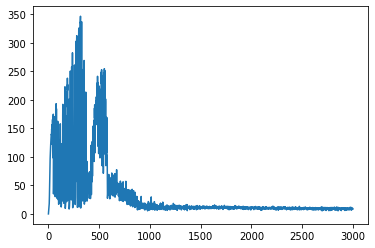

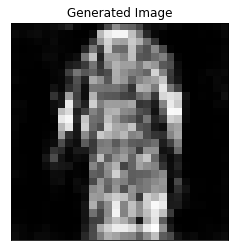

Iteration [3001/10000]......0.129(s) gen: -220.06825 - critic_fake: 220.98568 - critic_real: 229.86395 - neg_critic: 8.87827
Iteration [3002/10000]......0.115(s) gen: -223.52019 - critic_fake: 218.92334 - critic_real: 228.93957 - neg_critic: 10.01623
Iteration [3003/10000]......0.115(s) gen: -221.43527 - critic_fake: 223.25097 - critic_real: 229.69886 - neg_critic: 6.44789
Iteration [3004/10000]......0.119(s) gen: -220.19052 - critic_fake: 219.97433 - critic_real: 228.35993 - neg_critic: 8.38559
Iteration [3005/10000]......0.114(s) gen: -217.86176 - critic_fake: 220.57538 - critic_real: 229.53378 - neg_critic: 8.95840
Iteration [3006/10000]......0.113(s) gen: -221.91092 - critic_fake: 220.32834 - critic_real: 229.25269 - neg_critic: 8.92436
Iteration [3007/10000]......0.113(s) gen: -221.42526 - critic_fake: 220.99227 - critic_real: 229.71339 - neg_critic: 8.72111
Iteration [3008/10000]......0.113(s) gen: -223.36157 - critic_fake: 220.91503 - critic_real: 229.79057 - neg_critic: 8.87554

Iteration [3068/10000]......0.123(s) gen: -218.64288 - critic_fake: 219.45139 - critic_real: 229.60061 - neg_critic: 10.14922
Iteration [3069/10000]......0.120(s) gen: -219.39151 - critic_fake: 220.89597 - critic_real: 229.33337 - neg_critic: 8.43740
Iteration [3070/10000]......0.120(s) gen: -221.56125 - critic_fake: 219.59601 - critic_real: 229.25942 - neg_critic: 9.66341
Iteration [3071/10000]......0.121(s) gen: -222.08856 - critic_fake: 219.41158 - critic_real: 229.44565 - neg_critic: 10.03407
Iteration [3072/10000]......0.119(s) gen: -218.91714 - critic_fake: 221.17111 - critic_real: 230.26709 - neg_critic: 9.09598
Iteration [3073/10000]......0.119(s) gen: -221.70058 - critic_fake: 219.78362 - critic_real: 230.66694 - neg_critic: 10.88332
Iteration [3074/10000]......0.118(s) gen: -222.98918 - critic_fake: 219.63562 - critic_real: 230.39897 - neg_critic: 10.76335
Iteration [3075/10000]......0.118(s) gen: -222.55731 - critic_fake: 223.58242 - critic_real: 230.05505 - neg_critic: 6.47

Iteration [3134/10000]......0.123(s) gen: -220.38721 - critic_fake: 219.75358 - critic_real: 230.48259 - neg_critic: 10.72901
Iteration [3135/10000]......0.122(s) gen: -224.63788 - critic_fake: 221.06237 - critic_real: 231.35102 - neg_critic: 10.28865
Iteration [3136/10000]......0.122(s) gen: -221.58191 - critic_fake: 225.01427 - critic_real: 231.33284 - neg_critic: 6.31857
Iteration [3137/10000]......0.122(s) gen: -223.34511 - critic_fake: 221.97796 - critic_real: 230.78416 - neg_critic: 8.80620
Iteration [3138/10000]......0.119(s) gen: -221.79494 - critic_fake: 222.89501 - critic_real: 230.12981 - neg_critic: 7.23481
Iteration [3139/10000]......0.118(s) gen: -222.11182 - critic_fake: 221.08699 - critic_real: 230.22577 - neg_critic: 9.13878
Iteration [3140/10000]......0.119(s) gen: -218.73373 - critic_fake: 221.67090 - critic_real: 230.73351 - neg_critic: 9.06262
Iteration [3141/10000]......0.119(s) gen: -222.45157 - critic_fake: 222.49455 - critic_real: 231.26092 - neg_critic: 8.7663

Iteration [3200/10000]......0.119(s) gen: -219.43771 - critic_fake: 221.32182 - critic_real: 231.07979 - neg_critic: 9.75796
Iteration [3201/10000]......0.118(s) gen: -219.88867 - critic_fake: 223.06505 - critic_real: 230.57434 - neg_critic: 7.50930
Iteration [3202/10000]......0.119(s) gen: -222.53464 - critic_fake: 220.14772 - critic_real: 230.17455 - neg_critic: 10.02682
Iteration [3203/10000]......0.118(s) gen: -221.08408 - critic_fake: 221.92209 - critic_real: 231.57193 - neg_critic: 9.64984
Iteration [3204/10000]......0.119(s) gen: -224.13844 - critic_fake: 221.61921 - critic_real: 230.87403 - neg_critic: 9.25481
Iteration [3205/10000]......0.120(s) gen: -218.46214 - critic_fake: 222.06718 - critic_real: 230.57364 - neg_critic: 8.50646
Iteration [3206/10000]......0.121(s) gen: -221.02499 - critic_fake: 222.19911 - critic_real: 230.21085 - neg_critic: 8.01173
Iteration [3207/10000]......0.122(s) gen: -222.25247 - critic_fake: 219.61301 - critic_real: 229.74120 - neg_critic: 10.1281

Iteration [3266/10000]......0.114(s) gen: -221.69885 - critic_fake: 221.77750 - critic_real: 232.62387 - neg_critic: 10.84637
Iteration [3267/10000]......0.113(s) gen: -223.89230 - critic_fake: 221.90423 - critic_real: 231.80416 - neg_critic: 9.89992
Iteration [3268/10000]......0.115(s) gen: -223.41821 - critic_fake: 224.86918 - critic_real: 230.33551 - neg_critic: 5.46634
Iteration [3269/10000]......0.115(s) gen: -221.54041 - critic_fake: 222.62575 - critic_real: 229.86626 - neg_critic: 7.24051
Iteration [3270/10000]......0.116(s) gen: -222.74811 - critic_fake: 221.41871 - critic_real: 229.36967 - neg_critic: 7.95096
Iteration [3271/10000]......0.115(s) gen: -221.89120 - critic_fake: 221.42103 - critic_real: 229.86703 - neg_critic: 8.44599
Iteration [3272/10000]......0.116(s) gen: -222.44318 - critic_fake: 221.14045 - critic_real: 230.08499 - neg_critic: 8.94455
Iteration [3273/10000]......0.118(s) gen: -223.79225 - critic_fake: 221.64423 - critic_real: 230.95350 - neg_critic: 9.30927

Iteration [3332/10000]......0.123(s) gen: -224.84164 - critic_fake: 222.67547 - critic_real: 232.58466 - neg_critic: 9.90919
Iteration [3333/10000]......0.124(s) gen: -221.85147 - critic_fake: 223.02002 - critic_real: 231.82331 - neg_critic: 8.80329
Iteration [3334/10000]......0.124(s) gen: -221.54062 - critic_fake: 222.10496 - critic_real: 231.80034 - neg_critic: 9.69538
Iteration [3335/10000]......0.122(s) gen: -224.48193 - critic_fake: 220.94135 - critic_real: 232.33393 - neg_critic: 11.39258
Iteration [3336/10000]......0.122(s) gen: -223.29413 - critic_fake: 224.31417 - critic_real: 232.36351 - neg_critic: 8.04934
Iteration [3337/10000]......0.121(s) gen: -221.84018 - critic_fake: 223.60062 - critic_real: 231.36089 - neg_critic: 7.76027
Iteration [3338/10000]......0.129(s) gen: -224.98206 - critic_fake: 222.38510 - critic_real: 231.80406 - neg_critic: 9.41895
Iteration [3339/10000]......0.119(s) gen: -222.46881 - critic_fake: 223.06732 - critic_real: 232.28233 - neg_critic: 9.21501

Iteration [3398/10000]......0.120(s) gen: -221.91731 - critic_fake: 222.17857 - critic_real: 231.33938 - neg_critic: 9.16081
Iteration [3399/10000]......0.119(s) gen: -223.54257 - critic_fake: 224.43256 - critic_real: 231.91854 - neg_critic: 7.48597
Iteration [3400/10000]......0.121(s) gen: -223.40871 - critic_fake: 222.73077 - critic_real: 232.20818 - neg_critic: 9.47741
Iteration [3401/10000]......0.121(s) gen: -222.96707 - critic_fake: 223.18036 - critic_real: 232.42271 - neg_critic: 9.24234
Iteration [3402/10000]......0.120(s) gen: -225.35562 - critic_fake: 222.34744 - critic_real: 231.92084 - neg_critic: 9.57340
Iteration [3403/10000]......0.121(s) gen: -223.38860 - critic_fake: 223.96438 - critic_real: 232.59616 - neg_critic: 8.63178
Iteration [3404/10000]......0.125(s) gen: -225.06125 - critic_fake: 221.97647 - critic_real: 232.72600 - neg_critic: 10.74953
Iteration [3405/10000]......0.124(s) gen: -224.69244 - critic_fake: 224.81790 - critic_real: 232.78004 - neg_critic: 7.96215

Iteration [3464/10000]......0.118(s) gen: -224.51938 - critic_fake: 223.82210 - critic_real: 232.20845 - neg_critic: 8.38634
Iteration [3465/10000]......0.116(s) gen: -222.27600 - critic_fake: 224.83951 - critic_real: 232.75226 - neg_critic: 7.91275
Iteration [3466/10000]......0.120(s) gen: -226.91257 - critic_fake: 223.60211 - critic_real: 232.88774 - neg_critic: 9.28564
Iteration [3467/10000]......0.118(s) gen: -223.15802 - critic_fake: 224.41789 - critic_real: 232.62572 - neg_critic: 8.20783
Iteration [3468/10000]......0.117(s) gen: -225.07664 - critic_fake: 224.86976 - critic_real: 232.64186 - neg_critic: 7.77210
Iteration [3469/10000]......0.122(s) gen: -223.18692 - critic_fake: 224.36017 - critic_real: 232.77006 - neg_critic: 8.40989
Iteration [3470/10000]......0.119(s) gen: -226.87860 - critic_fake: 224.11048 - critic_real: 233.56761 - neg_critic: 9.45713
Iteration [3471/10000]......0.117(s) gen: -223.78151 - critic_fake: 226.20235 - critic_real: 233.03900 - neg_critic: 6.83665


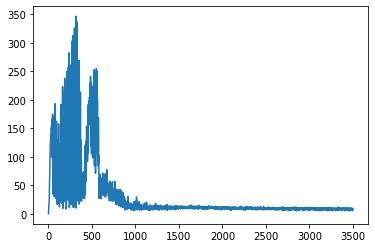

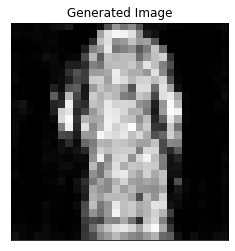

Iteration [3501/10000]......0.122(s) gen: -223.35799 - critic_fake: 225.06143 - critic_real: 232.87518 - neg_critic: 7.81375
Iteration [3502/10000]......0.115(s) gen: -222.97101 - critic_fake: 223.94688 - critic_real: 232.81628 - neg_critic: 8.86940
Iteration [3503/10000]......0.115(s) gen: -226.07138 - critic_fake: 222.79167 - critic_real: 234.00853 - neg_critic: 11.21686
Iteration [3504/10000]......0.120(s) gen: -226.41882 - critic_fake: 225.46439 - critic_real: 233.92664 - neg_critic: 8.46226
Iteration [3505/10000]......0.117(s) gen: -223.43065 - critic_fake: 223.49571 - critic_real: 233.46468 - neg_critic: 9.96897
Iteration [3506/10000]......0.119(s) gen: -220.97902 - critic_fake: 224.36304 - critic_real: 234.12523 - neg_critic: 9.76220
Iteration [3507/10000]......0.118(s) gen: -225.53229 - critic_fake: 225.50432 - critic_real: 234.12971 - neg_critic: 8.62538
Iteration [3508/10000]......0.119(s) gen: -222.71455 - critic_fake: 224.81720 - critic_real: 233.91254 - neg_critic: 9.09534

Iteration [3568/10000]......0.120(s) gen: -225.89720 - critic_fake: 225.09702 - critic_real: 233.54977 - neg_critic: 8.45275
Iteration [3569/10000]......0.122(s) gen: -225.96982 - critic_fake: 225.09080 - critic_real: 234.38690 - neg_critic: 9.29610
Iteration [3570/10000]......0.120(s) gen: -224.94301 - critic_fake: 224.95128 - critic_real: 235.01976 - neg_critic: 10.06849
Iteration [3571/10000]......0.125(s) gen: -225.37238 - critic_fake: 225.94169 - critic_real: 234.58690 - neg_critic: 8.64522
Iteration [3572/10000]......0.126(s) gen: -227.19514 - critic_fake: 225.77219 - critic_real: 233.95254 - neg_critic: 8.18035
Iteration [3573/10000]......0.124(s) gen: -225.58347 - critic_fake: 225.06046 - critic_real: 234.29514 - neg_critic: 9.23469
Iteration [3574/10000]......0.127(s) gen: -228.39268 - critic_fake: 224.88467 - critic_real: 234.41621 - neg_critic: 9.53154
Iteration [3575/10000]......0.125(s) gen: -225.43964 - critic_fake: 227.92444 - critic_real: 233.99872 - neg_critic: 6.07429

Iteration [3634/10000]......0.125(s) gen: -227.77666 - critic_fake: 226.54138 - critic_real: 235.00834 - neg_critic: 8.46696
Iteration [3635/10000]......0.119(s) gen: -224.95926 - critic_fake: 227.62956 - critic_real: 233.87168 - neg_critic: 6.24212
Iteration [3636/10000]......0.123(s) gen: -225.50029 - critic_fake: 225.13084 - critic_real: 233.39778 - neg_critic: 8.26694
Iteration [3637/10000]......0.121(s) gen: -224.28500 - critic_fake: 224.34756 - critic_real: 233.50809 - neg_critic: 9.16053
Iteration [3638/10000]......0.120(s) gen: -226.37486 - critic_fake: 225.57811 - critic_real: 233.74664 - neg_critic: 8.16853
Iteration [3639/10000]......0.122(s) gen: -223.75018 - critic_fake: 225.08580 - critic_real: 234.10233 - neg_critic: 9.01653
Iteration [3640/10000]......0.119(s) gen: -226.05763 - critic_fake: 225.56839 - critic_real: 234.32086 - neg_critic: 8.75247
Iteration [3641/10000]......0.117(s) gen: -224.90567 - critic_fake: 225.80089 - critic_real: 234.12840 - neg_critic: 8.32752


Iteration [3700/10000]......0.120(s) gen: -225.73206 - critic_fake: 225.42269 - critic_real: 235.26743 - neg_critic: 9.84474
Iteration [3701/10000]......0.119(s) gen: -226.52924 - critic_fake: 225.55012 - critic_real: 235.28572 - neg_critic: 9.73560
Iteration [3702/10000]......0.120(s) gen: -229.30891 - critic_fake: 226.56214 - critic_real: 235.10255 - neg_critic: 8.54041
Iteration [3703/10000]......0.121(s) gen: -226.95007 - critic_fake: 228.18131 - critic_real: 234.38182 - neg_critic: 6.20052
Iteration [3704/10000]......0.121(s) gen: -224.21902 - critic_fake: 226.12636 - critic_real: 233.75811 - neg_critic: 7.63174
Iteration [3705/10000]......0.120(s) gen: -228.29514 - critic_fake: 226.27359 - critic_real: 234.09251 - neg_critic: 7.81892
Iteration [3706/10000]......0.120(s) gen: -225.10440 - critic_fake: 226.15070 - critic_real: 234.09579 - neg_critic: 7.94508
Iteration [3707/10000]......0.118(s) gen: -227.51126 - critic_fake: 226.04271 - critic_real: 234.60428 - neg_critic: 8.56157


Iteration [3766/10000]......0.118(s) gen: -222.91945 - critic_fake: 227.12433 - critic_real: 234.67369 - neg_critic: 7.54937
Iteration [3767/10000]......0.117(s) gen: -226.10172 - critic_fake: 226.87389 - critic_real: 234.33276 - neg_critic: 7.45887
Iteration [3768/10000]......0.117(s) gen: -224.52927 - critic_fake: 226.29035 - critic_real: 234.85715 - neg_critic: 8.56680
Iteration [3769/10000]......0.118(s) gen: -225.49651 - critic_fake: 226.11728 - critic_real: 235.18398 - neg_critic: 9.06670
Iteration [3770/10000]......0.119(s) gen: -222.45752 - critic_fake: 224.76907 - critic_real: 235.40211 - neg_critic: 10.63304
Iteration [3771/10000]......0.118(s) gen: -228.93877 - critic_fake: 227.61331 - critic_real: 234.67664 - neg_critic: 7.06333
Iteration [3772/10000]......0.120(s) gen: -226.99464 - critic_fake: 229.28786 - critic_real: 235.40528 - neg_critic: 6.11742
Iteration [3773/10000]......0.118(s) gen: -226.50447 - critic_fake: 226.69876 - critic_real: 234.27509 - neg_critic: 7.57632

Iteration [3832/10000]......0.124(s) gen: -226.21408 - critic_fake: 226.24552 - critic_real: 237.41795 - neg_critic: 11.17243
Iteration [3833/10000]......0.134(s) gen: -230.43332 - critic_fake: 230.07638 - critic_real: 236.43375 - neg_critic: 6.35737
Iteration [3834/10000]......0.122(s) gen: -229.49298 - critic_fake: 229.93382 - critic_real: 235.45067 - neg_critic: 5.51685
Iteration [3835/10000]......0.122(s) gen: -227.58983 - critic_fake: 227.82822 - critic_real: 234.98250 - neg_critic: 7.15429
Iteration [3836/10000]......0.126(s) gen: -228.08548 - critic_fake: 226.45462 - critic_real: 235.01348 - neg_critic: 8.55885
Iteration [3837/10000]......0.129(s) gen: -228.53473 - critic_fake: 226.39276 - critic_real: 235.58040 - neg_critic: 9.18765
Iteration [3838/10000]......0.122(s) gen: -227.70714 - critic_fake: 229.34573 - critic_real: 236.10542 - neg_critic: 6.75970
Iteration [3839/10000]......0.120(s) gen: -230.49077 - critic_fake: 229.04326 - critic_real: 236.66111 - neg_critic: 7.61785

Iteration [3898/10000]......0.122(s) gen: -228.75128 - critic_fake: 228.45220 - critic_real: 237.63470 - neg_critic: 9.18250
Iteration [3899/10000]......0.122(s) gen: -231.71347 - critic_fake: 228.95666 - critic_real: 237.01436 - neg_critic: 8.05770
Iteration [3900/10000]......0.123(s) gen: -229.02525 - critic_fake: 230.78389 - critic_real: 237.15281 - neg_critic: 6.36892
Iteration [3901/10000]......0.123(s) gen: -227.92741 - critic_fake: 228.44509 - critic_real: 236.39928 - neg_critic: 7.95419
Iteration [3902/10000]......0.124(s) gen: -228.11754 - critic_fake: 227.80458 - critic_real: 236.59750 - neg_critic: 8.79292
Iteration [3903/10000]......0.123(s) gen: -229.22760 - critic_fake: 228.84919 - critic_real: 237.01961 - neg_critic: 8.17042
Iteration [3904/10000]......0.121(s) gen: -227.63611 - critic_fake: 227.81613 - critic_real: 237.26876 - neg_critic: 9.45262
Iteration [3905/10000]......0.122(s) gen: -229.66348 - critic_fake: 229.28391 - critic_real: 237.63868 - neg_critic: 8.35478


Iteration [3964/10000]......0.122(s) gen: -229.20059 - critic_fake: 226.75024 - critic_real: 236.61426 - neg_critic: 9.86402
Iteration [3965/10000]......0.119(s) gen: -228.97781 - critic_fake: 229.18686 - critic_real: 237.13783 - neg_critic: 7.95098
Iteration [3966/10000]......0.121(s) gen: -230.83636 - critic_fake: 228.31812 - critic_real: 237.58187 - neg_critic: 9.26375
Iteration [3967/10000]......0.120(s) gen: -227.11514 - critic_fake: 229.95297 - critic_real: 237.67992 - neg_critic: 7.72694
Iteration [3968/10000]......0.121(s) gen: -231.02126 - critic_fake: 228.18746 - critic_real: 237.58583 - neg_critic: 9.39837
Iteration [3969/10000]......0.121(s) gen: -230.36096 - critic_fake: 231.12859 - critic_real: 237.41350 - neg_critic: 6.28491
Iteration [3970/10000]......0.123(s) gen: -228.36313 - critic_fake: 228.92567 - critic_real: 236.85823 - neg_critic: 7.93256
Iteration [3971/10000]......0.122(s) gen: -230.68042 - critic_fake: 229.45476 - critic_real: 237.51446 - neg_critic: 8.05970


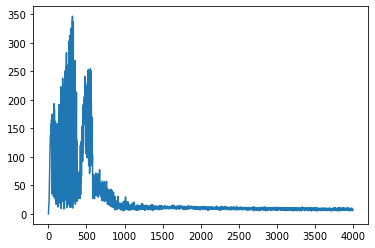

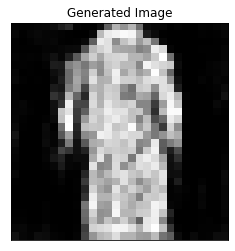

Iteration [4001/10000]......0.137(s) gen: -227.81085 - critic_fake: 229.37169 - critic_real: 237.46218 - neg_critic: 8.09049
Iteration [4002/10000]......0.115(s) gen: -229.67624 - critic_fake: 227.91056 - critic_real: 237.17015 - neg_critic: 9.25959
Iteration [4003/10000]......0.115(s) gen: -230.59619 - critic_fake: 228.78649 - critic_real: 238.43690 - neg_critic: 9.65042
Iteration [4004/10000]......0.113(s) gen: -231.03587 - critic_fake: 230.40567 - critic_real: 238.46355 - neg_critic: 8.05788
Iteration [4005/10000]......0.113(s) gen: -229.25041 - critic_fake: 229.95431 - critic_real: 237.37848 - neg_critic: 7.42417
Iteration [4006/10000]......0.113(s) gen: -228.74307 - critic_fake: 230.62627 - critic_real: 238.02967 - neg_critic: 7.40340
Iteration [4007/10000]......0.114(s) gen: -227.78458 - critic_fake: 228.33368 - critic_real: 238.26064 - neg_critic: 9.92696
Iteration [4008/10000]......0.114(s) gen: -233.52225 - critic_fake: 229.61710 - critic_real: 238.59202 - neg_critic: 8.97493


Iteration [4068/10000]......0.123(s) gen: -229.25111 - critic_fake: 230.26908 - critic_real: 238.61488 - neg_critic: 8.34580
Iteration [4069/10000]......0.123(s) gen: -232.64093 - critic_fake: 230.88644 - critic_real: 239.03311 - neg_critic: 8.14667
Iteration [4070/10000]......0.122(s) gen: -230.75504 - critic_fake: 231.52827 - critic_real: 238.78996 - neg_critic: 7.26169
Iteration [4071/10000]......0.122(s) gen: -229.43991 - critic_fake: 229.86488 - critic_real: 237.94640 - neg_critic: 8.08152
Iteration [4072/10000]......0.120(s) gen: -231.95810 - critic_fake: 229.97338 - critic_real: 237.67159 - neg_critic: 7.69821
Iteration [4073/10000]......0.122(s) gen: -225.91542 - critic_fake: 230.34939 - critic_real: 238.58162 - neg_critic: 8.23222
Iteration [4074/10000]......0.120(s) gen: -230.50165 - critic_fake: 229.62038 - critic_real: 237.95139 - neg_critic: 8.33101
Iteration [4075/10000]......0.119(s) gen: -227.68396 - critic_fake: 228.70670 - critic_real: 238.09146 - neg_critic: 9.38476


Iteration [4134/10000]......0.122(s) gen: -229.34424 - critic_fake: 230.60742 - critic_real: 238.36242 - neg_critic: 7.75500
Iteration [4135/10000]......0.120(s) gen: -231.56183 - critic_fake: 232.42796 - critic_real: 239.53241 - neg_critic: 7.10445
Iteration [4136/10000]......0.121(s) gen: -228.99402 - critic_fake: 229.94327 - critic_real: 239.02639 - neg_critic: 9.08312
Iteration [4137/10000]......0.120(s) gen: -230.75453 - critic_fake: 228.74814 - critic_real: 238.79773 - neg_critic: 10.04959
Iteration [4138/10000]......0.120(s) gen: -232.69406 - critic_fake: 229.71449 - critic_real: 239.38583 - neg_critic: 9.67134
Iteration [4139/10000]......0.120(s) gen: -229.85629 - critic_fake: 231.78048 - critic_real: 238.15562 - neg_critic: 6.37513
Iteration [4140/10000]......0.119(s) gen: -232.60413 - critic_fake: 229.72640 - critic_real: 239.01931 - neg_critic: 9.29291
Iteration [4141/10000]......0.120(s) gen: -231.31024 - critic_fake: 233.01265 - critic_real: 238.44960 - neg_critic: 5.43695

Iteration [4200/10000]......0.121(s) gen: -231.36356 - critic_fake: 232.07157 - critic_real: 239.20112 - neg_critic: 7.12956
Iteration [4201/10000]......0.121(s) gen: -229.15594 - critic_fake: 230.95109 - critic_real: 238.87256 - neg_critic: 7.92147
Iteration [4202/10000]......0.119(s) gen: -232.38745 - critic_fake: 230.78672 - critic_real: 239.15627 - neg_critic: 8.36955
Iteration [4203/10000]......0.121(s) gen: -230.15207 - critic_fake: 231.43312 - critic_real: 239.40112 - neg_critic: 7.96800
Iteration [4204/10000]......0.121(s) gen: -233.56795 - critic_fake: 229.29933 - critic_real: 238.81549 - neg_critic: 9.51616
Iteration [4205/10000]......0.121(s) gen: -232.62244 - critic_fake: 233.42611 - critic_real: 238.28705 - neg_critic: 4.86093
Iteration [4206/10000]......0.122(s) gen: -229.49426 - critic_fake: 231.47982 - critic_real: 237.87396 - neg_critic: 6.39414
Iteration [4207/10000]......0.121(s) gen: -229.93080 - critic_fake: 229.06930 - critic_real: 237.40571 - neg_critic: 8.33642


Iteration [4266/10000]......0.118(s) gen: -231.77930 - critic_fake: 231.65603 - critic_real: 239.99105 - neg_critic: 8.33502
Iteration [4267/10000]......0.119(s) gen: -233.51971 - critic_fake: 231.20062 - critic_real: 239.04200 - neg_critic: 7.84138
Iteration [4268/10000]......0.120(s) gen: -229.86678 - critic_fake: 231.18026 - critic_real: 239.54010 - neg_critic: 8.35984
Iteration [4269/10000]......0.120(s) gen: -230.88545 - critic_fake: 229.55037 - critic_real: 238.91789 - neg_critic: 9.36752
Iteration [4270/10000]......0.121(s) gen: -230.97572 - critic_fake: 230.22236 - critic_real: 238.68489 - neg_critic: 8.46253
Iteration [4271/10000]......0.122(s) gen: -230.96542 - critic_fake: 230.68605 - critic_real: 238.62951 - neg_critic: 7.94346
Iteration [4272/10000]......0.120(s) gen: -229.16818 - critic_fake: 229.58663 - critic_real: 238.88407 - neg_critic: 9.29744
Iteration [4273/10000]......0.121(s) gen: -230.74284 - critic_fake: 229.50923 - critic_real: 239.57528 - neg_critic: 10.06605

Iteration [4332/10000]......0.121(s) gen: -229.10654 - critic_fake: 231.08764 - critic_real: 239.88553 - neg_critic: 8.79789
Iteration [4333/10000]......0.120(s) gen: -233.49106 - critic_fake: 231.78897 - critic_real: 240.37048 - neg_critic: 8.58151
Iteration [4334/10000]......0.121(s) gen: -231.64691 - critic_fake: 232.62614 - critic_real: 240.16356 - neg_critic: 7.53741
Iteration [4335/10000]......0.123(s) gen: -231.68225 - critic_fake: 232.02804 - critic_real: 239.43269 - neg_critic: 7.40465
Iteration [4336/10000]......0.122(s) gen: -231.67754 - critic_fake: 229.18802 - critic_real: 239.69825 - neg_critic: 10.51023
Iteration [4337/10000]......0.122(s) gen: -232.51913 - critic_fake: 233.25493 - critic_real: 239.46804 - neg_critic: 6.21310
Iteration [4338/10000]......0.122(s) gen: -232.65694 - critic_fake: 231.88859 - critic_real: 239.84344 - neg_critic: 7.95485
Iteration [4339/10000]......0.123(s) gen: -231.05412 - critic_fake: 231.52992 - critic_real: 239.71791 - neg_critic: 8.18799

Iteration [4398/10000]......0.118(s) gen: -231.77098 - critic_fake: 233.33249 - critic_real: 240.46941 - neg_critic: 7.13692
Iteration [4399/10000]......0.118(s) gen: -235.45842 - critic_fake: 231.94973 - critic_real: 240.14423 - neg_critic: 8.19450
Iteration [4400/10000]......0.118(s) gen: -234.98535 - critic_fake: 235.10836 - critic_real: 240.60356 - neg_critic: 5.49520
Iteration [4401/10000]......0.117(s) gen: -232.06926 - critic_fake: 232.90438 - critic_real: 240.23486 - neg_critic: 7.33047
Iteration [4402/10000]......0.118(s) gen: -234.15579 - critic_fake: 230.81921 - critic_real: 239.51242 - neg_critic: 8.69320
Iteration [4403/10000]......0.118(s) gen: -234.57758 - critic_fake: 234.76542 - critic_real: 239.99927 - neg_critic: 5.23386
Iteration [4404/10000]......0.119(s) gen: -231.83075 - critic_fake: 233.13308 - critic_real: 239.04901 - neg_critic: 5.91593
Iteration [4405/10000]......0.119(s) gen: -229.85007 - critic_fake: 231.43654 - critic_real: 239.19123 - neg_critic: 7.75469


Iteration [4464/10000]......0.122(s) gen: -233.59677 - critic_fake: 233.65300 - critic_real: 241.44527 - neg_critic: 7.79228
Iteration [4465/10000]......0.122(s) gen: -232.95618 - critic_fake: 233.14247 - critic_real: 240.91755 - neg_critic: 7.77508
Iteration [4466/10000]......0.123(s) gen: -228.99179 - critic_fake: 232.62622 - critic_real: 240.75768 - neg_critic: 8.13146
Iteration [4467/10000]......0.119(s) gen: -233.57034 - critic_fake: 232.87667 - critic_real: 240.84177 - neg_critic: 7.96510
Iteration [4468/10000]......0.118(s) gen: -233.12839 - critic_fake: 232.17432 - critic_real: 240.69840 - neg_critic: 8.52408
Iteration [4469/10000]......0.119(s) gen: -226.57379 - critic_fake: 232.70061 - critic_real: 240.76737 - neg_critic: 8.06676
Iteration [4470/10000]......0.120(s) gen: -235.13098 - critic_fake: 233.05395 - critic_real: 240.17498 - neg_critic: 7.12103
Iteration [4471/10000]......0.120(s) gen: -232.05298 - critic_fake: 234.26286 - critic_real: 240.81856 - neg_critic: 6.55570


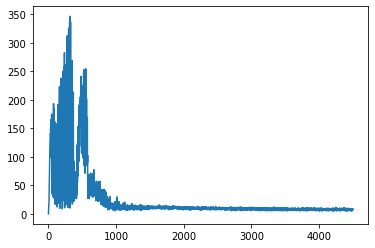

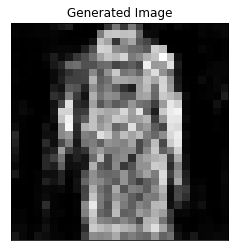

Iteration [4501/10000]......0.117(s) gen: -234.69485 - critic_fake: 233.66629 - critic_real: 241.56088 - neg_critic: 7.89460
Iteration [4502/10000]......0.115(s) gen: -234.15471 - critic_fake: 232.68699 - critic_real: 241.67571 - neg_critic: 8.98872
Iteration [4503/10000]......0.115(s) gen: -232.34000 - critic_fake: 233.64543 - critic_real: 241.76206 - neg_critic: 8.11664
Iteration [4504/10000]......0.115(s) gen: -234.90796 - critic_fake: 234.05633 - critic_real: 241.32535 - neg_critic: 7.26903
Iteration [4505/10000]......0.116(s) gen: -233.50793 - critic_fake: 233.23417 - critic_real: 241.60746 - neg_critic: 8.37329
Iteration [4506/10000]......0.115(s) gen: -234.40036 - critic_fake: 231.52786 - critic_real: 240.83297 - neg_critic: 9.30511
Iteration [4507/10000]......0.114(s) gen: -232.79730 - critic_fake: 234.00284 - critic_real: 240.94265 - neg_critic: 6.93980
Iteration [4508/10000]......0.115(s) gen: -233.03781 - critic_fake: 233.24575 - critic_real: 241.20098 - neg_critic: 7.95522


Iteration [4567/10000]......0.118(s) gen: -235.40407 - critic_fake: 235.72262 - critic_real: 241.78187 - neg_critic: 6.05926
Iteration [4568/10000]......0.117(s) gen: -230.59323 - critic_fake: 233.30332 - critic_real: 242.08517 - neg_critic: 8.78185
Iteration [4569/10000]......0.118(s) gen: -234.71252 - critic_fake: 233.49538 - critic_real: 241.77997 - neg_critic: 8.28459
Iteration [4570/10000]......0.119(s) gen: -233.25497 - critic_fake: 233.71909 - critic_real: 242.13151 - neg_critic: 8.41242
Iteration [4571/10000]......0.120(s) gen: -233.89151 - critic_fake: 233.83591 - critic_real: 242.43159 - neg_critic: 8.59568
Iteration [4572/10000]......0.119(s) gen: -235.26083 - critic_fake: 235.45030 - critic_real: 242.51064 - neg_critic: 7.06034
Iteration [4573/10000]......0.122(s) gen: -233.00366 - critic_fake: 234.03506 - critic_real: 242.10246 - neg_critic: 8.06740
Iteration [4574/10000]......0.125(s) gen: -234.50177 - critic_fake: 234.02667 - critic_real: 241.76177 - neg_critic: 7.73510


Iteration [4633/10000]......0.121(s) gen: -236.14240 - critic_fake: 234.28052 - critic_real: 242.03317 - neg_critic: 7.75265
Iteration [4634/10000]......0.124(s) gen: -232.26425 - critic_fake: 235.78183 - critic_real: 242.80737 - neg_critic: 7.02555
Iteration [4635/10000]......0.125(s) gen: -235.51285 - critic_fake: 233.94265 - critic_real: 241.95929 - neg_critic: 8.01664
Iteration [4636/10000]......0.124(s) gen: -234.66440 - critic_fake: 234.51085 - critic_real: 242.38794 - neg_critic: 7.87709
Iteration [4637/10000]......0.124(s) gen: -233.73225 - critic_fake: 233.92591 - critic_real: 241.90123 - neg_critic: 7.97532
Iteration [4638/10000]......0.124(s) gen: -235.86211 - critic_fake: 233.16840 - critic_real: 241.55103 - neg_critic: 8.38263
Iteration [4639/10000]......0.128(s) gen: -236.47601 - critic_fake: 235.75547 - critic_real: 242.29050 - neg_critic: 6.53503
Iteration [4640/10000]......0.125(s) gen: -233.54431 - critic_fake: 235.11551 - critic_real: 242.53724 - neg_critic: 7.42173


Iteration [4699/10000]......0.120(s) gen: -237.51901 - critic_fake: 232.84782 - critic_real: 242.11418 - neg_critic: 9.26636
Iteration [4700/10000]......0.121(s) gen: -236.25052 - critic_fake: 238.28607 - critic_real: 243.87648 - neg_critic: 5.59041
Iteration [4701/10000]......0.122(s) gen: -233.83073 - critic_fake: 235.31641 - critic_real: 242.63544 - neg_critic: 7.31903
Iteration [4702/10000]......0.122(s) gen: -234.97137 - critic_fake: 234.86727 - critic_real: 243.38214 - neg_critic: 8.51487
Iteration [4703/10000]......0.121(s) gen: -237.40414 - critic_fake: 233.73206 - critic_real: 242.61853 - neg_critic: 8.88647
Iteration [4704/10000]......0.122(s) gen: -237.00858 - critic_fake: 237.20504 - critic_real: 241.62989 - neg_critic: 4.42485
Iteration [4705/10000]......0.121(s) gen: -235.39636 - critic_fake: 235.98514 - critic_real: 242.07470 - neg_critic: 6.08956
Iteration [4706/10000]......0.121(s) gen: -235.49384 - critic_fake: 234.76017 - critic_real: 242.11094 - neg_critic: 7.35077


Iteration [4765/10000]......0.119(s) gen: -236.53003 - critic_fake: 234.84462 - critic_real: 242.60150 - neg_critic: 7.75688
Iteration [4766/10000]......0.119(s) gen: -236.16922 - critic_fake: 236.15087 - critic_real: 243.55866 - neg_critic: 7.40779
Iteration [4767/10000]......0.118(s) gen: -236.72781 - critic_fake: 235.27672 - critic_real: 243.34953 - neg_critic: 8.07280
Iteration [4768/10000]......0.118(s) gen: -234.16699 - critic_fake: 234.58226 - critic_real: 242.84832 - neg_critic: 8.26606
Iteration [4769/10000]......0.118(s) gen: -231.63986 - critic_fake: 234.49993 - critic_real: 243.18876 - neg_critic: 8.68883
Iteration [4770/10000]......0.120(s) gen: -236.39084 - critic_fake: 236.31091 - critic_real: 242.97770 - neg_critic: 6.66679
Iteration [4771/10000]......0.122(s) gen: -235.56931 - critic_fake: 235.96455 - critic_real: 242.52720 - neg_critic: 6.56266
Iteration [4772/10000]......0.122(s) gen: -235.89462 - critic_fake: 234.97243 - critic_real: 242.71202 - neg_critic: 7.73958


Iteration [4831/10000]......0.120(s) gen: -234.87369 - critic_fake: 236.43253 - critic_real: 243.72617 - neg_critic: 7.29363
Iteration [4832/10000]......0.119(s) gen: -235.13980 - critic_fake: 236.06577 - critic_real: 244.05293 - neg_critic: 7.98715
Iteration [4833/10000]......0.120(s) gen: -229.25076 - critic_fake: 235.43287 - critic_real: 244.07998 - neg_critic: 8.64711
Iteration [4834/10000]......0.122(s) gen: -237.35326 - critic_fake: 236.42789 - critic_real: 242.65513 - neg_critic: 6.22723
Iteration [4835/10000]......0.122(s) gen: -236.22301 - critic_fake: 237.52739 - critic_real: 242.29956 - neg_critic: 4.77218
Iteration [4836/10000]......0.123(s) gen: -235.09427 - critic_fake: 235.32686 - critic_real: 242.48697 - neg_critic: 7.16010
Iteration [4837/10000]......0.125(s) gen: -236.22182 - critic_fake: 235.59228 - critic_real: 243.42739 - neg_critic: 7.83511
Iteration [4838/10000]......0.127(s) gen: -238.39120 - critic_fake: 235.51106 - critic_real: 244.04760 - neg_critic: 8.53654


Iteration [4897/10000]......0.124(s) gen: -237.49571 - critic_fake: 236.66358 - critic_real: 244.65026 - neg_critic: 7.98667
Iteration [4898/10000]......0.123(s) gen: -234.97153 - critic_fake: 236.24801 - critic_real: 244.08258 - neg_critic: 7.83458
Iteration [4899/10000]......0.124(s) gen: -238.86108 - critic_fake: 236.48095 - critic_real: 243.65804 - neg_critic: 7.17709
Iteration [4900/10000]......0.122(s) gen: -236.76772 - critic_fake: 238.02342 - critic_real: 244.68412 - neg_critic: 6.66070
Iteration [4901/10000]......0.119(s) gen: -235.27771 - critic_fake: 235.52501 - critic_real: 244.62043 - neg_critic: 9.09542
Iteration [4902/10000]......0.120(s) gen: -237.65631 - critic_fake: 236.68387 - critic_real: 244.71130 - neg_critic: 8.02744
Iteration [4903/10000]......0.120(s) gen: -236.20769 - critic_fake: 236.72416 - critic_real: 243.99719 - neg_critic: 7.27303
Iteration [4904/10000]......0.120(s) gen: -236.77336 - critic_fake: 235.95033 - critic_real: 243.99607 - neg_critic: 8.04573


Iteration [4963/10000]......0.122(s) gen: -237.73109 - critic_fake: 235.93471 - critic_real: 245.75854 - neg_critic: 9.82384
Iteration [4964/10000]......0.122(s) gen: -238.11192 - critic_fake: 237.27292 - critic_real: 245.67187 - neg_critic: 8.39895
Iteration [4965/10000]......0.120(s) gen: -240.14816 - critic_fake: 237.83123 - critic_real: 245.55628 - neg_critic: 7.72505
Iteration [4966/10000]......0.120(s) gen: -237.06824 - critic_fake: 239.23696 - critic_real: 244.21557 - neg_critic: 4.97861
Iteration [4967/10000]......0.118(s) gen: -238.37442 - critic_fake: 237.39028 - critic_real: 244.31171 - neg_critic: 6.92143
Iteration [4968/10000]......0.118(s) gen: -235.77014 - critic_fake: 236.34554 - critic_real: 244.50219 - neg_critic: 8.15665
Iteration [4969/10000]......0.117(s) gen: -238.71851 - critic_fake: 236.99733 - critic_real: 244.38219 - neg_critic: 7.38485
Iteration [4970/10000]......0.119(s) gen: -237.45169 - critic_fake: 238.36710 - critic_real: 244.43674 - neg_critic: 6.06965


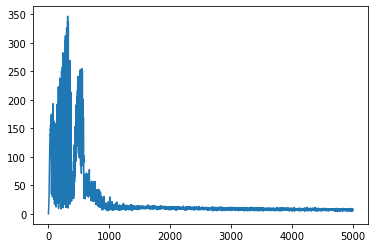

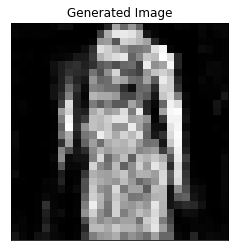

Iteration [5001/10000]......0.122(s) gen: -239.16193 - critic_fake: 237.33242 - critic_real: 246.03776 - neg_critic: 8.70534
Iteration [5002/10000]......0.115(s) gen: -238.68352 - critic_fake: 238.62363 - critic_real: 244.98796 - neg_critic: 6.36434
Iteration [5003/10000]......0.116(s) gen: -237.71262 - critic_fake: 238.48636 - critic_real: 245.65386 - neg_critic: 7.16750
Iteration [5004/10000]......0.117(s) gen: -238.41953 - critic_fake: 236.88059 - critic_real: 246.15041 - neg_critic: 9.26982
Iteration [5005/10000]......0.118(s) gen: -234.47614 - critic_fake: 238.52190 - critic_real: 245.76031 - neg_critic: 7.23841
Iteration [5006/10000]......0.116(s) gen: -240.29768 - critic_fake: 239.63376 - critic_real: 246.03681 - neg_critic: 6.40305
Iteration [5007/10000]......0.116(s) gen: -237.96336 - critic_fake: 237.63309 - critic_real: 245.88505 - neg_critic: 8.25196
Iteration [5008/10000]......0.116(s) gen: -235.97845 - critic_fake: 237.63865 - critic_real: 245.19339 - neg_critic: 7.55473


Iteration [5067/10000]......0.123(s) gen: -238.95282 - critic_fake: 238.61110 - critic_real: 246.63728 - neg_critic: 8.02618
Iteration [5068/10000]......0.124(s) gen: -240.09430 - critic_fake: 237.38086 - critic_real: 246.39733 - neg_critic: 9.01647
Iteration [5069/10000]......0.125(s) gen: -238.98190 - critic_fake: 238.68451 - critic_real: 246.17013 - neg_critic: 7.48563
Iteration [5070/10000]......0.124(s) gen: -237.31970 - critic_fake: 238.91416 - critic_real: 246.39038 - neg_critic: 7.47622
Iteration [5071/10000]......0.122(s) gen: -234.91522 - critic_fake: 237.86565 - critic_real: 246.87362 - neg_critic: 9.00797
Iteration [5072/10000]......0.124(s) gen: -236.34421 - critic_fake: 238.22036 - critic_real: 245.84077 - neg_critic: 7.62041
Iteration [5073/10000]......0.122(s) gen: -236.79672 - critic_fake: 239.75497 - critic_real: 246.52024 - neg_critic: 6.76526
Iteration [5074/10000]......0.122(s) gen: -238.92862 - critic_fake: 237.30453 - critic_real: 246.66261 - neg_critic: 9.35808


Iteration [5133/10000]......0.122(s) gen: -240.46146 - critic_fake: 238.99247 - critic_real: 246.97487 - neg_critic: 7.98241
Iteration [5134/10000]......0.128(s) gen: -239.10042 - critic_fake: 238.29747 - critic_real: 247.16051 - neg_critic: 8.86304
Iteration [5135/10000]......0.125(s) gen: -239.07471 - critic_fake: 239.41779 - critic_real: 246.61582 - neg_critic: 7.19802
Iteration [5136/10000]......0.128(s) gen: -239.77756 - critic_fake: 238.18466 - critic_real: 246.89431 - neg_critic: 8.70965
Iteration [5137/10000]......0.128(s) gen: -239.84555 - critic_fake: 238.56173 - critic_real: 246.61606 - neg_critic: 8.05433
Iteration [5138/10000]......0.129(s) gen: -238.28973 - critic_fake: 239.14517 - critic_real: 246.97083 - neg_critic: 7.82566
Iteration [5139/10000]......0.128(s) gen: -237.47075 - critic_fake: 239.02857 - critic_real: 246.62370 - neg_critic: 7.59513
Iteration [5140/10000]......0.129(s) gen: -238.70456 - critic_fake: 239.65103 - critic_real: 246.48276 - neg_critic: 6.83173


Iteration [5199/10000]......0.122(s) gen: -239.90280 - critic_fake: 239.58644 - critic_real: 247.73806 - neg_critic: 8.15161
Iteration [5200/10000]......0.122(s) gen: -238.20245 - critic_fake: 239.21925 - critic_real: 247.70034 - neg_critic: 8.48109
Iteration [5201/10000]......0.124(s) gen: -238.11047 - critic_fake: 239.07798 - critic_real: 247.25942 - neg_critic: 8.18143
Iteration [5202/10000]......0.120(s) gen: -239.80959 - critic_fake: 240.06320 - critic_real: 247.08709 - neg_critic: 7.02389
Iteration [5203/10000]......0.121(s) gen: -240.12666 - critic_fake: 239.18184 - critic_real: 247.60999 - neg_critic: 8.42816
Iteration [5204/10000]......0.118(s) gen: -236.17308 - critic_fake: 239.44637 - critic_real: 247.44260 - neg_critic: 7.99623
Iteration [5205/10000]......0.122(s) gen: -240.87653 - critic_fake: 240.34467 - critic_real: 247.93219 - neg_critic: 7.58752
Iteration [5206/10000]......0.120(s) gen: -239.75414 - critic_fake: 239.78563 - critic_real: 247.16033 - neg_critic: 7.37470


Iteration [5265/10000]......0.116(s) gen: -242.38046 - critic_fake: 239.88190 - critic_real: 247.64956 - neg_critic: 7.76766
Iteration [5266/10000]......0.118(s) gen: -242.12894 - critic_fake: 240.24606 - critic_real: 247.95598 - neg_critic: 7.70992
Iteration [5267/10000]......0.120(s) gen: -243.03262 - critic_fake: 242.75189 - critic_real: 247.29753 - neg_critic: 4.54563
Iteration [5268/10000]......0.119(s) gen: -241.30774 - critic_fake: 241.71978 - critic_real: 247.13138 - neg_critic: 5.41161
Iteration [5269/10000]......0.119(s) gen: -240.13425 - critic_fake: 241.28208 - critic_real: 247.62779 - neg_critic: 6.34571
Iteration [5270/10000]......0.119(s) gen: -240.83412 - critic_fake: 241.65334 - critic_real: 247.56074 - neg_critic: 5.90740
Iteration [5271/10000]......0.117(s) gen: -238.51431 - critic_fake: 241.08124 - critic_real: 247.50279 - neg_critic: 6.42155
Iteration [5272/10000]......0.120(s) gen: -238.24628 - critic_fake: 238.50594 - critic_real: 246.96663 - neg_critic: 8.46069


Iteration [5331/10000]......0.120(s) gen: -241.51041 - critic_fake: 242.72221 - critic_real: 247.35910 - neg_critic: 4.63688
Iteration [5332/10000]......0.119(s) gen: -240.65591 - critic_fake: 241.33263 - critic_real: 248.17307 - neg_critic: 6.84044
Iteration [5333/10000]......0.119(s) gen: -240.33131 - critic_fake: 239.99199 - critic_real: 247.26026 - neg_critic: 7.26827
Iteration [5334/10000]......0.120(s) gen: -242.72461 - critic_fake: 241.37585 - critic_real: 248.84909 - neg_critic: 7.47325
Iteration [5335/10000]......0.119(s) gen: -241.74564 - critic_fake: 242.89437 - critic_real: 248.67859 - neg_critic: 5.78423
Iteration [5336/10000]......0.121(s) gen: -241.74001 - critic_fake: 242.94177 - critic_real: 248.41623 - neg_critic: 5.47446
Iteration [5337/10000]......0.120(s) gen: -240.63251 - critic_fake: 240.82462 - critic_real: 247.83836 - neg_critic: 7.01374
Iteration [5338/10000]......0.124(s) gen: -238.69989 - critic_fake: 240.86742 - critic_real: 247.75565 - neg_critic: 6.88823


Iteration [5397/10000]......0.125(s) gen: -242.22485 - critic_fake: 240.21317 - critic_real: 248.53437 - neg_critic: 8.32120
Iteration [5398/10000]......0.123(s) gen: -242.93130 - critic_fake: 242.34989 - critic_real: 248.94659 - neg_critic: 6.59670
Iteration [5399/10000]......0.121(s) gen: -239.55026 - critic_fake: 241.34276 - critic_real: 249.65677 - neg_critic: 8.31402
Iteration [5400/10000]......0.120(s) gen: -240.39021 - critic_fake: 242.52114 - critic_real: 249.55905 - neg_critic: 7.03790
Iteration [5401/10000]......0.120(s) gen: -241.94121 - critic_fake: 241.34916 - critic_real: 248.80752 - neg_critic: 7.45836
Iteration [5402/10000]......0.119(s) gen: -243.52652 - critic_fake: 241.28226 - critic_real: 249.05458 - neg_critic: 7.77232
Iteration [5403/10000]......0.119(s) gen: -243.09680 - critic_fake: 243.84604 - critic_real: 248.06202 - neg_critic: 4.21598
Iteration [5404/10000]......0.120(s) gen: -242.20807 - critic_fake: 242.49457 - critic_real: 247.96124 - neg_critic: 5.46666


Iteration [5463/10000]......0.121(s) gen: -242.39868 - critic_fake: 242.41538 - critic_real: 249.52062 - neg_critic: 7.10524
Iteration [5464/10000]......0.122(s) gen: -241.96954 - critic_fake: 241.49438 - critic_real: 249.34688 - neg_critic: 7.85249
Iteration [5465/10000]......0.122(s) gen: -240.70761 - critic_fake: 240.96586 - critic_real: 249.32658 - neg_critic: 8.36072
Iteration [5466/10000]......0.124(s) gen: -241.21149 - critic_fake: 242.14620 - critic_real: 249.69830 - neg_critic: 7.55210
Iteration [5467/10000]......0.122(s) gen: -242.18307 - critic_fake: 241.88565 - critic_real: 249.55818 - neg_critic: 7.67253
Iteration [5468/10000]......0.120(s) gen: -243.97122 - critic_fake: 241.93609 - critic_real: 249.91252 - neg_critic: 7.97643
Iteration [5469/10000]......0.119(s) gen: -240.97598 - critic_fake: 242.63274 - critic_real: 249.55602 - neg_critic: 6.92329
Iteration [5470/10000]......0.118(s) gen: -240.92834 - critic_fake: 241.08434 - critic_real: 248.88221 - neg_critic: 7.79787


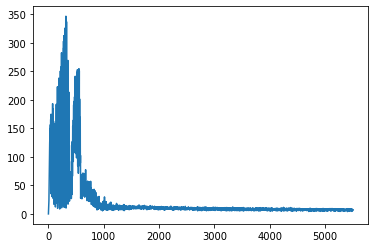

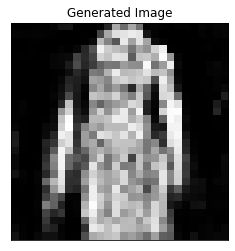

Iteration [5501/10000]......0.120(s) gen: -242.79555 - critic_fake: 241.26119 - critic_real: 248.58410 - neg_critic: 7.32290
Iteration [5502/10000]......0.117(s) gen: -242.45865 - critic_fake: 241.80897 - critic_real: 248.96236 - neg_critic: 7.15339
Iteration [5503/10000]......0.116(s) gen: -242.29797 - critic_fake: 243.11915 - critic_real: 249.41166 - neg_critic: 6.29251
Iteration [5504/10000]......0.115(s) gen: -244.55682 - critic_fake: 241.76846 - critic_real: 249.20760 - neg_critic: 7.43914
Iteration [5505/10000]......0.115(s) gen: -243.58353 - critic_fake: 243.94061 - critic_real: 249.22476 - neg_critic: 5.28415
Iteration [5506/10000]......0.116(s) gen: -242.21599 - critic_fake: 242.71635 - critic_real: 249.29820 - neg_critic: 6.58185
Iteration [5507/10000]......0.119(s) gen: -240.04056 - critic_fake: 241.76702 - critic_real: 249.26495 - neg_critic: 7.49792
Iteration [5508/10000]......0.117(s) gen: -242.15192 - critic_fake: 242.43555 - critic_real: 249.40424 - neg_critic: 6.96869


Iteration [5567/10000]......0.120(s) gen: -242.38461 - critic_fake: 242.65904 - critic_real: 249.87912 - neg_critic: 7.22008
Iteration [5568/10000]......0.120(s) gen: -242.93579 - critic_fake: 243.63304 - critic_real: 249.53938 - neg_critic: 5.90634
Iteration [5569/10000]......0.120(s) gen: -241.53223 - critic_fake: 242.77748 - critic_real: 249.98804 - neg_critic: 7.21056
Iteration [5570/10000]......0.122(s) gen: -241.98474 - critic_fake: 242.41073 - critic_real: 249.21909 - neg_critic: 6.80835
Iteration [5571/10000]......0.121(s) gen: -240.73851 - critic_fake: 242.54802 - critic_real: 249.29781 - neg_critic: 6.74979
Iteration [5572/10000]......0.122(s) gen: -242.99821 - critic_fake: 242.05150 - critic_real: 249.71210 - neg_critic: 7.66060
Iteration [5573/10000]......0.123(s) gen: -242.75551 - critic_fake: 243.32892 - critic_real: 250.13260 - neg_critic: 6.80368
Iteration [5574/10000]......0.124(s) gen: -240.01788 - critic_fake: 241.44182 - critic_real: 249.77247 - neg_critic: 8.33066


Iteration [5633/10000]......0.125(s) gen: -241.56306 - critic_fake: 244.17496 - critic_real: 250.31092 - neg_critic: 6.13596
Iteration [5634/10000]......0.123(s) gen: -242.57335 - critic_fake: 242.84567 - critic_real: 250.36705 - neg_critic: 7.52137
Iteration [5635/10000]......0.120(s) gen: -240.28070 - critic_fake: 242.27659 - critic_real: 250.80808 - neg_critic: 8.53149
Iteration [5636/10000]......0.119(s) gen: -245.10492 - critic_fake: 244.25757 - critic_real: 250.80031 - neg_critic: 6.54274
Iteration [5637/10000]......0.121(s) gen: -241.72638 - critic_fake: 244.42257 - critic_real: 250.85482 - neg_critic: 6.43225
Iteration [5638/10000]......0.123(s) gen: -239.09976 - critic_fake: 242.99096 - critic_real: 250.80756 - neg_critic: 7.81660
Iteration [5639/10000]......0.123(s) gen: -241.75111 - critic_fake: 243.07378 - critic_real: 250.51523 - neg_critic: 7.44145
Iteration [5640/10000]......0.121(s) gen: -242.82640 - critic_fake: 243.28597 - critic_real: 250.09895 - neg_critic: 6.81299


Iteration [5699/10000]......0.121(s) gen: -242.74738 - critic_fake: 244.83827 - critic_real: 251.51483 - neg_critic: 6.67656
Iteration [5700/10000]......0.121(s) gen: -243.85275 - critic_fake: 243.92587 - critic_real: 251.11661 - neg_critic: 7.19075
Iteration [5701/10000]......0.122(s) gen: -244.20181 - critic_fake: 244.78914 - critic_real: 250.79887 - neg_critic: 6.00974
Iteration [5702/10000]......0.121(s) gen: -243.25340 - critic_fake: 243.78751 - critic_real: 251.04581 - neg_critic: 7.25830
Iteration [5703/10000]......0.121(s) gen: -244.61989 - critic_fake: 242.40258 - critic_real: 251.11562 - neg_critic: 8.71304
Iteration [5704/10000]......0.121(s) gen: -245.16383 - critic_fake: 245.38367 - critic_real: 251.45874 - neg_critic: 6.07507
Iteration [5705/10000]......0.124(s) gen: -244.32278 - critic_fake: 244.79892 - critic_real: 250.85233 - neg_critic: 6.05342
Iteration [5706/10000]......0.123(s) gen: -243.46233 - critic_fake: 243.17450 - critic_real: 251.07697 - neg_critic: 7.90247


Iteration [5765/10000]......0.124(s) gen: -246.00728 - critic_fake: 243.89853 - critic_real: 251.66536 - neg_critic: 7.76683
Iteration [5766/10000]......0.125(s) gen: -243.67496 - critic_fake: 245.62261 - critic_real: 251.05746 - neg_critic: 5.43485
Iteration [5767/10000]......0.121(s) gen: -244.28189 - critic_fake: 243.92763 - critic_real: 251.19030 - neg_critic: 7.26267
Iteration [5768/10000]......0.120(s) gen: -245.85835 - critic_fake: 244.04136 - critic_real: 251.31058 - neg_critic: 7.26922
Iteration [5769/10000]......0.121(s) gen: -244.52051 - critic_fake: 245.50881 - critic_real: 251.24090 - neg_critic: 5.73209
Iteration [5770/10000]......0.124(s) gen: -244.31656 - critic_fake: 244.28808 - critic_real: 251.39323 - neg_critic: 7.10515
Iteration [5771/10000]......0.123(s) gen: -243.93613 - critic_fake: 243.93123 - critic_real: 251.14643 - neg_critic: 7.21520
Iteration [5772/10000]......0.123(s) gen: -246.26741 - critic_fake: 244.98112 - critic_real: 252.11774 - neg_critic: 7.13662


Iteration [5831/10000]......0.121(s) gen: -246.80312 - critic_fake: 245.95608 - critic_real: 253.30604 - neg_critic: 7.34996
Iteration [5832/10000]......0.121(s) gen: -244.68689 - critic_fake: 246.80308 - critic_real: 253.38695 - neg_critic: 6.58387
Iteration [5833/10000]......0.124(s) gen: -246.01431 - critic_fake: 244.85069 - critic_real: 252.54206 - neg_critic: 7.69138
Iteration [5834/10000]......0.127(s) gen: -246.00177 - critic_fake: 245.76136 - critic_real: 253.14059 - neg_critic: 7.37923
Iteration [5835/10000]......0.125(s) gen: -246.35779 - critic_fake: 245.65772 - critic_real: 253.49150 - neg_critic: 7.83378
Iteration [5836/10000]......0.124(s) gen: -246.23697 - critic_fake: 245.40458 - critic_real: 254.11946 - neg_critic: 8.71488
Iteration [5837/10000]......0.123(s) gen: -245.17436 - critic_fake: 245.95260 - critic_real: 253.58250 - neg_critic: 7.62990
Iteration [5838/10000]......0.123(s) gen: -246.47534 - critic_fake: 247.10017 - critic_real: 253.22202 - neg_critic: 6.12185


Iteration [5897/10000]......0.124(s) gen: -247.14966 - critic_fake: 246.02495 - critic_real: 253.33683 - neg_critic: 7.31188
Iteration [5898/10000]......0.126(s) gen: -246.20419 - critic_fake: 246.42499 - critic_real: 253.14622 - neg_critic: 6.72123
Iteration [5899/10000]......0.125(s) gen: -246.96013 - critic_fake: 247.52278 - critic_real: 253.43426 - neg_critic: 5.91147
Iteration [5900/10000]......0.125(s) gen: -247.77509 - critic_fake: 246.94745 - critic_real: 253.92167 - neg_critic: 6.97422
Iteration [5901/10000]......0.123(s) gen: -245.03134 - critic_fake: 246.20626 - critic_real: 253.87657 - neg_critic: 7.67031
Iteration [5902/10000]......0.122(s) gen: -246.17816 - critic_fake: 243.92986 - critic_real: 252.80071 - neg_critic: 8.87085
Iteration [5903/10000]......0.120(s) gen: -246.02702 - critic_fake: 245.61434 - critic_real: 253.04924 - neg_critic: 7.43490
Iteration [5904/10000]......0.121(s) gen: -244.76364 - critic_fake: 245.04612 - critic_real: 252.73541 - neg_critic: 7.68929


Iteration [5963/10000]......0.121(s) gen: -248.13689 - critic_fake: 246.59302 - critic_real: 253.92951 - neg_critic: 7.33649
Iteration [5964/10000]......0.120(s) gen: -246.39815 - critic_fake: 246.77523 - critic_real: 254.41017 - neg_critic: 7.63494
Iteration [5965/10000]......0.121(s) gen: -248.31671 - critic_fake: 246.89669 - critic_real: 254.66475 - neg_critic: 7.76805
Iteration [5966/10000]......0.120(s) gen: -248.63432 - critic_fake: 249.29430 - critic_real: 255.21985 - neg_critic: 5.92554
Iteration [5967/10000]......0.119(s) gen: -248.01724 - critic_fake: 247.22813 - critic_real: 254.60640 - neg_critic: 7.37827
Iteration [5968/10000]......0.121(s) gen: -246.14064 - critic_fake: 248.20807 - critic_real: 254.15860 - neg_critic: 5.95052
Iteration [5969/10000]......0.119(s) gen: -246.97614 - critic_fake: 246.90025 - critic_real: 254.46583 - neg_critic: 7.56558
Iteration [5970/10000]......0.120(s) gen: -248.27654 - critic_fake: 247.86525 - critic_real: 254.59435 - neg_critic: 6.72910


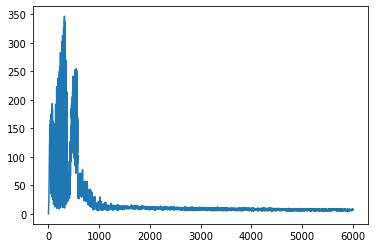

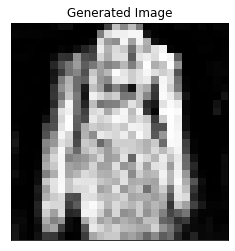

Iteration [6001/10000]......0.119(s) gen: -248.51392 - critic_fake: 245.66068 - critic_real: 254.72164 - neg_critic: 9.06096
Iteration [6002/10000]......0.117(s) gen: -249.32375 - critic_fake: 248.13932 - critic_real: 254.69043 - neg_critic: 6.55111
Iteration [6003/10000]......0.119(s) gen: -247.59387 - critic_fake: 248.65448 - critic_real: 254.56767 - neg_critic: 5.91319
Iteration [6004/10000]......0.118(s) gen: -247.96576 - critic_fake: 246.67833 - critic_real: 255.15975 - neg_critic: 8.48142
Iteration [6005/10000]......0.116(s) gen: -246.04829 - critic_fake: 248.14144 - critic_real: 254.68925 - neg_critic: 6.54781
Iteration [6006/10000]......0.116(s) gen: -246.39624 - critic_fake: 247.54774 - critic_real: 254.30103 - neg_critic: 6.75329
Iteration [6007/10000]......0.116(s) gen: -248.15160 - critic_fake: 247.71768 - critic_real: 254.73076 - neg_critic: 7.01307
Iteration [6008/10000]......0.116(s) gen: -245.82570 - critic_fake: 246.72995 - critic_real: 254.48946 - neg_critic: 7.75951


Iteration [6067/10000]......0.129(s) gen: -244.09238 - critic_fake: 248.52413 - critic_real: 255.49239 - neg_critic: 6.96826
Iteration [6068/10000]......0.128(s) gen: -247.06778 - critic_fake: 248.09160 - critic_real: 254.62905 - neg_critic: 6.53744
Iteration [6069/10000]......0.130(s) gen: -245.92831 - critic_fake: 247.49149 - critic_real: 254.90088 - neg_critic: 7.40939
Iteration [6070/10000]......0.131(s) gen: -248.67679 - critic_fake: 247.18091 - critic_real: 255.48123 - neg_critic: 8.30032
Iteration [6071/10000]......0.130(s) gen: -249.74738 - critic_fake: 247.91954 - critic_real: 255.48610 - neg_critic: 7.56656
Iteration [6072/10000]......0.130(s) gen: -250.39819 - critic_fake: 251.36381 - critic_real: 255.72615 - neg_critic: 4.36234
Iteration [6073/10000]......0.130(s) gen: -248.99677 - critic_fake: 249.57190 - critic_real: 255.37261 - neg_critic: 5.80070
Iteration [6074/10000]......0.130(s) gen: -246.72681 - critic_fake: 248.12770 - critic_real: 255.55431 - neg_critic: 7.42661


Iteration [6133/10000]......0.124(s) gen: -247.17184 - critic_fake: 249.27327 - critic_real: 255.93207 - neg_critic: 6.65880
Iteration [6134/10000]......0.129(s) gen: -247.66060 - critic_fake: 248.68945 - critic_real: 256.16049 - neg_critic: 7.47103
Iteration [6135/10000]......0.127(s) gen: -249.51260 - critic_fake: 248.34672 - critic_real: 256.29090 - neg_critic: 7.94418
Iteration [6136/10000]......0.127(s) gen: -249.38579 - critic_fake: 249.00833 - critic_real: 256.34376 - neg_critic: 7.33543
Iteration [6137/10000]......0.123(s) gen: -247.05035 - critic_fake: 248.71591 - critic_real: 255.74921 - neg_critic: 7.03329
Iteration [6138/10000]......0.122(s) gen: -248.39661 - critic_fake: 248.48406 - critic_real: 256.44390 - neg_critic: 7.95984
Iteration [6139/10000]......0.127(s) gen: -250.16425 - critic_fake: 248.64346 - critic_real: 255.95031 - neg_critic: 7.30685
Iteration [6140/10000]......0.127(s) gen: -249.08467 - critic_fake: 249.80372 - critic_real: 255.85585 - neg_critic: 6.05213


Iteration [6199/10000]......0.118(s) gen: -248.68375 - critic_fake: 249.04738 - critic_real: 255.87721 - neg_critic: 6.82982
Iteration [6200/10000]......0.119(s) gen: -249.30516 - critic_fake: 249.24513 - critic_real: 255.68442 - neg_critic: 6.43929
Iteration [6201/10000]......0.119(s) gen: -249.58347 - critic_fake: 249.34394 - critic_real: 255.91276 - neg_critic: 6.56882
Iteration [6202/10000]......0.121(s) gen: -250.70038 - critic_fake: 249.11016 - critic_real: 255.97934 - neg_critic: 6.86918
Iteration [6203/10000]......0.124(s) gen: -248.69545 - critic_fake: 249.94103 - critic_real: 256.50079 - neg_critic: 6.55976
Iteration [6204/10000]......0.124(s) gen: -249.47717 - critic_fake: 248.66079 - critic_real: 256.15479 - neg_critic: 7.49399
Iteration [6205/10000]......0.124(s) gen: -250.24908 - critic_fake: 248.92007 - critic_real: 256.11159 - neg_critic: 7.19152
Iteration [6206/10000]......0.121(s) gen: -247.37553 - critic_fake: 249.15164 - critic_real: 256.27099 - neg_critic: 7.11935


Iteration [6265/10000]......0.123(s) gen: -250.39615 - critic_fake: 249.53127 - critic_real: 257.00999 - neg_critic: 7.47872
Iteration [6266/10000]......0.123(s) gen: -248.77002 - critic_fake: 249.56746 - critic_real: 256.12914 - neg_critic: 6.56168
Iteration [6267/10000]......0.123(s) gen: -248.99780 - critic_fake: 249.46044 - critic_real: 256.88437 - neg_critic: 7.42393
Iteration [6268/10000]......0.125(s) gen: -251.60576 - critic_fake: 249.61161 - critic_real: 256.64179 - neg_critic: 7.03018
Iteration [6269/10000]......0.125(s) gen: -251.98729 - critic_fake: 250.22090 - critic_real: 257.36543 - neg_critic: 7.14453
Iteration [6270/10000]......0.125(s) gen: -249.32666 - critic_fake: 250.69308 - critic_real: 257.20104 - neg_critic: 6.50795
Iteration [6271/10000]......0.131(s) gen: -251.44751 - critic_fake: 250.90854 - critic_real: 257.28529 - neg_critic: 6.37675
Iteration [6272/10000]......0.127(s) gen: -246.27374 - critic_fake: 249.98012 - critic_real: 256.92163 - neg_critic: 6.94151


Iteration [6331/10000]......0.124(s) gen: -249.26997 - critic_fake: 250.09612 - critic_real: 256.91458 - neg_critic: 6.81846
Iteration [6332/10000]......0.124(s) gen: -250.85466 - critic_fake: 249.93026 - critic_real: 256.64813 - neg_critic: 6.71787
Iteration [6333/10000]......0.125(s) gen: -251.44919 - critic_fake: 249.65652 - critic_real: 257.31187 - neg_critic: 7.65534
Iteration [6334/10000]......0.122(s) gen: -249.09846 - critic_fake: 250.71070 - critic_real: 257.26704 - neg_critic: 6.55634
Iteration [6335/10000]......0.122(s) gen: -248.19189 - critic_fake: 250.69226 - critic_real: 257.63939 - neg_critic: 6.94713
Iteration [6336/10000]......0.122(s) gen: -248.76263 - critic_fake: 249.27585 - critic_real: 257.45489 - neg_critic: 8.17903
Iteration [6337/10000]......0.121(s) gen: -248.56905 - critic_fake: 250.09413 - critic_real: 257.21788 - neg_critic: 7.12375
Iteration [6338/10000]......0.121(s) gen: -250.11105 - critic_fake: 250.69367 - critic_real: 257.13958 - neg_critic: 6.44591


Iteration [6397/10000]......0.115(s) gen: -251.69421 - critic_fake: 253.04169 - critic_real: 258.32196 - neg_critic: 5.28027
Iteration [6398/10000]......0.116(s) gen: -251.44046 - critic_fake: 251.45009 - critic_real: 257.98516 - neg_critic: 6.53507
Iteration [6399/10000]......0.115(s) gen: -252.36658 - critic_fake: 251.65060 - critic_real: 258.42076 - neg_critic: 6.77016
Iteration [6400/10000]......0.115(s) gen: -252.07596 - critic_fake: 251.54890 - critic_real: 258.46223 - neg_critic: 6.91332
Iteration [6401/10000]......0.115(s) gen: -250.70502 - critic_fake: 251.00780 - critic_real: 258.09784 - neg_critic: 7.09004
Iteration [6402/10000]......0.116(s) gen: -250.97449 - critic_fake: 250.97076 - critic_real: 258.12319 - neg_critic: 7.15244
Iteration [6403/10000]......0.116(s) gen: -248.80447 - critic_fake: 250.87473 - critic_real: 258.07987 - neg_critic: 7.20514
Iteration [6404/10000]......0.117(s) gen: -251.95432 - critic_fake: 251.36077 - critic_real: 258.29444 - neg_critic: 6.93367


Iteration [6463/10000]......0.123(s) gen: -250.84438 - critic_fake: 250.98345 - critic_real: 258.41843 - neg_critic: 7.43498
Iteration [6464/10000]......0.122(s) gen: -251.78496 - critic_fake: 250.97892 - critic_real: 258.97826 - neg_critic: 7.99933
Iteration [6465/10000]......0.121(s) gen: -253.57211 - critic_fake: 252.78257 - critic_real: 258.42208 - neg_critic: 5.63951
Iteration [6466/10000]......0.126(s) gen: -252.07083 - critic_fake: 252.25848 - critic_real: 258.88323 - neg_critic: 6.62475
Iteration [6467/10000]......0.129(s) gen: -252.04391 - critic_fake: 251.82479 - critic_real: 258.50098 - neg_critic: 6.67619
Iteration [6468/10000]......0.121(s) gen: -252.11700 - critic_fake: 252.14661 - critic_real: 258.62061 - neg_critic: 6.47399
Iteration [6469/10000]......0.124(s) gen: -253.81870 - critic_fake: 251.07114 - critic_real: 258.70200 - neg_critic: 7.63086
Iteration [6470/10000]......0.124(s) gen: -251.99377 - critic_fake: 252.88724 - critic_real: 258.97931 - neg_critic: 6.09207


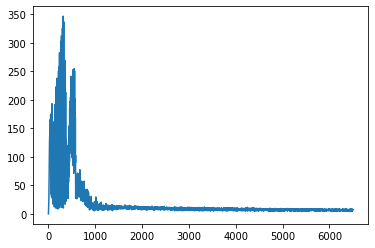

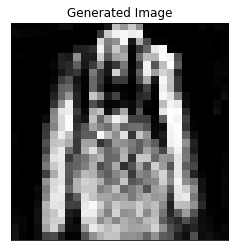

Iteration [6501/10000]......0.123(s) gen: -251.46844 - critic_fake: 251.48841 - critic_real: 258.46091 - neg_critic: 6.97249
Iteration [6502/10000]......0.115(s) gen: -254.60628 - critic_fake: 251.96011 - critic_real: 258.72665 - neg_critic: 6.76654
Iteration [6503/10000]......0.115(s) gen: -252.15883 - critic_fake: 253.88690 - critic_real: 259.27069 - neg_critic: 5.38379
Iteration [6504/10000]......0.116(s) gen: -252.12245 - critic_fake: 251.24461 - critic_real: 259.30914 - neg_critic: 8.06453
Iteration [6505/10000]......0.114(s) gen: -253.03015 - critic_fake: 252.67793 - critic_real: 259.16163 - neg_critic: 6.48370
Iteration [6506/10000]......0.116(s) gen: -253.95999 - critic_fake: 252.19858 - critic_real: 259.09218 - neg_critic: 6.89359
Iteration [6507/10000]......0.116(s) gen: -250.97189 - critic_fake: 253.16003 - critic_real: 259.02418 - neg_critic: 5.86415
Iteration [6508/10000]......0.116(s) gen: -252.72159 - critic_fake: 251.11386 - critic_real: 258.82540 - neg_critic: 7.71154


Iteration [6568/10000]......0.124(s) gen: -252.97420 - critic_fake: 253.74229 - critic_real: 259.86707 - neg_critic: 6.12478
Iteration [6569/10000]......0.124(s) gen: -252.46732 - critic_fake: 252.20056 - critic_real: 259.93851 - neg_critic: 7.73795
Iteration [6570/10000]......0.122(s) gen: -253.39197 - critic_fake: 252.59561 - critic_real: 259.50385 - neg_critic: 6.90824
Iteration [6571/10000]......0.119(s) gen: -251.86324 - critic_fake: 252.33077 - critic_real: 258.70471 - neg_critic: 6.37394
Iteration [6572/10000]......0.119(s) gen: -253.09320 - critic_fake: 252.50016 - critic_real: 259.48415 - neg_critic: 6.98398
Iteration [6573/10000]......0.120(s) gen: -252.79062 - critic_fake: 252.63395 - critic_real: 259.40695 - neg_critic: 6.77299
Iteration [6574/10000]......0.117(s) gen: -251.28552 - critic_fake: 251.96550 - critic_real: 259.05326 - neg_critic: 7.08776
Iteration [6575/10000]......0.117(s) gen: -253.98975 - critic_fake: 254.30668 - critic_real: 260.96793 - neg_critic: 6.66125


Iteration [6634/10000]......0.122(s) gen: -251.90790 - critic_fake: 251.51201 - critic_real: 259.47248 - neg_critic: 7.96047
Iteration [6635/10000]......0.122(s) gen: -253.06293 - critic_fake: 253.27861 - critic_real: 259.80635 - neg_critic: 6.52774
Iteration [6636/10000]......0.124(s) gen: -254.59503 - critic_fake: 252.24469 - critic_real: 259.84553 - neg_critic: 7.60084
Iteration [6637/10000]......0.125(s) gen: -252.74342 - critic_fake: 254.45930 - critic_real: 259.97261 - neg_critic: 5.51331
Iteration [6638/10000]......0.124(s) gen: -252.89488 - critic_fake: 253.23226 - critic_real: 260.04676 - neg_critic: 6.81450
Iteration [6639/10000]......0.124(s) gen: -252.88571 - critic_fake: 254.71110 - critic_real: 260.69140 - neg_critic: 5.98030
Iteration [6640/10000]......0.123(s) gen: -252.87781 - critic_fake: 253.17296 - critic_real: 260.08259 - neg_critic: 6.90963
Iteration [6641/10000]......0.121(s) gen: -252.30417 - critic_fake: 253.45804 - critic_real: 259.93072 - neg_critic: 6.47268


Iteration [6700/10000]......0.124(s) gen: -255.47865 - critic_fake: 253.52455 - critic_real: 260.36125 - neg_critic: 6.83670
Iteration [6701/10000]......0.123(s) gen: -252.75003 - critic_fake: 254.84752 - critic_real: 260.58345 - neg_critic: 5.73593
Iteration [6702/10000]......0.123(s) gen: -252.55534 - critic_fake: 254.37766 - critic_real: 260.84445 - neg_critic: 6.46680
Iteration [6703/10000]......0.123(s) gen: -252.51193 - critic_fake: 253.69587 - critic_real: 260.72179 - neg_critic: 7.02592
Iteration [6704/10000]......0.122(s) gen: -255.83368 - critic_fake: 255.49000 - critic_real: 260.44146 - neg_critic: 4.95146
Iteration [6705/10000]......0.122(s) gen: -255.16000 - critic_fake: 255.39663 - critic_real: 260.68016 - neg_critic: 5.28353
Iteration [6706/10000]......0.120(s) gen: -254.13489 - critic_fake: 254.84639 - critic_real: 260.48302 - neg_critic: 5.63663
Iteration [6707/10000]......0.119(s) gen: -252.82027 - critic_fake: 253.46237 - critic_real: 260.46731 - neg_critic: 7.00494


Iteration [6766/10000]......0.122(s) gen: -255.24017 - critic_fake: 255.19522 - critic_real: 261.23846 - neg_critic: 6.04324
Iteration [6767/10000]......0.122(s) gen: -255.09900 - critic_fake: 254.25478 - critic_real: 260.97320 - neg_critic: 6.71842
Iteration [6768/10000]......0.123(s) gen: -256.03326 - critic_fake: 253.71698 - critic_real: 261.37228 - neg_critic: 7.65530
Iteration [6769/10000]......0.122(s) gen: -255.27211 - critic_fake: 255.18690 - critic_real: 261.83639 - neg_critic: 6.64949
Iteration [6770/10000]......0.120(s) gen: -253.69855 - critic_fake: 254.00571 - critic_real: 260.98489 - neg_critic: 6.97918
Iteration [6771/10000]......0.121(s) gen: -254.52744 - critic_fake: 255.20709 - critic_real: 261.52575 - neg_critic: 6.31866
Iteration [6772/10000]......0.120(s) gen: -253.07245 - critic_fake: 254.94335 - critic_real: 261.56949 - neg_critic: 6.62615
Iteration [6773/10000]......0.122(s) gen: -255.71182 - critic_fake: 255.88767 - critic_real: 261.28845 - neg_critic: 5.40077


Iteration [6832/10000]......0.123(s) gen: -251.13702 - critic_fake: 254.13372 - critic_real: 262.00356 - neg_critic: 7.86984
Iteration [6833/10000]......0.124(s) gen: -254.45958 - critic_fake: 254.90580 - critic_real: 261.67698 - neg_critic: 6.77118
Iteration [6834/10000]......0.122(s) gen: -255.99551 - critic_fake: 253.80103 - critic_real: 260.82911 - neg_critic: 7.02808
Iteration [6835/10000]......0.122(s) gen: -254.26596 - critic_fake: 256.08944 - critic_real: 261.81473 - neg_critic: 5.72530
Iteration [6836/10000]......0.125(s) gen: -255.17705 - critic_fake: 254.39443 - critic_real: 261.32891 - neg_critic: 6.93448
Iteration [6837/10000]......0.121(s) gen: -253.94424 - critic_fake: 253.95065 - critic_real: 262.03606 - neg_critic: 8.08541
Iteration [6838/10000]......0.121(s) gen: -254.49744 - critic_fake: 253.79015 - critic_real: 261.27790 - neg_critic: 7.48775
Iteration [6839/10000]......0.121(s) gen: -256.58771 - critic_fake: 254.49161 - critic_real: 261.86213 - neg_critic: 7.37051


Iteration [6898/10000]......0.119(s) gen: -254.79372 - critic_fake: 256.24146 - critic_real: 262.27869 - neg_critic: 6.03723
Iteration [6899/10000]......0.119(s) gen: -256.87259 - critic_fake: 255.25153 - critic_real: 262.02453 - neg_critic: 6.77300
Iteration [6900/10000]......0.119(s) gen: -256.12750 - critic_fake: 254.75882 - critic_real: 262.32291 - neg_critic: 7.56408
Iteration [6901/10000]......0.118(s) gen: -256.37262 - critic_fake: 255.76899 - critic_real: 262.31938 - neg_critic: 6.55039
Iteration [6902/10000]......0.119(s) gen: -256.24786 - critic_fake: 256.44409 - critic_real: 262.79122 - neg_critic: 6.34714
Iteration [6903/10000]......0.119(s) gen: -255.33679 - critic_fake: 255.73121 - critic_real: 262.28909 - neg_critic: 6.55788
Iteration [6904/10000]......0.120(s) gen: -254.39551 - critic_fake: 256.12542 - critic_real: 262.53926 - neg_critic: 6.41385
Iteration [6905/10000]......0.120(s) gen: -254.77225 - critic_fake: 254.51212 - critic_real: 262.04678 - neg_critic: 7.53466


Iteration [6964/10000]......0.122(s) gen: -254.32559 - critic_fake: 256.17450 - critic_real: 262.90268 - neg_critic: 6.72818
Iteration [6965/10000]......0.121(s) gen: -257.17859 - critic_fake: 256.19275 - critic_real: 262.88246 - neg_critic: 6.68971
Iteration [6966/10000]......0.131(s) gen: -254.72992 - critic_fake: 255.53408 - critic_real: 262.55819 - neg_critic: 7.02411
Iteration [6967/10000]......0.128(s) gen: -256.93073 - critic_fake: 256.27477 - critic_real: 262.27551 - neg_critic: 6.00074
Iteration [6968/10000]......0.121(s) gen: -256.40759 - critic_fake: 256.21854 - critic_real: 261.77540 - neg_critic: 5.55686
Iteration [6969/10000]......0.121(s) gen: -253.36150 - critic_fake: 255.25978 - critic_real: 261.72805 - neg_critic: 6.46826
Iteration [6970/10000]......0.121(s) gen: -257.23975 - critic_fake: 255.07319 - critic_real: 262.73815 - neg_critic: 7.66496
Iteration [6971/10000]......0.122(s) gen: -255.98355 - critic_fake: 257.00206 - critic_real: 263.22231 - neg_critic: 6.22025


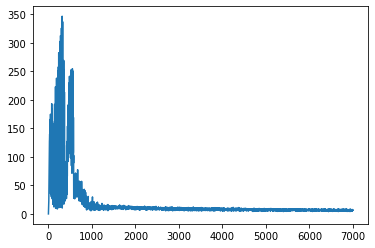

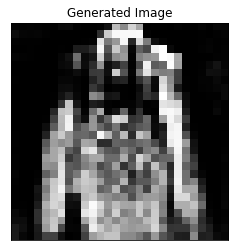

Iteration [7001/10000]......0.119(s) gen: -258.05945 - critic_fake: 256.57062 - critic_real: 263.68177 - neg_critic: 7.11115
Iteration [7002/10000]......0.114(s) gen: -256.51129 - critic_fake: 257.66354 - critic_real: 263.44008 - neg_critic: 5.77654
Iteration [7003/10000]......0.115(s) gen: -255.91312 - critic_fake: 256.18767 - critic_real: 263.05254 - neg_critic: 6.86487
Iteration [7004/10000]......0.115(s) gen: -258.37787 - critic_fake: 257.55022 - critic_real: 263.09874 - neg_critic: 5.54852
Iteration [7005/10000]......0.117(s) gen: -255.89130 - critic_fake: 255.94294 - critic_real: 262.80654 - neg_critic: 6.86360
Iteration [7006/10000]......0.116(s) gen: -254.40903 - critic_fake: 255.12436 - critic_real: 262.81975 - neg_critic: 7.69539
Iteration [7007/10000]......0.116(s) gen: -256.12146 - critic_fake: 255.68964 - critic_real: 262.71495 - neg_critic: 7.02531
Iteration [7008/10000]......0.116(s) gen: -257.90515 - critic_fake: 257.29654 - critic_real: 263.20511 - neg_critic: 5.90858


Iteration [7068/10000]......0.121(s) gen: -256.56445 - critic_fake: 257.59981 - critic_real: 263.98423 - neg_critic: 6.38442
Iteration [7069/10000]......0.121(s) gen: -256.06815 - critic_fake: 257.54600 - critic_real: 263.42087 - neg_critic: 5.87488
Iteration [7070/10000]......0.122(s) gen: -255.78563 - critic_fake: 256.72927 - critic_real: 263.08206 - neg_critic: 6.35280
Iteration [7071/10000]......0.123(s) gen: -256.99390 - critic_fake: 256.66509 - critic_real: 263.56131 - neg_critic: 6.89622
Iteration [7072/10000]......0.124(s) gen: -257.86221 - critic_fake: 257.24832 - critic_real: 264.31938 - neg_critic: 7.07107
Iteration [7073/10000]......0.124(s) gen: -257.31360 - critic_fake: 256.83242 - critic_real: 263.93574 - neg_critic: 7.10332
Iteration [7074/10000]......0.122(s) gen: -257.29691 - critic_fake: 257.17962 - critic_real: 264.27613 - neg_critic: 7.09651
Iteration [7075/10000]......0.122(s) gen: -257.48688 - critic_fake: 258.10772 - critic_real: 263.78685 - neg_critic: 5.67913


Iteration [7134/10000]......0.120(s) gen: -259.44580 - critic_fake: 258.86700 - critic_real: 264.44513 - neg_critic: 5.57813
Iteration [7135/10000]......0.121(s) gen: -257.56491 - critic_fake: 258.58805 - critic_real: 264.01589 - neg_critic: 5.42784
Iteration [7136/10000]......0.119(s) gen: -257.50778 - critic_fake: 258.26364 - critic_real: 264.61270 - neg_critic: 6.34905
Iteration [7137/10000]......0.120(s) gen: -257.26779 - critic_fake: 257.91935 - critic_real: 264.90956 - neg_critic: 6.99020
Iteration [7138/10000]......0.121(s) gen: -256.81360 - critic_fake: 257.27217 - critic_real: 264.67938 - neg_critic: 7.40721
Iteration [7139/10000]......0.121(s) gen: -257.84625 - critic_fake: 257.98403 - critic_real: 264.55749 - neg_critic: 6.57346
Iteration [7140/10000]......0.122(s) gen: -258.31519 - critic_fake: 257.12007 - critic_real: 265.04243 - neg_critic: 7.92236
Iteration [7141/10000]......0.121(s) gen: -258.36694 - critic_fake: 258.81263 - critic_real: 264.60724 - neg_critic: 5.79462


Iteration [7200/10000]......0.123(s) gen: -259.39963 - critic_fake: 257.83174 - critic_real: 264.73160 - neg_critic: 6.89987
Iteration [7201/10000]......0.124(s) gen: -258.14182 - critic_fake: 258.20269 - critic_real: 264.63138 - neg_critic: 6.42869
Iteration [7202/10000]......0.122(s) gen: -258.92648 - critic_fake: 257.17693 - critic_real: 264.57145 - neg_critic: 7.39452
Iteration [7203/10000]......0.123(s) gen: -259.10004 - critic_fake: 258.66016 - critic_real: 264.41965 - neg_critic: 5.75949
Iteration [7204/10000]......0.123(s) gen: -257.57837 - critic_fake: 258.37006 - critic_real: 264.59927 - neg_critic: 6.22921
Iteration [7205/10000]......0.124(s) gen: -256.45526 - critic_fake: 257.73481 - critic_real: 264.85447 - neg_critic: 7.11966
Iteration [7206/10000]......0.122(s) gen: -256.84952 - critic_fake: 257.73166 - critic_real: 265.06921 - neg_critic: 7.33755
Iteration [7207/10000]......0.121(s) gen: -258.33392 - critic_fake: 258.48668 - critic_real: 265.44261 - neg_critic: 6.95593


Iteration [7266/10000]......0.122(s) gen: -258.46893 - critic_fake: 259.87094 - critic_real: 265.32233 - neg_critic: 5.45139
Iteration [7267/10000]......0.123(s) gen: -259.83890 - critic_fake: 259.47455 - critic_real: 265.42159 - neg_critic: 5.94703
Iteration [7268/10000]......0.124(s) gen: -259.43158 - critic_fake: 259.53343 - critic_real: 265.29648 - neg_critic: 5.76305
Iteration [7269/10000]......0.125(s) gen: -258.97345 - critic_fake: 258.71942 - critic_real: 265.28867 - neg_critic: 6.56925
Iteration [7270/10000]......0.123(s) gen: -260.44458 - critic_fake: 257.89032 - critic_real: 265.16249 - neg_critic: 7.27217
Iteration [7271/10000]......0.123(s) gen: -259.74139 - critic_fake: 258.82180 - critic_real: 265.93320 - neg_critic: 7.11140
Iteration [7272/10000]......0.122(s) gen: -258.37488 - critic_fake: 259.80352 - critic_real: 265.68356 - neg_critic: 5.88004
Iteration [7273/10000]......0.125(s) gen: -258.54816 - critic_fake: 258.15885 - critic_real: 264.76896 - neg_critic: 6.61011


Iteration [7332/10000]......0.124(s) gen: -261.35382 - critic_fake: 259.35509 - critic_real: 266.17220 - neg_critic: 6.81711
Iteration [7333/10000]......0.124(s) gen: -260.73456 - critic_fake: 261.48510 - critic_real: 265.73412 - neg_critic: 4.24902
Iteration [7334/10000]......0.126(s) gen: -259.74066 - critic_fake: 259.85374 - critic_real: 265.50249 - neg_critic: 5.64875
Iteration [7335/10000]......0.126(s) gen: -260.07361 - critic_fake: 259.31014 - critic_real: 265.81155 - neg_critic: 6.50141
Iteration [7336/10000]......0.125(s) gen: -259.57404 - critic_fake: 258.82473 - critic_real: 265.88926 - neg_critic: 7.06453
Iteration [7337/10000]......0.124(s) gen: -259.48758 - critic_fake: 259.37158 - critic_real: 265.91885 - neg_critic: 6.54727
Iteration [7338/10000]......0.124(s) gen: -260.28497 - critic_fake: 259.32371 - critic_real: 266.09916 - neg_critic: 6.77545
Iteration [7339/10000]......0.123(s) gen: -261.83405 - critic_fake: 260.12255 - critic_real: 266.13967 - neg_critic: 6.01711


Iteration [7398/10000]......0.123(s) gen: -257.93558 - critic_fake: 258.29134 - critic_real: 266.34846 - neg_critic: 8.05712
Iteration [7399/10000]......0.121(s) gen: -258.39673 - critic_fake: 259.01451 - critic_real: 266.09764 - neg_critic: 7.08313
Iteration [7400/10000]......0.122(s) gen: -259.81546 - critic_fake: 259.95186 - critic_real: 266.22379 - neg_critic: 6.27193
Iteration [7401/10000]......0.122(s) gen: -261.14148 - critic_fake: 261.14987 - critic_real: 266.89122 - neg_critic: 5.74135
Iteration [7402/10000]......0.122(s) gen: -258.87997 - critic_fake: 259.86161 - critic_real: 266.67745 - neg_critic: 6.81584
Iteration [7403/10000]......0.120(s) gen: -260.49963 - critic_fake: 259.62312 - critic_real: 266.41965 - neg_critic: 6.79653
Iteration [7404/10000]......0.120(s) gen: -259.09393 - critic_fake: 259.90008 - critic_real: 266.64078 - neg_critic: 6.74070
Iteration [7405/10000]......0.121(s) gen: -261.16718 - critic_fake: 259.76229 - critic_real: 266.27263 - neg_critic: 6.51033


Iteration [7464/10000]......0.118(s) gen: -261.54205 - critic_fake: 260.14989 - critic_real: 266.64887 - neg_critic: 6.49898
Iteration [7465/10000]......0.121(s) gen: -260.80328 - critic_fake: 259.97303 - critic_real: 267.25059 - neg_critic: 7.27756
Iteration [7466/10000]......0.124(s) gen: -261.12323 - critic_fake: 260.30195 - critic_real: 266.89525 - neg_critic: 6.59329
Iteration [7467/10000]......0.118(s) gen: -260.74475 - critic_fake: 258.88631 - critic_real: 266.40750 - neg_critic: 7.52119
Iteration [7468/10000]......0.119(s) gen: -259.78931 - critic_fake: 259.99307 - critic_real: 266.15759 - neg_critic: 6.16451
Iteration [7469/10000]......0.119(s) gen: -261.46472 - critic_fake: 259.99037 - critic_real: 267.12280 - neg_critic: 7.13243
Iteration [7470/10000]......0.120(s) gen: -262.48801 - critic_fake: 261.28274 - critic_real: 267.04333 - neg_critic: 5.76059
Iteration [7471/10000]......0.119(s) gen: -259.88385 - critic_fake: 261.49512 - critic_real: 266.76093 - neg_critic: 5.26581


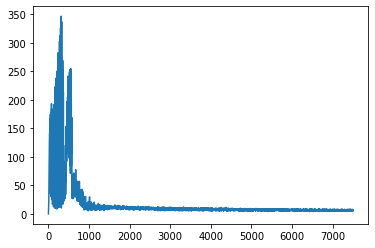

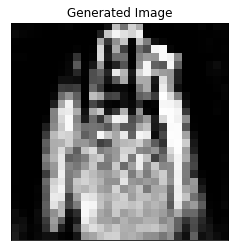

Iteration [7501/10000]......0.127(s) gen: -259.18475 - critic_fake: 261.03316 - critic_real: 266.91306 - neg_critic: 5.87990
Iteration [7502/10000]......0.116(s) gen: -262.16525 - critic_fake: 260.40977 - critic_real: 266.99321 - neg_critic: 6.58344
Iteration [7503/10000]......0.116(s) gen: -259.88211 - critic_fake: 260.98136 - critic_real: 267.42086 - neg_critic: 6.43950
Iteration [7504/10000]......0.117(s) gen: -259.43774 - critic_fake: 261.12339 - critic_real: 266.70732 - neg_critic: 5.58392
Iteration [7505/10000]......0.115(s) gen: -261.08334 - critic_fake: 260.44378 - critic_real: 266.67893 - neg_critic: 6.23515
Iteration [7506/10000]......0.117(s) gen: -259.14905 - critic_fake: 260.82835 - critic_real: 266.77485 - neg_critic: 5.94650
Iteration [7507/10000]......0.117(s) gen: -260.69534 - critic_fake: 260.85916 - critic_real: 266.47876 - neg_critic: 5.61960
Iteration [7508/10000]......0.118(s) gen: -259.76550 - critic_fake: 259.84696 - critic_real: 266.90384 - neg_critic: 7.05688


Iteration [7568/10000]......0.120(s) gen: -258.66098 - critic_fake: 259.46272 - critic_real: 266.96355 - neg_critic: 7.50083
Iteration [7569/10000]......0.120(s) gen: -262.59467 - critic_fake: 261.55703 - critic_real: 267.83803 - neg_critic: 6.28101
Iteration [7570/10000]......0.123(s) gen: -262.49890 - critic_fake: 261.10558 - critic_real: 267.90488 - neg_critic: 6.79930
Iteration [7571/10000]......0.123(s) gen: -262.29254 - critic_fake: 262.70849 - critic_real: 267.39590 - neg_critic: 4.68741
Iteration [7572/10000]......0.124(s) gen: -260.93954 - critic_fake: 262.34839 - critic_real: 267.77167 - neg_critic: 5.42328
Iteration [7573/10000]......0.135(s) gen: -263.17087 - critic_fake: 262.96961 - critic_real: 267.96006 - neg_critic: 4.99045
Iteration [7574/10000]......0.120(s) gen: -260.30017 - critic_fake: 261.96849 - critic_real: 268.13560 - neg_critic: 6.16711
Iteration [7575/10000]......0.121(s) gen: -261.67603 - critic_fake: 261.30977 - critic_real: 267.59341 - neg_critic: 6.28364


Iteration [7634/10000]......0.122(s) gen: -263.37601 - critic_fake: 263.01991 - critic_real: 268.91373 - neg_critic: 5.89382
Iteration [7635/10000]......0.122(s) gen: -261.17969 - critic_fake: 261.22680 - critic_real: 268.68830 - neg_critic: 7.46150
Iteration [7636/10000]......0.121(s) gen: -262.32422 - critic_fake: 260.13694 - critic_real: 268.21489 - neg_critic: 8.07795
Iteration [7637/10000]......0.121(s) gen: -260.65302 - critic_fake: 262.37905 - critic_real: 268.76793 - neg_critic: 6.38887
Iteration [7638/10000]......0.120(s) gen: -260.23035 - critic_fake: 261.66959 - critic_real: 268.94644 - neg_critic: 7.27685
Iteration [7639/10000]......0.119(s) gen: -262.59924 - critic_fake: 261.62748 - critic_real: 268.94203 - neg_critic: 7.31456
Iteration [7640/10000]......0.119(s) gen: -261.53046 - critic_fake: 262.01159 - critic_real: 268.13682 - neg_critic: 6.12523
Iteration [7641/10000]......0.122(s) gen: -261.21149 - critic_fake: 262.87925 - critic_real: 269.27253 - neg_critic: 6.39328


Iteration [7700/10000]......0.119(s) gen: -261.27194 - critic_fake: 262.43724 - critic_real: 268.59318 - neg_critic: 6.15594
Iteration [7701/10000]......0.120(s) gen: -261.56760 - critic_fake: 261.74712 - critic_real: 268.35333 - neg_critic: 6.60621
Iteration [7702/10000]......0.120(s) gen: -261.92676 - critic_fake: 261.50165 - critic_real: 268.83859 - neg_critic: 7.33693
Iteration [7703/10000]......0.121(s) gen: -260.13165 - critic_fake: 262.76843 - critic_real: 269.52275 - neg_critic: 6.75432
Iteration [7704/10000]......0.123(s) gen: -264.89938 - critic_fake: 263.09246 - critic_real: 269.34713 - neg_critic: 6.25467
Iteration [7705/10000]......0.122(s) gen: -264.10614 - critic_fake: 264.00899 - critic_real: 270.07330 - neg_critic: 6.06431
Iteration [7706/10000]......0.122(s) gen: -262.82565 - critic_fake: 263.72861 - critic_real: 269.68058 - neg_critic: 5.95197
Iteration [7707/10000]......0.122(s) gen: -263.01239 - critic_fake: 262.65217 - critic_real: 269.69601 - neg_critic: 7.04384


Iteration [7766/10000]......0.120(s) gen: -262.80023 - critic_fake: 264.43850 - critic_real: 269.85276 - neg_critic: 5.41426
Iteration [7767/10000]......0.120(s) gen: -264.77612 - critic_fake: 264.73596 - critic_real: 270.55121 - neg_critic: 5.81525
Iteration [7768/10000]......0.122(s) gen: -261.24536 - critic_fake: 263.32280 - critic_real: 270.73800 - neg_critic: 7.41520
Iteration [7769/10000]......0.123(s) gen: -263.33484 - critic_fake: 263.51997 - critic_real: 269.29592 - neg_critic: 5.77595
Iteration [7770/10000]......0.125(s) gen: -262.40427 - critic_fake: 262.22883 - critic_real: 269.64891 - neg_critic: 7.42009
Iteration [7771/10000]......0.125(s) gen: -262.62335 - critic_fake: 263.44171 - critic_real: 269.37365 - neg_critic: 5.93195
Iteration [7772/10000]......0.124(s) gen: -261.23468 - critic_fake: 263.03018 - critic_real: 270.21456 - neg_critic: 7.18438
Iteration [7773/10000]......0.126(s) gen: -263.99335 - critic_fake: 263.99008 - critic_real: 270.02829 - neg_critic: 6.03821


Iteration [7832/10000]......0.122(s) gen: -262.70038 - critic_fake: 263.41918 - critic_real: 269.31699 - neg_critic: 5.89781
Iteration [7833/10000]......0.124(s) gen: -264.19608 - critic_fake: 262.47521 - critic_real: 270.48078 - neg_critic: 8.00557
Iteration [7834/10000]......0.133(s) gen: -261.96948 - critic_fake: 263.63720 - critic_real: 270.63668 - neg_critic: 6.99948
Iteration [7835/10000]......0.122(s) gen: -265.57864 - critic_fake: 263.71669 - critic_real: 270.55590 - neg_critic: 6.83921
Iteration [7836/10000]......0.141(s) gen: -264.80597 - critic_fake: 264.77980 - critic_real: 270.87068 - neg_critic: 6.09088
Iteration [7837/10000]......0.119(s) gen: -264.52274 - critic_fake: 265.39834 - critic_real: 271.25345 - neg_critic: 5.85511
Iteration [7838/10000]......0.119(s) gen: -265.43152 - critic_fake: 263.92408 - critic_real: 270.31500 - neg_critic: 6.39092
Iteration [7839/10000]......0.120(s) gen: -263.89255 - critic_fake: 263.45569 - critic_real: 270.82149 - neg_critic: 7.36580


Iteration [7898/10000]......0.122(s) gen: -265.70398 - critic_fake: 263.24548 - critic_real: 271.07349 - neg_critic: 7.82802
Iteration [7899/10000]......0.123(s) gen: -264.91376 - critic_fake: 266.00614 - critic_real: 271.25640 - neg_critic: 5.25026
Iteration [7900/10000]......0.124(s) gen: -263.12372 - critic_fake: 264.82467 - critic_real: 270.72123 - neg_critic: 5.89656
Iteration [7901/10000]......0.124(s) gen: -264.13919 - critic_fake: 264.67877 - critic_real: 270.57803 - neg_critic: 5.89927
Iteration [7902/10000]......0.122(s) gen: -264.54507 - critic_fake: 262.44846 - critic_real: 269.99308 - neg_critic: 7.54462
Iteration [7903/10000]......0.121(s) gen: -265.32236 - critic_fake: 264.26833 - critic_real: 271.38577 - neg_critic: 7.11744
Iteration [7904/10000]......0.123(s) gen: -263.30942 - critic_fake: 265.63361 - critic_real: 271.31683 - neg_critic: 5.68322
Iteration [7905/10000]......0.121(s) gen: -265.76740 - critic_fake: 264.68812 - critic_real: 271.60071 - neg_critic: 6.91259


Iteration [7964/10000]......0.119(s) gen: -265.56613 - critic_fake: 266.81960 - critic_real: 272.25610 - neg_critic: 5.43651
Iteration [7965/10000]......0.119(s) gen: -264.06207 - critic_fake: 265.23491 - critic_real: 271.90394 - neg_critic: 6.66903
Iteration [7966/10000]......0.120(s) gen: -264.06726 - critic_fake: 264.66003 - critic_real: 271.74723 - neg_critic: 7.08719
Iteration [7967/10000]......0.122(s) gen: -266.72433 - critic_fake: 265.60757 - critic_real: 271.91007 - neg_critic: 6.30250
Iteration [7968/10000]......0.122(s) gen: -264.90195 - critic_fake: 266.63621 - critic_real: 271.67557 - neg_critic: 5.03936
Iteration [7969/10000]......0.122(s) gen: -263.22696 - critic_fake: 263.72622 - critic_real: 271.35328 - neg_critic: 7.62706
Iteration [7970/10000]......0.121(s) gen: -265.71890 - critic_fake: 264.33644 - critic_real: 271.04006 - neg_critic: 6.70362
Iteration [7971/10000]......0.122(s) gen: -264.52307 - critic_fake: 265.44809 - critic_real: 271.35829 - neg_critic: 5.91021


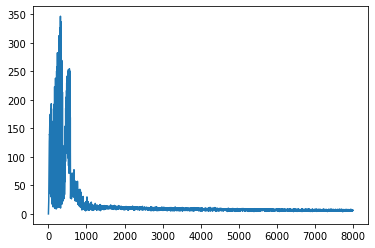

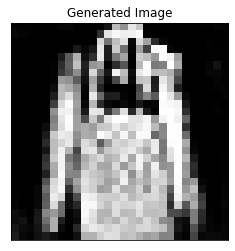

Iteration [8001/10000]......0.121(s) gen: -265.77319 - critic_fake: 265.52826 - critic_real: 271.37290 - neg_critic: 5.84464
Iteration [8002/10000]......0.113(s) gen: -264.25195 - critic_fake: 265.58342 - critic_real: 271.99086 - neg_critic: 6.40745
Iteration [8003/10000]......0.115(s) gen: -267.09894 - critic_fake: 265.11594 - critic_real: 272.25658 - neg_critic: 7.14064
Iteration [8004/10000]......0.116(s) gen: -263.49222 - critic_fake: 267.03746 - critic_real: 272.86388 - neg_critic: 5.82642
Iteration [8005/10000]......0.114(s) gen: -264.62170 - critic_fake: 264.56035 - critic_real: 272.02603 - neg_critic: 7.46568
Iteration [8006/10000]......0.114(s) gen: -266.02795 - critic_fake: 264.96033 - critic_real: 271.69382 - neg_critic: 6.73349
Iteration [8007/10000]......0.115(s) gen: -263.73746 - critic_fake: 264.41638 - critic_real: 271.22966 - neg_critic: 6.81328
Iteration [8008/10000]......0.117(s) gen: -265.26263 - critic_fake: 265.22580 - critic_real: 271.94889 - neg_critic: 6.72309


Iteration [8068/10000]......0.121(s) gen: -267.99988 - critic_fake: 264.92886 - critic_real: 272.00016 - neg_critic: 7.07130
Iteration [8069/10000]......0.121(s) gen: -267.41290 - critic_fake: 267.64450 - critic_real: 271.54572 - neg_critic: 3.90122
Iteration [8070/10000]......0.119(s) gen: -266.60193 - critic_fake: 266.54532 - critic_real: 271.58681 - neg_critic: 5.04149
Iteration [8071/10000]......0.122(s) gen: -266.18039 - critic_fake: 266.58474 - critic_real: 272.44555 - neg_critic: 5.86081
Iteration [8072/10000]......0.122(s) gen: -265.91028 - critic_fake: 265.63687 - critic_real: 272.82689 - neg_critic: 7.19001
Iteration [8073/10000]......0.124(s) gen: -264.54053 - critic_fake: 266.24591 - critic_real: 272.63708 - neg_critic: 6.39117
Iteration [8074/10000]......0.122(s) gen: -266.54047 - critic_fake: 265.97089 - critic_real: 273.18987 - neg_critic: 7.21898
Iteration [8075/10000]......0.120(s) gen: -263.99829 - critic_fake: 265.36160 - critic_real: 272.85834 - neg_critic: 7.49673


Iteration [8134/10000]......0.142(s) gen: -267.68826 - critic_fake: 265.42337 - critic_real: 273.60634 - neg_critic: 8.18297
Iteration [8135/10000]......0.118(s) gen: -265.63913 - critic_fake: 267.67307 - critic_real: 273.11651 - neg_critic: 5.44344
Iteration [8136/10000]......0.118(s) gen: -265.39944 - critic_fake: 266.10203 - critic_real: 272.97949 - neg_critic: 6.87746
Iteration [8137/10000]......0.117(s) gen: -267.35101 - critic_fake: 266.89697 - critic_real: 273.23393 - neg_critic: 6.33696
Iteration [8138/10000]......0.118(s) gen: -265.14328 - critic_fake: 267.03539 - critic_real: 273.59382 - neg_critic: 6.55844
Iteration [8139/10000]......0.119(s) gen: -267.79065 - critic_fake: 266.00693 - critic_real: 273.56413 - neg_critic: 7.55720
Iteration [8140/10000]......0.120(s) gen: -268.40759 - critic_fake: 267.48788 - critic_real: 273.83950 - neg_critic: 6.35162
Iteration [8141/10000]......0.119(s) gen: -267.05811 - critic_fake: 267.10501 - critic_real: 273.96301 - neg_critic: 6.85800


Iteration [8200/10000]......0.124(s) gen: -266.94754 - critic_fake: 267.56339 - critic_real: 273.38420 - neg_critic: 5.82081
Iteration [8201/10000]......0.125(s) gen: -268.22885 - critic_fake: 266.07876 - critic_real: 272.89245 - neg_critic: 6.81369
Iteration [8202/10000]......0.125(s) gen: -267.11572 - critic_fake: 267.61906 - critic_real: 273.40885 - neg_critic: 5.78979
Iteration [8203/10000]......0.124(s) gen: -267.97711 - critic_fake: 267.24623 - critic_real: 273.47794 - neg_critic: 6.23171
Iteration [8204/10000]......0.125(s) gen: -267.07690 - critic_fake: 267.14423 - critic_real: 273.99082 - neg_critic: 6.84659
Iteration [8205/10000]......0.124(s) gen: -266.61703 - critic_fake: 267.29629 - critic_real: 273.54528 - neg_critic: 6.24899
Iteration [8206/10000]......0.124(s) gen: -269.35974 - critic_fake: 267.08473 - critic_real: 274.10119 - neg_critic: 7.01646
Iteration [8207/10000]......0.122(s) gen: -267.17944 - critic_fake: 268.30512 - critic_real: 274.19709 - neg_critic: 5.89197


Iteration [8266/10000]......0.123(s) gen: -264.56082 - critic_fake: 267.52818 - critic_real: 274.60682 - neg_critic: 7.07864
Iteration [8267/10000]......0.124(s) gen: -267.90350 - critic_fake: 268.05656 - critic_real: 274.97838 - neg_critic: 6.92183
Iteration [8268/10000]......0.123(s) gen: -265.40213 - critic_fake: 267.50617 - critic_real: 275.32310 - neg_critic: 7.81693
Iteration [8269/10000]......0.122(s) gen: -264.97278 - critic_fake: 266.85611 - critic_real: 274.24147 - neg_critic: 7.38536
Iteration [8270/10000]......0.121(s) gen: -268.27094 - critic_fake: 267.08935 - critic_real: 274.49522 - neg_critic: 7.40587
Iteration [8271/10000]......0.120(s) gen: -266.11871 - critic_fake: 266.61202 - critic_real: 274.09703 - neg_critic: 7.48501
Iteration [8272/10000]......0.119(s) gen: -268.76965 - critic_fake: 267.19175 - critic_real: 274.19083 - neg_critic: 6.99907
Iteration [8273/10000]......0.118(s) gen: -268.48138 - critic_fake: 269.17928 - critic_real: 274.69601 - neg_critic: 5.51673


Iteration [8332/10000]......0.121(s) gen: -267.54169 - critic_fake: 268.66449 - critic_real: 275.08642 - neg_critic: 6.42193
Iteration [8333/10000]......0.119(s) gen: -268.56815 - critic_fake: 267.26981 - critic_real: 274.97017 - neg_critic: 7.70037
Iteration [8334/10000]......0.123(s) gen: -266.69705 - critic_fake: 268.76841 - critic_real: 274.78819 - neg_critic: 6.01978
Iteration [8335/10000]......0.123(s) gen: -268.98981 - critic_fake: 269.33080 - critic_real: 274.96835 - neg_critic: 5.63755
Iteration [8336/10000]......0.123(s) gen: -269.18805 - critic_fake: 269.08508 - critic_real: 275.12325 - neg_critic: 6.03817
Iteration [8337/10000]......0.122(s) gen: -266.49078 - critic_fake: 268.82486 - critic_real: 275.02885 - neg_critic: 6.20399
Iteration [8338/10000]......0.123(s) gen: -269.63385 - critic_fake: 267.71414 - critic_real: 274.75806 - neg_critic: 7.04392
Iteration [8339/10000]......0.123(s) gen: -268.81061 - critic_fake: 269.72029 - critic_real: 274.81589 - neg_critic: 5.09561


Iteration [8398/10000]......0.120(s) gen: -267.53516 - critic_fake: 268.63099 - critic_real: 275.58106 - neg_critic: 6.95007
Iteration [8399/10000]......0.121(s) gen: -267.74194 - critic_fake: 268.26151 - critic_real: 274.83035 - neg_critic: 6.56884
Iteration [8400/10000]......0.122(s) gen: -268.37863 - critic_fake: 269.24257 - critic_real: 275.38063 - neg_critic: 6.13807
Iteration [8401/10000]......0.122(s) gen: -268.94080 - critic_fake: 268.89654 - critic_real: 275.48046 - neg_critic: 6.58392
Iteration [8402/10000]......0.121(s) gen: -268.55005 - critic_fake: 268.96327 - critic_real: 275.52351 - neg_critic: 6.56024
Iteration [8403/10000]......0.120(s) gen: -267.27631 - critic_fake: 269.21778 - critic_real: 275.13273 - neg_critic: 5.91495
Iteration [8404/10000]......0.120(s) gen: -269.10748 - critic_fake: 268.88595 - critic_real: 275.77648 - neg_critic: 6.89053
Iteration [8405/10000]......0.122(s) gen: -270.36945 - critic_fake: 269.69890 - critic_real: 276.16478 - neg_critic: 6.46588


Iteration [8464/10000]......0.124(s) gen: -271.27814 - critic_fake: 269.89481 - critic_real: 276.82112 - neg_critic: 6.92632
Iteration [8465/10000]......0.122(s) gen: -269.64862 - critic_fake: 270.20202 - critic_real: 276.16701 - neg_critic: 5.96499
Iteration [8466/10000]......0.120(s) gen: -268.48553 - critic_fake: 269.68776 - critic_real: 275.44564 - neg_critic: 5.75789
Iteration [8467/10000]......0.119(s) gen: -269.91800 - critic_fake: 269.19163 - critic_real: 275.39595 - neg_critic: 6.20432
Iteration [8468/10000]......0.117(s) gen: -269.41183 - critic_fake: 268.74617 - critic_real: 274.94893 - neg_critic: 6.20276
Iteration [8469/10000]......0.117(s) gen: -270.73621 - critic_fake: 269.42409 - critic_real: 275.66322 - neg_critic: 6.23913
Iteration [8470/10000]......0.118(s) gen: -267.54095 - critic_fake: 269.28494 - critic_real: 276.10551 - neg_critic: 6.82057
Iteration [8471/10000]......0.119(s) gen: -268.99799 - critic_fake: 270.00043 - critic_real: 275.72778 - neg_critic: 5.72736


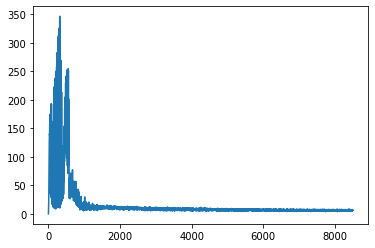

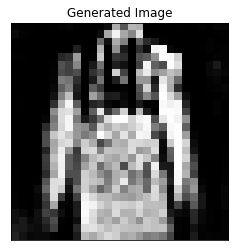

Iteration [8501/10000]......0.115(s) gen: -270.35217 - critic_fake: 269.40096 - critic_real: 276.35897 - neg_critic: 6.95801
Iteration [8502/10000]......0.114(s) gen: -269.72229 - critic_fake: 269.65436 - critic_real: 275.57412 - neg_critic: 5.91976
Iteration [8503/10000]......0.113(s) gen: -269.08612 - critic_fake: 269.38182 - critic_real: 276.08679 - neg_critic: 6.70497
Iteration [8504/10000]......0.114(s) gen: -269.29578 - critic_fake: 270.14926 - critic_real: 276.47768 - neg_critic: 6.32842
Iteration [8505/10000]......0.113(s) gen: -270.36768 - critic_fake: 269.76219 - critic_real: 276.87960 - neg_critic: 7.11741
Iteration [8506/10000]......0.114(s) gen: -269.96179 - critic_fake: 269.02283 - critic_real: 275.93824 - neg_critic: 6.91541
Iteration [8507/10000]......0.116(s) gen: -267.59845 - critic_fake: 269.69878 - critic_real: 275.66978 - neg_critic: 5.97100
Iteration [8508/10000]......0.116(s) gen: -270.93713 - critic_fake: 269.85400 - critic_real: 276.14775 - neg_critic: 6.29376


Iteration [8567/10000]......0.120(s) gen: -269.57477 - critic_fake: 270.34981 - critic_real: 277.36780 - neg_critic: 7.01799
Iteration [8568/10000]......0.122(s) gen: -271.77884 - critic_fake: 270.84697 - critic_real: 277.07950 - neg_critic: 6.23253
Iteration [8569/10000]......0.123(s) gen: -271.25342 - critic_fake: 271.52976 - critic_real: 276.82070 - neg_critic: 5.29094
Iteration [8570/10000]......0.127(s) gen: -271.57153 - critic_fake: 270.44726 - critic_real: 276.83187 - neg_critic: 6.38461
Iteration [8571/10000]......0.124(s) gen: -270.50873 - critic_fake: 270.34755 - critic_real: 276.98312 - neg_critic: 6.63558
Iteration [8572/10000]......0.124(s) gen: -269.90414 - critic_fake: 270.83959 - critic_real: 276.98746 - neg_critic: 6.14786
Iteration [8573/10000]......0.124(s) gen: -270.75150 - critic_fake: 271.12230 - critic_real: 277.20483 - neg_critic: 6.08253
Iteration [8574/10000]......0.122(s) gen: -271.08771 - critic_fake: 270.62816 - critic_real: 277.22505 - neg_critic: 6.59689


Iteration [8633/10000]......0.122(s) gen: -271.73981 - critic_fake: 271.22798 - critic_real: 277.60451 - neg_critic: 6.37653
Iteration [8634/10000]......0.124(s) gen: -271.19376 - critic_fake: 271.36398 - critic_real: 276.83918 - neg_critic: 5.47520
Iteration [8635/10000]......0.121(s) gen: -269.53351 - critic_fake: 270.93157 - critic_real: 276.77931 - neg_critic: 5.84774
Iteration [8636/10000]......0.122(s) gen: -272.98141 - critic_fake: 272.10793 - critic_real: 278.03539 - neg_critic: 5.92746
Iteration [8637/10000]......0.121(s) gen: -271.64673 - critic_fake: 272.87312 - critic_real: 278.18098 - neg_critic: 5.30786
Iteration [8638/10000]......0.123(s) gen: -269.77902 - critic_fake: 271.63205 - critic_real: 278.46314 - neg_critic: 6.83109
Iteration [8639/10000]......0.124(s) gen: -272.67554 - critic_fake: 271.93658 - critic_real: 278.17433 - neg_critic: 6.23776
Iteration [8640/10000]......0.125(s) gen: -270.54172 - critic_fake: 271.51444 - critic_real: 277.65198 - neg_critic: 6.13754


Iteration [8699/10000]......0.123(s) gen: -269.79443 - critic_fake: 271.91549 - critic_real: 278.80451 - neg_critic: 6.88902
Iteration [8700/10000]......0.125(s) gen: -273.47177 - critic_fake: 271.66788 - critic_real: 278.05193 - neg_critic: 6.38406
Iteration [8701/10000]......0.127(s) gen: -272.09143 - critic_fake: 273.06380 - critic_real: 278.31520 - neg_critic: 5.25140
Iteration [8702/10000]......0.139(s) gen: -271.95404 - critic_fake: 272.08655 - critic_real: 277.84153 - neg_critic: 5.75498
Iteration [8703/10000]......0.126(s) gen: -273.14444 - critic_fake: 272.07445 - critic_real: 278.64779 - neg_critic: 6.57334
Iteration [8704/10000]......0.122(s) gen: -272.96100 - critic_fake: 270.80903 - critic_real: 278.22254 - neg_critic: 7.41351
Iteration [8705/10000]......0.125(s) gen: -269.35898 - critic_fake: 271.92177 - critic_real: 278.05381 - neg_critic: 6.13204
Iteration [8706/10000]......0.126(s) gen: -272.58835 - critic_fake: 270.93836 - critic_real: 277.91957 - neg_critic: 6.98121


Iteration [8765/10000]......0.123(s) gen: -273.47400 - critic_fake: 273.34944 - critic_real: 278.87727 - neg_critic: 5.52783
Iteration [8766/10000]......0.124(s) gen: -272.88049 - critic_fake: 273.02368 - critic_real: 278.66299 - neg_critic: 5.63932
Iteration [8767/10000]......0.124(s) gen: -273.77435 - critic_fake: 273.43331 - critic_real: 279.34017 - neg_critic: 5.90686
Iteration [8768/10000]......0.124(s) gen: -271.35876 - critic_fake: 272.79280 - critic_real: 278.78257 - neg_critic: 5.98978
Iteration [8769/10000]......0.124(s) gen: -273.31534 - critic_fake: 273.05448 - critic_real: 278.67914 - neg_critic: 5.62466
Iteration [8770/10000]......0.123(s) gen: -273.46307 - critic_fake: 273.37373 - critic_real: 279.39705 - neg_critic: 6.02332
Iteration [8771/10000]......0.124(s) gen: -272.66980 - critic_fake: 272.83343 - critic_real: 278.89014 - neg_critic: 6.05671
Iteration [8772/10000]......0.122(s) gen: -271.64355 - critic_fake: 273.50108 - critic_real: 279.60804 - neg_critic: 6.10696


Iteration [8831/10000]......0.121(s) gen: -273.12091 - critic_fake: 273.90728 - critic_real: 279.92111 - neg_critic: 6.01383
Iteration [8832/10000]......0.120(s) gen: -274.99280 - critic_fake: 273.01457 - critic_real: 280.36470 - neg_critic: 7.35013
Iteration [8833/10000]......0.121(s) gen: -274.77606 - critic_fake: 275.48893 - critic_real: 280.41477 - neg_critic: 4.92584
Iteration [8834/10000]......0.122(s) gen: -274.35226 - critic_fake: 274.12297 - critic_real: 280.29238 - neg_critic: 6.16941
Iteration [8835/10000]......0.123(s) gen: -275.48230 - critic_fake: 274.20567 - critic_real: 279.92668 - neg_critic: 5.72101
Iteration [8836/10000]......0.122(s) gen: -272.13190 - critic_fake: 274.98265 - critic_real: 280.78834 - neg_critic: 5.80569
Iteration [8837/10000]......0.125(s) gen: -274.14426 - critic_fake: 272.86849 - critic_real: 280.24131 - neg_critic: 7.37282
Iteration [8838/10000]......0.126(s) gen: -274.27396 - critic_fake: 274.00732 - critic_real: 280.46005 - neg_critic: 6.45273


Iteration [8897/10000]......0.120(s) gen: -276.88977 - critic_fake: 275.98330 - critic_real: 281.26931 - neg_critic: 5.28601
Iteration [8898/10000]......0.120(s) gen: -274.29666 - critic_fake: 275.77159 - critic_real: 281.67379 - neg_critic: 5.90220
Iteration [8899/10000]......0.120(s) gen: -277.00000 - critic_fake: 273.37055 - critic_real: 280.84321 - neg_critic: 7.47266
Iteration [8900/10000]......0.124(s) gen: -275.34747 - critic_fake: 276.14819 - critic_real: 281.32350 - neg_critic: 5.17531
Iteration [8901/10000]......0.125(s) gen: -275.05908 - critic_fake: 275.10087 - critic_real: 280.97316 - neg_critic: 5.87229
Iteration [8902/10000]......0.120(s) gen: -272.37051 - critic_fake: 273.18347 - critic_real: 280.29366 - neg_critic: 7.11019
Iteration [8903/10000]......0.120(s) gen: -276.02139 - critic_fake: 274.24283 - critic_real: 280.17031 - neg_critic: 5.92747
Iteration [8904/10000]......0.120(s) gen: -274.12701 - critic_fake: 275.51616 - critic_real: 281.00007 - neg_critic: 5.48391


Iteration [8963/10000]......0.119(s) gen: -275.43311 - critic_fake: 275.35610 - critic_real: 281.28203 - neg_critic: 5.92593
Iteration [8964/10000]......0.119(s) gen: -274.97336 - critic_fake: 274.39965 - critic_real: 280.76369 - neg_critic: 6.36404
Iteration [8965/10000]......0.117(s) gen: -274.70880 - critic_fake: 274.10488 - critic_real: 281.46360 - neg_critic: 7.35872
Iteration [8966/10000]......0.119(s) gen: -275.76572 - critic_fake: 275.14458 - critic_real: 281.09033 - neg_critic: 5.94575
Iteration [8967/10000]......0.119(s) gen: -274.95331 - critic_fake: 274.10023 - critic_real: 280.96248 - neg_critic: 6.86224
Iteration [8968/10000]......0.117(s) gen: -275.33551 - critic_fake: 275.02211 - critic_real: 281.54966 - neg_critic: 6.52755
Iteration [8969/10000]......0.120(s) gen: -277.31372 - critic_fake: 275.94888 - critic_real: 282.28818 - neg_critic: 6.33929
Iteration [8970/10000]......0.120(s) gen: -274.65210 - critic_fake: 276.76608 - critic_real: 282.34353 - neg_critic: 5.57745


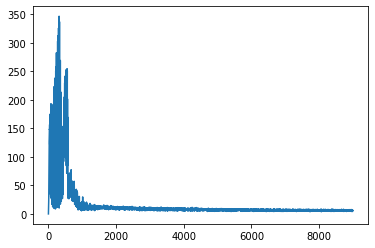

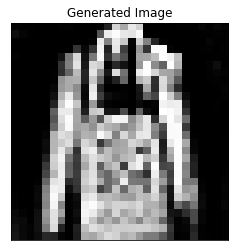

Iteration [9001/10000]......0.113(s) gen: -273.86557 - critic_fake: 275.93926 - critic_real: 282.72915 - neg_critic: 6.78989
Iteration [9002/10000]......0.114(s) gen: -275.53812 - critic_fake: 276.24492 - critic_real: 282.63211 - neg_critic: 6.38719
Iteration [9003/10000]......0.115(s) gen: -275.16626 - critic_fake: 277.12044 - critic_real: 282.36274 - neg_critic: 5.24230
Iteration [9004/10000]......0.117(s) gen: -277.69440 - critic_fake: 275.92533 - critic_real: 282.35963 - neg_critic: 6.43430
Iteration [9005/10000]......0.115(s) gen: -276.20538 - critic_fake: 276.71809 - critic_real: 282.79506 - neg_critic: 6.07697
Iteration [9006/10000]......0.116(s) gen: -277.35352 - critic_fake: 276.09691 - critic_real: 282.08340 - neg_critic: 5.98650
Iteration [9007/10000]......0.117(s) gen: -274.71332 - critic_fake: 276.42214 - critic_real: 281.88642 - neg_critic: 5.46428
Iteration [9008/10000]......0.117(s) gen: -276.78308 - critic_fake: 275.49117 - critic_real: 281.68548 - neg_critic: 6.19431


Iteration [9068/10000]......0.123(s) gen: -275.80780 - critic_fake: 275.87626 - critic_real: 282.90615 - neg_critic: 7.02989
Iteration [9069/10000]......0.123(s) gen: -276.31180 - critic_fake: 276.56942 - critic_real: 283.04995 - neg_critic: 6.48054
Iteration [9070/10000]......0.122(s) gen: -275.62531 - critic_fake: 276.55245 - critic_real: 282.87060 - neg_critic: 6.31815
Iteration [9071/10000]......0.122(s) gen: -278.09546 - critic_fake: 276.15056 - critic_real: 282.68450 - neg_critic: 6.53394
Iteration [9072/10000]......0.121(s) gen: -277.81860 - critic_fake: 277.06362 - critic_real: 282.79901 - neg_critic: 5.73539
Iteration [9073/10000]......0.121(s) gen: -275.46991 - critic_fake: 276.50091 - critic_real: 282.60620 - neg_critic: 6.10529
Iteration [9074/10000]......0.121(s) gen: -277.05426 - critic_fake: 274.96054 - critic_real: 282.37049 - neg_critic: 7.40995
Iteration [9075/10000]......0.119(s) gen: -275.20721 - critic_fake: 275.65990 - critic_real: 282.76972 - neg_critic: 7.10982


Iteration [9134/10000]......0.120(s) gen: -277.65622 - critic_fake: 276.61434 - critic_real: 282.75204 - neg_critic: 6.13770
Iteration [9135/10000]......0.120(s) gen: -277.75262 - critic_fake: 276.34482 - critic_real: 283.08757 - neg_critic: 6.74275
Iteration [9136/10000]......0.120(s) gen: -275.09021 - critic_fake: 276.36617 - critic_real: 283.07819 - neg_critic: 6.71202
Iteration [9137/10000]......0.119(s) gen: -278.07733 - critic_fake: 276.29629 - critic_real: 283.36472 - neg_critic: 7.06843
Iteration [9138/10000]......0.120(s) gen: -275.88657 - critic_fake: 277.41086 - critic_real: 283.71233 - neg_critic: 6.30147
Iteration [9139/10000]......0.120(s) gen: -277.31094 - critic_fake: 276.98243 - critic_real: 283.21796 - neg_critic: 6.23552
Iteration [9140/10000]......0.120(s) gen: -275.90839 - critic_fake: 277.08705 - critic_real: 283.48156 - neg_critic: 6.39451
Iteration [9141/10000]......0.120(s) gen: -278.33273 - critic_fake: 276.98259 - critic_real: 283.41145 - neg_critic: 6.42886


Iteration [9200/10000]......0.125(s) gen: -277.87781 - critic_fake: 277.13961 - critic_real: 284.13645 - neg_critic: 6.99684
Iteration [9201/10000]......0.125(s) gen: -278.75027 - critic_fake: 277.98062 - critic_real: 284.59227 - neg_critic: 6.61166
Iteration [9202/10000]......0.125(s) gen: -279.95364 - critic_fake: 279.23206 - critic_real: 284.72761 - neg_critic: 5.49556
Iteration [9203/10000]......0.125(s) gen: -278.32059 - critic_fake: 278.04542 - critic_real: 284.51096 - neg_critic: 6.46554
Iteration [9204/10000]......0.125(s) gen: -278.12167 - critic_fake: 278.23799 - critic_real: 284.46570 - neg_critic: 6.22771
Iteration [9205/10000]......0.124(s) gen: -277.60989 - critic_fake: 278.25387 - critic_real: 284.59424 - neg_critic: 6.34037
Iteration [9206/10000]......0.127(s) gen: -278.69019 - critic_fake: 278.55435 - critic_real: 284.34694 - neg_critic: 5.79259
Iteration [9207/10000]......0.123(s) gen: -276.26935 - critic_fake: 278.36285 - critic_real: 283.92009 - neg_critic: 5.55724


Iteration [9266/10000]......0.123(s) gen: -278.31598 - critic_fake: 277.52682 - critic_real: 285.03379 - neg_critic: 7.50697
Iteration [9267/10000]......0.124(s) gen: -277.32269 - critic_fake: 277.89524 - critic_real: 284.68784 - neg_critic: 6.79260
Iteration [9268/10000]......0.126(s) gen: -279.52579 - critic_fake: 279.10983 - critic_real: 285.31821 - neg_critic: 6.20839
Iteration [9269/10000]......0.127(s) gen: -278.95886 - critic_fake: 279.88901 - critic_real: 285.65870 - neg_critic: 5.76969
Iteration [9270/10000]......0.125(s) gen: -278.63531 - critic_fake: 278.82986 - critic_real: 285.20165 - neg_critic: 6.37180
Iteration [9271/10000]......0.125(s) gen: -279.64545 - critic_fake: 278.24371 - critic_real: 284.78024 - neg_critic: 6.53653
Iteration [9272/10000]......0.125(s) gen: -278.68079 - critic_fake: 278.35879 - critic_real: 283.92650 - neg_critic: 5.56771
Iteration [9273/10000]......0.123(s) gen: -277.14407 - critic_fake: 278.07512 - critic_real: 284.34915 - neg_critic: 6.27402


Iteration [9332/10000]......0.121(s) gen: -279.43512 - critic_fake: 279.06597 - critic_real: 285.38937 - neg_critic: 6.32341
Iteration [9333/10000]......0.122(s) gen: -279.30020 - critic_fake: 278.38013 - critic_real: 284.71574 - neg_critic: 6.33561
Iteration [9334/10000]......0.122(s) gen: -279.38889 - critic_fake: 279.58753 - critic_real: 285.03823 - neg_critic: 5.45070
Iteration [9335/10000]......0.122(s) gen: -279.80383 - critic_fake: 279.16436 - critic_real: 285.87606 - neg_critic: 6.71170
Iteration [9336/10000]......0.120(s) gen: -281.13663 - critic_fake: 279.63303 - critic_real: 286.22402 - neg_critic: 6.59100
Iteration [9337/10000]......0.120(s) gen: -280.97815 - critic_fake: 280.04060 - critic_real: 286.53710 - neg_critic: 6.49650
Iteration [9338/10000]......0.118(s) gen: -280.81842 - critic_fake: 280.59203 - critic_real: 286.14388 - neg_critic: 5.55184
Iteration [9339/10000]......0.118(s) gen: -279.44138 - critic_fake: 278.60574 - critic_real: 285.73162 - neg_critic: 7.12589


Iteration [9398/10000]......0.122(s) gen: -279.82214 - critic_fake: 280.38514 - critic_real: 286.01700 - neg_critic: 5.63185
Iteration [9399/10000]......0.121(s) gen: -279.47806 - critic_fake: 280.15680 - critic_real: 285.52991 - neg_critic: 5.37311
Iteration [9400/10000]......0.121(s) gen: -280.42462 - critic_fake: 278.85019 - critic_real: 286.18389 - neg_critic: 7.33370
Iteration [9401/10000]......0.121(s) gen: -280.85236 - critic_fake: 280.89647 - critic_real: 286.29310 - neg_critic: 5.39663
Iteration [9402/10000]......0.119(s) gen: -279.13477 - critic_fake: 280.32394 - critic_real: 285.70206 - neg_critic: 5.37812
Iteration [9403/10000]......0.125(s) gen: -281.09323 - critic_fake: 279.41003 - critic_real: 285.98098 - neg_critic: 6.57095
Iteration [9404/10000]......0.122(s) gen: -279.43304 - critic_fake: 280.36496 - critic_real: 285.43771 - neg_critic: 5.07275
Iteration [9405/10000]......0.121(s) gen: -279.32770 - critic_fake: 279.65196 - critic_real: 285.90125 - neg_critic: 6.24929


Iteration [9464/10000]......0.127(s) gen: -281.25122 - critic_fake: 280.98422 - critic_real: 286.66922 - neg_critic: 5.68500
Iteration [9465/10000]......0.126(s) gen: -279.34302 - critic_fake: 281.05033 - critic_real: 286.64515 - neg_critic: 5.59482
Iteration [9466/10000]......0.124(s) gen: -281.60461 - critic_fake: 280.84196 - critic_real: 286.76023 - neg_critic: 5.91827
Iteration [9467/10000]......0.123(s) gen: -279.35138 - critic_fake: 279.90500 - critic_real: 286.23860 - neg_critic: 6.33361
Iteration [9468/10000]......0.126(s) gen: -278.83911 - critic_fake: 279.56273 - critic_real: 286.15463 - neg_critic: 6.59190
Iteration [9469/10000]......0.126(s) gen: -281.55627 - critic_fake: 278.78827 - critic_real: 286.16735 - neg_critic: 7.37908
Iteration [9470/10000]......0.123(s) gen: -280.80783 - critic_fake: 281.41462 - critic_real: 287.22239 - neg_critic: 5.80778
Iteration [9471/10000]......0.120(s) gen: -281.60406 - critic_fake: 280.66744 - critic_real: 286.97615 - neg_critic: 6.30870


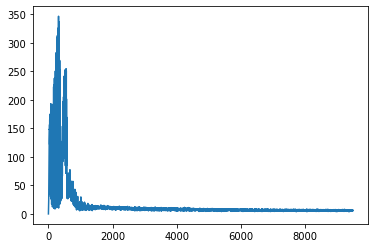

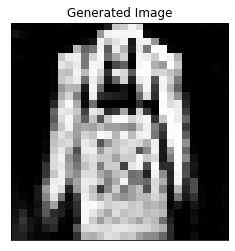

Iteration [9501/10000]......0.129(s) gen: -280.96387 - critic_fake: 280.41000 - critic_real: 287.47553 - neg_critic: 7.06553
Iteration [9502/10000]......0.123(s) gen: -281.72794 - critic_fake: 279.77125 - critic_real: 287.14713 - neg_critic: 7.37588
Iteration [9503/10000]......0.120(s) gen: -281.02814 - critic_fake: 282.30933 - critic_real: 287.75693 - neg_critic: 5.44761
Iteration [9504/10000]......0.120(s) gen: -282.44354 - critic_fake: 280.61348 - critic_real: 287.61740 - neg_critic: 7.00392
Iteration [9505/10000]......0.120(s) gen: -280.72293 - critic_fake: 281.13900 - critic_real: 287.37479 - neg_critic: 6.23579
Iteration [9506/10000]......0.122(s) gen: -281.01514 - critic_fake: 281.59133 - critic_real: 287.47604 - neg_critic: 5.88470
Iteration [9507/10000]......0.123(s) gen: -280.81052 - critic_fake: 280.26550 - critic_real: 287.54479 - neg_critic: 7.27928
Iteration [9508/10000]......0.123(s) gen: -279.38257 - critic_fake: 280.68539 - critic_real: 287.08602 - neg_critic: 6.40063


Iteration [9567/10000]......0.121(s) gen: -281.42645 - critic_fake: 282.47560 - critic_real: 288.45519 - neg_critic: 5.97959
Iteration [9568/10000]......0.120(s) gen: -282.52234 - critic_fake: 282.26335 - critic_real: 287.93758 - neg_critic: 5.67423
Iteration [9569/10000]......0.119(s) gen: -281.28922 - critic_fake: 282.33554 - critic_real: 288.24387 - neg_critic: 5.90833
Iteration [9570/10000]......0.122(s) gen: -280.57837 - critic_fake: 281.71313 - critic_real: 288.16835 - neg_critic: 6.45521
Iteration [9571/10000]......0.125(s) gen: -282.32788 - critic_fake: 282.06049 - critic_real: 288.02018 - neg_critic: 5.95969
Iteration [9572/10000]......0.128(s) gen: -283.67694 - critic_fake: 283.23290 - critic_real: 288.48953 - neg_critic: 5.25663
Iteration [9573/10000]......0.127(s) gen: -283.26999 - critic_fake: 281.44031 - critic_real: 288.22339 - neg_critic: 6.78308
Iteration [9574/10000]......0.126(s) gen: -282.81317 - critic_fake: 283.12782 - critic_real: 287.89500 - neg_critic: 4.76718


Iteration [9633/10000]......0.123(s) gen: -281.80164 - critic_fake: 282.64557 - critic_real: 288.99354 - neg_critic: 6.34796
Iteration [9634/10000]......0.121(s) gen: -282.39935 - critic_fake: 282.85634 - critic_real: 289.10159 - neg_critic: 6.24526
Iteration [9635/10000]......0.126(s) gen: -282.01013 - critic_fake: 283.74417 - critic_real: 289.51772 - neg_critic: 5.77355
Iteration [9636/10000]......0.125(s) gen: -283.90598 - critic_fake: 282.30330 - critic_real: 289.39990 - neg_critic: 7.09660
Iteration [9637/10000]......0.121(s) gen: -281.76764 - critic_fake: 282.89464 - critic_real: 289.48042 - neg_critic: 6.58578
Iteration [9638/10000]......0.122(s) gen: -283.47006 - critic_fake: 283.39982 - critic_real: 289.49539 - neg_critic: 6.09557
Iteration [9639/10000]......0.121(s) gen: -284.17474 - critic_fake: 283.99361 - critic_real: 290.17769 - neg_critic: 6.18408
Iteration [9640/10000]......0.120(s) gen: -283.82153 - critic_fake: 283.50906 - critic_real: 289.60235 - neg_critic: 6.09329


Iteration [9699/10000]......0.121(s) gen: -282.23663 - critic_fake: 283.86823 - critic_real: 289.48801 - neg_critic: 5.61978
Iteration [9700/10000]......0.121(s) gen: -281.95682 - critic_fake: 283.04532 - critic_real: 289.00676 - neg_critic: 5.96143
Iteration [9701/10000]......0.120(s) gen: -284.68631 - critic_fake: 283.88497 - critic_real: 289.47741 - neg_critic: 5.59244
Iteration [9702/10000]......0.120(s) gen: -284.64700 - critic_fake: 284.01243 - critic_real: 290.34399 - neg_critic: 6.33156
Iteration [9703/10000]......0.121(s) gen: -283.17917 - critic_fake: 284.09943 - critic_real: 290.00577 - neg_critic: 5.90634
Iteration [9704/10000]......0.123(s) gen: -283.33777 - critic_fake: 284.37405 - critic_real: 290.04424 - neg_critic: 5.67020
Iteration [9705/10000]......0.122(s) gen: -284.91675 - critic_fake: 284.00759 - critic_real: 290.14700 - neg_critic: 6.13940
Iteration [9706/10000]......0.121(s) gen: -283.78156 - critic_fake: 284.69687 - critic_real: 290.28353 - neg_critic: 5.58666


Iteration [9765/10000]......0.123(s) gen: -283.52863 - critic_fake: 284.09446 - critic_real: 290.18212 - neg_critic: 6.08765
Iteration [9766/10000]......0.125(s) gen: -285.06085 - critic_fake: 283.49245 - critic_real: 289.86025 - neg_critic: 6.36780
Iteration [9767/10000]......0.123(s) gen: -283.15106 - critic_fake: 284.59709 - critic_real: 289.87252 - neg_critic: 5.27543
Iteration [9768/10000]......0.122(s) gen: -283.24048 - critic_fake: 284.56948 - critic_real: 290.00815 - neg_critic: 5.43867
Iteration [9769/10000]......0.121(s) gen: -282.92883 - critic_fake: 283.69747 - critic_real: 290.04235 - neg_critic: 6.34487
Iteration [9770/10000]......0.120(s) gen: -283.36795 - critic_fake: 283.32821 - critic_real: 289.89254 - neg_critic: 6.56432
Iteration [9771/10000]......0.119(s) gen: -285.16748 - critic_fake: 284.53106 - critic_real: 290.22636 - neg_critic: 5.69530
Iteration [9772/10000]......0.120(s) gen: -283.58337 - critic_fake: 283.41672 - critic_real: 290.21862 - neg_critic: 6.80190


Iteration [9831/10000]......0.121(s) gen: -284.68909 - critic_fake: 283.95371 - critic_real: 291.26318 - neg_critic: 7.30947
Iteration [9832/10000]......0.121(s) gen: -284.27356 - critic_fake: 284.60359 - critic_real: 291.18641 - neg_critic: 6.58282
Iteration [9833/10000]......0.121(s) gen: -285.95721 - critic_fake: 284.36396 - critic_real: 291.35336 - neg_critic: 6.98939
Iteration [9834/10000]......0.121(s) gen: -286.02963 - critic_fake: 285.80295 - critic_real: 291.76673 - neg_critic: 5.96378
Iteration [9835/10000]......0.121(s) gen: -286.80490 - critic_fake: 285.86804 - critic_real: 291.16229 - neg_critic: 5.29426
Iteration [9836/10000]......0.121(s) gen: -285.65894 - critic_fake: 285.71329 - critic_real: 291.33549 - neg_critic: 5.62219
Iteration [9837/10000]......0.121(s) gen: -286.52301 - critic_fake: 286.13847 - critic_real: 291.00746 - neg_critic: 4.86899
Iteration [9838/10000]......0.121(s) gen: -284.88248 - critic_fake: 284.93309 - critic_real: 290.74851 - neg_critic: 5.81542


Iteration [9897/10000]......0.118(s) gen: -286.16040 - critic_fake: 286.34771 - critic_real: 291.93047 - neg_critic: 5.58277
Iteration [9898/10000]......0.120(s) gen: -285.89185 - critic_fake: 285.97513 - critic_real: 291.92365 - neg_critic: 5.94851
Iteration [9899/10000]......0.120(s) gen: -286.31216 - critic_fake: 285.31740 - critic_real: 291.83610 - neg_critic: 6.51870
Iteration [9900/10000]......0.119(s) gen: -284.81665 - critic_fake: 286.32734 - critic_real: 292.20511 - neg_critic: 5.87776
Iteration [9901/10000]......0.127(s) gen: -286.84274 - critic_fake: 286.14343 - critic_real: 291.89595 - neg_critic: 5.75252
Iteration [9902/10000]......0.119(s) gen: -286.26654 - critic_fake: 285.77836 - critic_real: 291.88543 - neg_critic: 6.10707
Iteration [9903/10000]......0.120(s) gen: -286.40552 - critic_fake: 286.06478 - critic_real: 292.88021 - neg_critic: 6.81544
Iteration [9904/10000]......0.122(s) gen: -285.74786 - critic_fake: 286.81354 - critic_real: 291.74141 - neg_critic: 4.92787


Iteration [9963/10000]......0.119(s) gen: -287.28601 - critic_fake: 286.95189 - critic_real: 292.57498 - neg_critic: 5.62310
Iteration [9964/10000]......0.121(s) gen: -286.69025 - critic_fake: 287.41211 - critic_real: 292.10870 - neg_critic: 4.69659
Iteration [9965/10000]......0.119(s) gen: -285.76208 - critic_fake: 286.75209 - critic_real: 292.52603 - neg_critic: 5.77394
Iteration [9966/10000]......0.119(s) gen: -286.51135 - critic_fake: 286.44269 - critic_real: 292.24975 - neg_critic: 5.80706
Iteration [9967/10000]......0.121(s) gen: -287.32968 - critic_fake: 286.67072 - critic_real: 292.08404 - neg_critic: 5.41332
Iteration [9968/10000]......0.123(s) gen: -286.92480 - critic_fake: 286.29500 - critic_real: 292.19949 - neg_critic: 5.90450
Iteration [9969/10000]......0.119(s) gen: -286.02405 - critic_fake: 285.49644 - critic_real: 292.23992 - neg_critic: 6.74349
Iteration [9970/10000]......0.121(s) gen: -287.37756 - critic_fake: 286.56349 - critic_real: 292.61240 - neg_critic: 6.04891


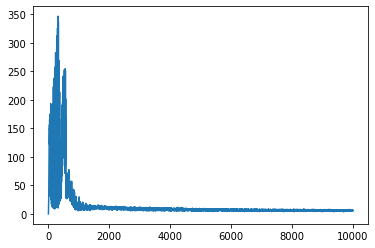

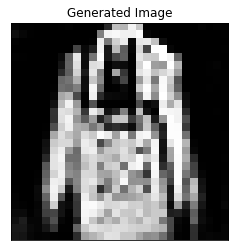

checkpointing at epoch: 10000


In [11]:
import time
from pathlib import Path

start_epoch = 1
epochs = 10000
batch_size = 64
checkpoint_every_n_epochs = 10000
figure_every_n_epochs = 500
n_critic = 5



plt.ioff()

model_type = f'dragan'
data_name = f'fashion-MNIST'


#create base dir
base_model_path = Path(f'./model-data/{model_type}/{data_name}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    
    if start_epoch == 1:
        training_imgs = np.cast['float32'](x_train)
        num_batches = len(training_imgs) // batch_size
        rl_lo_loss_list = [] 
        rl_med_loss_list = [] 
        rl_hi_loss_list = [] 
        kl_loss_list = []
        gen_loss_list = []
        critic_real_list = []
        critic_fake_list = []
        mu, sigma = 0, 1 #mean and standard deviation
        test_noise = np.random.normal(mu, sigma, (1, latent_dim))
    

    rl_lo_loss = 0
    rl_med_loss = 0
    rl_hi_loss = 0
    kl_loss = 0
    gen_loss = 0

    
    for epoch in range(start_epoch,epochs+1):
        start = time.time()
        print(f'Iteration [{epoch}/{epochs}]...'.ljust(20), end = '')
 
        
        
        critic_real_sum = 0
        critic_fake_sum = 0
        for _ in range(n_critic):
            idxs_batch = np.random.randint(0,len(training_imgs)-1,size=batch_size)
            img_batch = training_imgs[idxs_batch]
            critic_real, critic_fake = train_step_critic(img_batch)
            critic_real_sum += K.get_value(critic_real)
            critic_fake_sum += K.get_value(critic_fake)            
        
        
        
        gen_loss = train_step_generator()
        
        
        
        critic_real = critic_real_sum/n_critic
        critic_fake = critic_fake_sum/n_critic
        gen_loss = K.get_value(gen_loss)

        
        
        critic_real_list.append(critic_real)
        critic_fake_list.append(critic_fake)
        gen_loss_list.append(gen_loss)

        
        print(f'...{time.time()-start:.3f}(s) '  , end='')        
        
        print(f'gen: {gen_loss:.5f} - ', end='')
        print(f'critic_fake: {critic_fake:.5f} - ', end='')
        print(f'critic_real: {critic_real:.5f} - ', end='')
        print(f'neg_critic: {critic_real - critic_fake:.5f}')

        

        if epoch % figure_every_n_epochs == 0:
            
            # plot fig for r - f to observe convergence
            negative_critic_loss = np.array(critic_real_list)-np.array(critic_fake_list)
            plt.plot(negative_critic_loss, label="negative_critic")
            plt.show()
            
            gen_img = unnormalize_tanh( generator.predict(test_noise)[0])        
            plt.imshow(gen_img.reshape(28,28), cmap='gray')
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


        if epoch % checkpoint_every_n_epochs == 0 and epoch != 0:        
            print(f'checkpointing at epoch: {epoch}')
            generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
            generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
            critic.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-critic-weights.h5').as_posix())
            critic.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-critic.h5').as_posix())
            

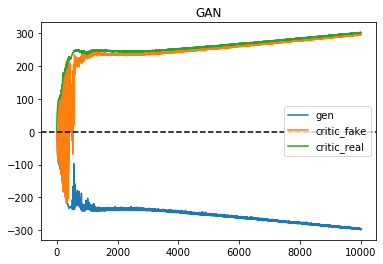

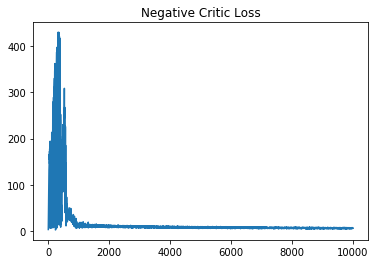

In [12]:
plt.plot(gen_loss_list, label="gen")
plt.plot(critic_fake_list, label="critic_fake")
plt.plot(critic_real_list, label="critic_real")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title("GAN")
plt.savefig(figure_model_path / 'gan.png')
plt.show()

negative_critic_loss  = np.array(critic_real_list)-np.array(critic_fake_list)
plt.plot(negative_critic_loss)
plt.title("Negative Critic Loss")
plt.savefig(figure_model_path / 'negative_critic.png')
plt.show()

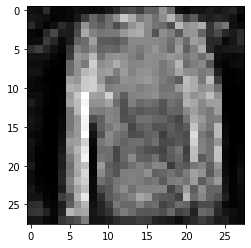

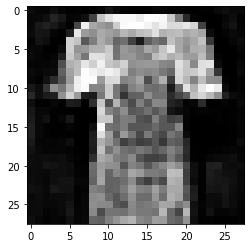

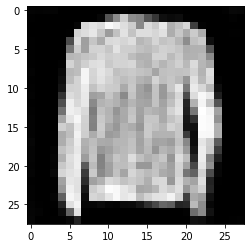

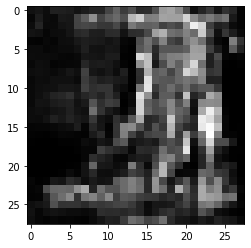

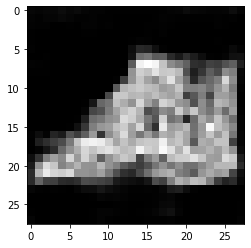

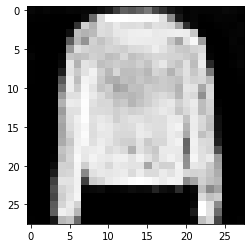

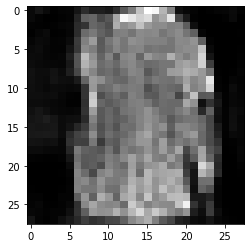

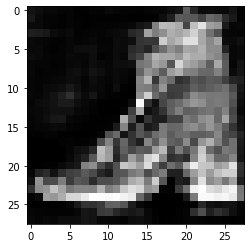

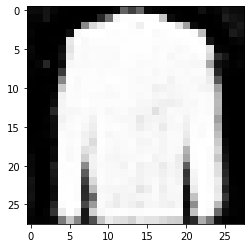

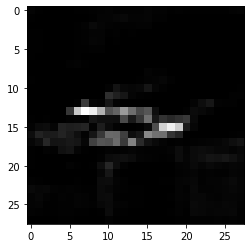

In [13]:
for i in range(10):
    noise = np.random.normal(0,1, (1,100))
    gen_img = unnormalize_tanh( generator.predict(noise)[0])        
    plt.imshow(gen_img.reshape(28,28), cmap='gray')
    plt.show()

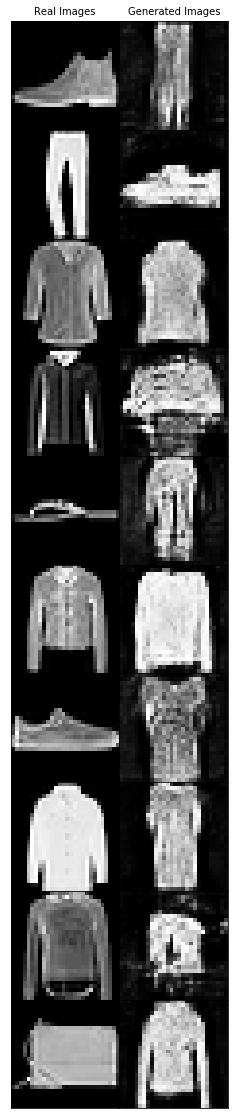

In [14]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(100., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 2),  # creates 2x2 grid of axes
                 axes_pad=0.0,  # pad between axes in inch.
                 )


for i in range(20):
    if i % 2 == 0:
        grid[i].imshow(x_test[i].reshape(28,28), cmap='gray')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
    
    else:
        noise = np.random.normal(0,1, (1,100))
        gen_img = unnormalize_tanh( generator.predict(noise)[0])  
        grid[i].imshow(gen_img.reshape(28,28), cmap='gray')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
grid[0].set_title('Real Images', fontsize=10.)
grid[1].set_title('Generated Images', fontsize=10.)
plt.show()